In [156]:
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import os
import plotly.graph_objects as go
import numpy as np
from plotly.offline import init_notebook_mode, iplot

import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.cm import ScalarMappable

# Define Data paths and Preprocessing

In [157]:
data_name = 'papyrus'
activity_type = 'xc50'
# activity_type = 'kx'
type_n_targets = 'all'
# project_name = '2024-06-25-all-models-100'
# project_name = '2024-09-17-metrics-all2'
# project_name = '2024-07-22-all-models-100-kx'
# project_out_name = f'reassess-{project_name}'
project_name = '2025-01-08-xc50-all'
project_out_name = project_name
data_specific_path = f'{data_name}/{activity_type}/{type_n_targets}'
# DESCRIPTORS
descriptor_protein='ankh-large'
descriptor_chemical='ecfp2048'
prot_input_dim=1536
chem_input_dim=2048

file_1 = f'/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-runs_ensemble_mcdp_xc50/metrics.csv'
file_2 = f'/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-runs_evidential_xc50/metrics.csv'

# file_path = f'/users/home/bkhalil/Repos/uqdd/uqdd/figures/{data_specific_path}/{project_out_name}/metrics|_.csv'
# file_path = f'/users/home/bkhalil/Repos/uqdd/uqdd/figures/{data_specific_path}/metrics_manual.csv'
# file_path = f'/users/home/bkhalil/Repos/uqdd/uqdd/figures/{data_specific_path}/xc50-metrics-all2.csv'
# file_path = f'/users/home/bkhalil/Repos/uqdd/uqdd/figures/{data_specific_path}/{project_out_name}/metrics.csv'
save_dir = f'/users/home/bkhalil/Repos/uqdd/uqdd/figures/{data_specific_path}/{project_out_name}/'
save_dir_no_time = f'/users/home/bkhalil/Repos/uqdd/uqdd/figures/{data_specific_path}/{project_out_name}-no-time/'

In [159]:
# df_main = pd.read_csv(file_path, header=0)
# df_main.columns = df_main.columns.str.strip() 
# # print(df_main.shape)
# df_main.head(10)
df_1 = pd.read_csv(file_1, header=0)
print(df_1.shape)
df_2 = pd.read_csv(file_2, header=0)
print(df_2.shape)

df_main = pd.concat([df_1, df_2])
# df_main = pd.read_csv(file_path, header=0)
# df_main.columns = df_main.columns.str.strip() 
print(df_main.shape)
# df_main.head(10)

(540, 43)
(360, 43)
(900, 43)


In [160]:
# Extract the run name from 'model name' in the main data
# df_main['RunName'] = df_main['model name'].apply(lambda x: x.split('_')[-1])

df_main.head()

Model type                                            Task Activity Split  \
0   ensemble                                             PCM     xc50  time   
1   ensemble                                  PCM_subset_100     xc50  time   
2   ensemble                          PCM_before_calibration     xc50  time   
3   ensemble               PCM_before_calibration_subset_100     xc50  time   
4   ensemble  PCM_after_calibration_with_isotonic_regression     xc50  time   

    desc_prot desc_chem  dropout        R2      RMSE       MAE  ...  \
0  ankh-large  ecfp2048      0.2  0.055331  1.118996  0.898933  ...   
1  ankh-large  ecfp2048      0.2  0.055331  1.118996  0.898933  ...   
2  ankh-large  ecfp2048      0.2  0.055331  1.118996  0.898933  ...   
3  ankh-large  ecfp2048      0.2  0.055331  1.118996  0.898933  ...   
4  ankh-large  ecfp2048      0.2  0.055331  1.118996  0.898933  ...   

   Z_mean_CI_high  rmv_rmse_slope  rmv_rmse_r_sq  rmv_rmse_intercept  \
0       -0.142296        0.147822       0.084114            0.931831   
1       -0.142338        0.147822       0.084114            0.931831   
2       -0.142873        0.147822       0.084114            0.931831   
3       -0.142252        0.147822       0.084114            0.931831   
4       -0.142111        0.147822       0.084114            0.931831   

   aleatoric_uct_mean  epistemic_uct_mean  total_uct_mean  \
0            1.232311             0.12317        1.355482   
1            1.232311             0.12317        1.355482   
2                 NaN                 NaN             NaN   
3                 NaN                 NaN             NaN   
4                 NaN                 NaN             NaN   

                      wandb project           wandb run  \
0  reassess-runs_ensemble_mcdp_xc50  legendary-dust-112   
1  reassess-runs_ensemble_mcdp_xc50  legendary-dust-112   
2  reassess-runs_ensemble_mcdp_xc50  legendary-dust-112   
3  reassess-runs_ensemble_mcdp_xc50  legendary-dust-112   
4  reassess-runs_ensemble_mcdp_xc50  legendary-dust-112   

                                          model name  
0  20240813-papyrus_xc50_ensemble_time_ankh-large...  
1  20240813-papyrus_xc50_ensemble_time_ankh-large...  
2  20240813-papyrus_xc50_ensemble_time_ankh-large...  
3  20240813-papyrus_xc50_ensemble_time_ankh-large...  
4  20240813-papyrus_xc50_ensemble_time_ankh-large...  

[5 rows x 43 columns]

In [100]:
print(534/6)
df_main.shape[0]/6

89.0


150.0

In [161]:
# # replace random with stratified for the random split
df_main['Split'] = df_main['Split'].apply(lambda x: 'stratified' if x == 'random' else x)

df_merged = df_main.copy()

# Remove some rows where MCDP experiment was run 
df_merged = df_merged[~((df_merged['Model type'] == 'mcdropout') & (df_merged['Split'] == 'scaffold_cluster') & (df_merged['dropout'] == 0.2))]
df_merged = df_merged[~((df_merged['Model type'] == 'mcdropout') & (df_merged['Split'] == 'stratified') & (df_merged['dropout'] == 0.1))]
df_merged = df_merged[~((df_merged['Model type'] == 'mcdropout') & (df_merged['Split'] == 'time') & (df_merged['dropout'] == 0.1))]

df_merged['Group'] = df_merged.apply(lambda row: f"{row['Split']}_{row['Model type']}", axis=1)

# Extracting the necessary parts for plotting and make copies to avoid SettingWithCopyWarning
# df_pcm with exact match of task pcm
df_pcm = df_merged[df_merged['Task'] == 'PCM'].copy()
df_before_calib = df_merged[df_merged['Task'] == 'PCM_before_calibration'].copy()
df_before_calib['Calibration'] = 'Before Calibration'

df_after_calib = df_merged[df_merged['Task'] == 'PCM_after_calibration_with_isotonic_regression'].copy()
df_after_calib['Calibration'] = 'After Calibration'

df_calib = pd.concat([df_before_calib, df_after_calib])
df_calib_no_time = df_calib.copy()[df_calib['Split'] != 'time']
# SUBSET 100
subdf_pcm = df_merged[df_merged['Task'] == 'PCM_subset100'].copy()
subdf_before_calib = df_merged[df_merged['Task'] == 'PCM_before_calibration_subset100'].copy()
subdf_before_calib['Calibration'] = 'Before Calibration'

subdf_after_calib = df_merged[df_merged['Task'] == 'PCM_after_calibration_with_isotonic_regression_subset100'].copy()
subdf_after_calib['Calibration'] = 'After Calibration'

subdf_calib = pd.concat([subdf_before_calib, subdf_after_calib])
subdf_calib_no_time = subdf_calib.copy()[subdf_calib['Split'] != 'time']
#
# group_order = [
#     "stratified_ensemble",
#     "stratified_evidential",
#     "stratified_mcdropout",
#     "scaffold_cluster_ensemble",
#     "scaffold_cluster_evidential",
#     "scaffold_cluster_mcdropout"
# ]


In [102]:
# df_after_calib.head()

In [162]:
df_pcm.shape

(120, 44)

In [163]:
df_pcm.head()

Model type Task Activity             Split   desc_prot desc_chem  dropout  \
0    ensemble  PCM     xc50              time  ankh-large  ecfp2048      0.2   
6    ensemble  PCM     xc50  scaffold_cluster  ankh-large  ecfp2048      0.2   
12   ensemble  PCM     xc50        stratified  ankh-large  ecfp2048      0.1   
30   ensemble  PCM     xc50  scaffold_cluster  ankh-large  ecfp2048      0.2   
36   ensemble  PCM     xc50  scaffold_cluster  ankh-large  ecfp2048      0.2   

          R2      RMSE       MAE  ...  rmv_rmse_slope  rmv_rmse_r_sq  \
0   0.055331  1.118996  0.898933  ...        0.147822       0.084114   
6   0.437744  0.877445  0.684918  ...        0.425579       0.562917   
12  0.626951  0.736910  0.558098  ...        0.998964       0.879338   
30  0.437580  0.877573  0.685238  ...        0.431413       0.569994   
36  0.437250  0.877830  0.685016  ...        0.418217       0.566448   

    rmv_rmse_intercept  aleatoric_uct_mean  epistemic_uct_mean  \
0             0.931831            1.232311            0.123170   
6             0.544932            0.766696            0.226535   
12            0.213471            0.503729            0.140191   
30            0.540777            0.766310            0.227445   
36            0.550652            0.768537            0.226540   

    total_uct_mean                     wandb project              wandb run  \
0         1.355482  reassess-runs_ensemble_mcdp_xc50     legendary-dust-112   
6         0.993232  reassess-runs_ensemble_mcdp_xc50        cosmic-field-83   
12        0.643921  reassess-runs_ensemble_mcdp_xc50           clear-wood-4   
30        0.993756  reassess-runs_ensemble_mcdp_xc50  cerulean-resonance-23   
36        0.995077  reassess-runs_ensemble_mcdp_xc50          leafy-wood-84   

                                           model name  \
0   20240813-papyrus_xc50_ensemble_time_ankh-large...   
6   20240626-papyrus_xc50_ensemble_scaffold_cluste...   
12  20240625-papyrus_xc50_ensemble_random_ankh-lar...   
30  20240625-papyrus_xc50_ensemble_scaffold_cluste...   
36  20240627-papyrus_xc50_ensemble_scaffold_cluste...   

                        Group  
0               time_ensemble  
6   scaffold_cluster_ensemble  
12        stratified_ensemble  
30  scaffold_cluster_ensemble  
36  scaffold_cluster_ensemble  

[5 rows x 44 columns]

In [166]:
df_pcm.head()

Model type Task Activity             Split   desc_prot desc_chem  dropout  \
0    ensemble  PCM     xc50              time  ankh-large  ecfp2048      0.2   
6    ensemble  PCM     xc50  scaffold_cluster  ankh-large  ecfp2048      0.2   
12   ensemble  PCM     xc50        stratified  ankh-large  ecfp2048      0.1   
30   ensemble  PCM     xc50  scaffold_cluster  ankh-large  ecfp2048      0.2   
36   ensemble  PCM     xc50  scaffold_cluster  ankh-large  ecfp2048      0.2   

          R2      RMSE       MAE  ...  rmv_rmse_slope  rmv_rmse_r_sq  \
0   0.055331  1.118996  0.898933  ...        0.147822       0.084114   
6   0.437744  0.877445  0.684918  ...        0.425579       0.562917   
12  0.626951  0.736910  0.558098  ...        0.998964       0.879338   
30  0.437580  0.877573  0.685238  ...        0.431413       0.569994   
36  0.437250  0.877830  0.685016  ...        0.418217       0.566448   

    rmv_rmse_intercept  aleatoric_uct_mean  epistemic_uct_mean  \
0             0.931831            1.232311            0.123170   
6             0.544932            0.766696            0.226535   
12            0.213471            0.503729            0.140191   
30            0.540777            0.766310            0.227445   
36            0.550652            0.768537            0.226540   

    total_uct_mean                     wandb project              wandb run  \
0         1.355482  reassess-runs_ensemble_mcdp_xc50     legendary-dust-112   
6         0.993232  reassess-runs_ensemble_mcdp_xc50        cosmic-field-83   
12        0.643921  reassess-runs_ensemble_mcdp_xc50           clear-wood-4   
30        0.993756  reassess-runs_ensemble_mcdp_xc50  cerulean-resonance-23   
36        0.995077  reassess-runs_ensemble_mcdp_xc50          leafy-wood-84   

                                           model name  \
0   20240813-papyrus_xc50_ensemble_time_ankh-large...   
6   20240626-papyrus_xc50_ensemble_scaffold_cluste...   
12  20240625-papyrus_xc50_ensemble_random_ankh-lar...   
30  20240625-papyrus_xc50_ensemble_scaffold_cluste...   
36  20240627-papyrus_xc50_ensemble_scaffold_cluste...   

                        Group  
0               time_ensemble  
6   scaffold_cluster_ensemble  
12        stratified_ensemble  
30  scaffold_cluster_ensemble  
36  scaffold_cluster_ensemble  

[5 rows x 44 columns]

In [185]:
# RESULTS AGGREGATION TO CREATE THE FINAL RESULTS TABLE
def aggregate_results_csv(df, group_cols, numeric_cols, string_cols, order_by=None, output_file_path=None):
    # Group the DataFrame by the specified columns
    grouped = df.groupby(group_cols)
    # Aggregate the numeric columns
    aggregated = grouped[numeric_cols].agg(['mean', 'std'])
    # Combine mean and std into the required format
    for col in numeric_cols:
        aggregated[(col, 'combined')] = aggregated[(col, 'mean')].round(3).astype(str) + '(' + aggregated[(col, 'std')].round(3).astype(str) + ')'
    # Drop the separate mean and std columns, keeping only the combined column
    aggregated = aggregated[[col for col in aggregated.columns if col[1] == 'combined']]

    # Rename the columns to a simpler format
    aggregated.columns = [col[0] for col in aggregated.columns]

    # Step 6: Aggregate the string columns into lists
    string_aggregated = grouped[string_cols].agg(lambda x: list(x))

    # Step 7: Create the new column combining wandb project and model name
    df['project_model'] = 'papyrus' + '/' + df['Activity'] + '/' + 'all' + '/' + df['wandb project'] + '/' + df['model name'] + '/'
    project_model_aggregated = grouped['project_model'].agg(lambda x: list(x))
    
    # Combine the numeric and string aggregations
    final_aggregated = pd.concat([aggregated, string_aggregated, project_model_aggregated], axis=1).reset_index()

    if order_by:
        final_aggregated = final_aggregated.sort_values(by=order_by)
        
    if output_file_path:
        final_aggregated.to_csv(output_file_path, index=False)
        
    return final_aggregated

# # Group the DataFrame by the specified columns
# grouped = df.groupby(group_cols)
# # Aggregate the numeric columns
# aggregated = grouped[numeric_cols].agg(['mean', 'std'])
# # Combine mean and std into the required format
# for col in numeric_cols:
#     aggregated[(col, 'combined')] = aggregated[(col, 'mean')].round(3).astype(str) + ' (' + aggregated[(col, 'std')].round(3).astype(str) + ')'
# # Drop the separate mean and std columns, keeping only the combined column
# aggregated = aggregated[[col for col in aggregated.columns if col[1] == 'combined']]
# 
# # Rename the columns to a simpler format
# aggregated.columns = [col[0] for col in aggregated.columns]
# 
# # Step 6: Aggregate the string columns into lists
# string_aggregated = grouped[string_cols].agg(lambda x: list(x))
# 
# # Combine the numeric and string aggregations
# final_aggregated = pd.concat([aggregated, string_aggregated], axis=1).reset_index()

In [209]:
group_cols = ['Model type', 'Task', 'Activity', 'Split', 'desc_prot', 'desc_chem', 'dropout']
numeric_cols = ['RMSE', 'R2', 'MAE', 'MDAE', 'MARPD', 'PCC', 'RMS Calibration', 'MA Calibration',
                    'Miscalibration Area', 'Sharpness', 'NLL', 'CRPS', 'Check', 'Interval', 'rho_rank',
                    'rho_rank_sim', 'rho_rank_sim_std', 'uq_mis_cal', 'uq_NLL', 'uq_NLL_sim', 
                    'uq_NLL_sim_std', 'Z_var', 'Z_var_CI_low', 'Z_var_CI_high', 'Z_mean', 
                    'Z_mean_CI_low', 'Z_mean_CI_high', 'rmv_rmse_slope', 'rmv_rmse_r_sq','rmv_rmse_intercept', 'aleatoric_uct_mean', 'epistemic_uct_mean', 
                    'total_uct_mean']
string_cols = ['wandb project', 'wandb run', 'model name']
order_by = ['Split', 'Model type']
# TODO 

# output_file_path = '/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100_for_metrics/final_aggregated_2.csv'
os.makedirs(save_dir, exist_ok=True)
output_file_path = os.path.join(save_dir, 'final_aggregated.csv')
df_no_time = df_pcm.copy()[df_pcm['Split'] != 'time']
print(df_pcm.shape)
print(df_no_time.shape)
# save_dir = '/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/2024-09-18-metrics-no-time/'
# os.makedirs(save_dir, exist_ok=True)
final_aggregated = aggregate_results_csv(df_pcm, group_cols, numeric_cols, string_cols, order_by, output_file_path)
# 'Group'
final_aggregated['Group'] = final_aggregated.apply(lambda row: f"{row['Split']}_{row['Model type']}", axis=1)

os.makedirs(save_dir_no_time, exist_ok=True)
output_file_path_no_time = os.path.join(save_dir_no_time, 'final_aggregated_no_time.csv')
final_aggregated_no_time = aggregate_results_csv(df_no_time, group_cols, numeric_cols, string_cols, order_by, output_file_path_no_time)
final_aggregated_no_time['Group'] = final_aggregated_no_time.apply(lambda row: f"{row['Split']}_{row['Model type']}", axis=1)

(120, 45)
(100, 45)


In [187]:
final_aggregated.loc[0, 'project_model']

['papyrus/xc50/all/reassess-runs_evidential_xc50/20241127-papyrus_xc50_emc_scaffold_cluster_ankh-large_ecfp2048_47_rose-sky-89/',
 'papyrus/xc50/all/reassess-runs_evidential_xc50/20241127-papyrus_xc50_emc_scaffold_cluster_ankh-large_ecfp2048_42_dulcet-totem-85/',
 'papyrus/xc50/all/reassess-runs_evidential_xc50/20241127-papyrus_xc50_emc_scaffold_cluster_ankh-large_ecfp2048_43_cool-tree-84/',
 'papyrus/xc50/all/reassess-runs_evidential_xc50/20241127-papyrus_xc50_emc_scaffold_cluster_ankh-large_ecfp2048_44_lunar-universe-86/',
 'papyrus/xc50/all/reassess-runs_evidential_xc50/20241127-papyrus_xc50_emc_scaffold_cluster_ankh-large_ecfp2048_48_sunny-bee-91/',
 'papyrus/xc50/all/reassess-runs_evidential_xc50/20241127-papyrus_xc50_emc_scaffold_cluster_ankh-large_ecfp2048_51_efficient-paper-93/',
 'papyrus/xc50/all/reassess-runs_evidential_xc50/20241127-papyrus_xc50_emc_scaffold_cluster_ankh-large_ecfp2048_45_different-terrain-87/',
 'papyrus/xc50/all/reassess-runs_evidential_xc50/20241127-papy

In [188]:
final_aggregated.head(5)

Model type Task Activity             Split   desc_prot desc_chem  dropout  \
0         emc  PCM     xc50  scaffold_cluster  ankh-large  ecfp2048      0.2   
2    ensemble  PCM     xc50  scaffold_cluster  ankh-large  ecfp2048      0.2   
5         eoe  PCM     xc50  scaffold_cluster  ankh-large  ecfp2048      0.2   
7  evidential  PCM     xc50  scaffold_cluster  ankh-large  ecfp2048      0.2   
9   mcdropout  PCM     xc50  scaffold_cluster  ankh-large  ecfp2048      0.1   

           RMSE            R2           MAE  ... rmv_rmse_r_sq  \
0  0.921(0.003)  0.381(0.004)  0.716(0.003)  ...  0.015(0.021)   
2  0.878(0.001)  0.437(0.001)  0.685(0.001)  ...  0.583(0.028)   
5   0.87(0.002)  0.447(0.002)  0.675(0.001)  ...  0.147(0.087)   
7  0.907(0.007)  0.399(0.009)  0.705(0.006)  ...  0.084(0.074)   
9  0.928(0.006)  0.371(0.008)  0.726(0.005)  ...  0.716(0.037)   

  rmv_rmse_intercept aleatoric_uct_mean epistemic_uct_mean total_uct_mean  \
0       0.919(0.075)       1.052(0.031)       2.513(0.038)   3.565(0.062)   
2       0.542(0.022)       0.776(0.023)         0.23(0.01)   1.006(0.033)   
5       3.017(1.035)       1.015(0.009)       2.535(0.013)    3.55(0.017)   
7       0.964(1.929)       1.009(0.009)       2.376(0.031)   3.385(0.032)   
9         0.6(0.015)       0.705(0.016)        0.48(0.018)   1.185(0.027)   

                                       wandb project  \
0  [reassess-runs_evidential_xc50, reassess-runs_...   
2  [reassess-runs_ensemble_mcdp_xc50, reassess-ru...   
5  [reassess-runs_evidential_xc50, reassess-runs_...   
7  [reassess-runs_evidential_xc50, reassess-runs_...   
9  [reassess-runs_ensemble_mcdp_xc50, reassess-ru...   

                                           wandb run  \
0  [rose-sky-89, dulcet-totem-85, cool-tree-84, l...   
2  [cosmic-field-83, cerulean-resonance-23, leafy...   
5  [solar-hill-33, soft-grass-31, laced-water-40,...   
7  [amber-galaxy-20, major-smoke-19, crisp-dust-1...   
9  [apricot-glitter-34, earthy-dew-43, warm-tree-...   

                                          model name  \
0  [20241127-papyrus_xc50_emc_scaffold_cluster_an...   
2  [20240626-papyrus_xc50_ensemble_scaffold_clust...   
5  [20241120-papyrus_xc50_eoe_scaffold_cluster_an...   
7  [20241119-papyrus_xc50_evidential_scaffold_clu...   
9  [20240625-papyrus_xc50_mcdropout_scaffold_clus...   

                                       project_model  \
0  [papyrus/xc50/all/reassess-runs_evidential_xc5...   
2  [papyrus/xc50/all/reassess-runs_ensemble_mcdp_...   
5  [papyrus/xc50/all/reassess-runs_evidential_xc5...   
7  [papyrus/xc50/all/reassess-runs_evidential_xc5...   
9  [papyrus/xc50/all/reassess-runs_ensemble_mcdp_...   

                         Group  
0         scaffold_cluster_emc  
2    scaffold_cluster_ensemble  
5         scaffold_cluster_eoe  
7  scaffold_cluster_evidential  
9   scaffold_cluster_mcdropout  

[5 rows x 45 columns]

In [177]:
df_pcm.to_csv(os.path.join(save_dir, 'final.csv'), index=False)
df_no_time.to_csv(os.path.join(save_dir_no_time, 'final_no_time.csv'), index=False)

In [109]:
# output_file_path2 = '/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/final_aggregated_2.tex'
# final_aggregated.to_csv(output_file_path2, index=False, sep="&", lineterminator=" \\\\\n" )

In [110]:
# SEPARATE SPECIAL MC EXPERIMENT
mcdp_df = df_main[df_main['Model type'] == 'mcdropout'].copy()

mcdp_df['Group'] = mcdp_df.apply(lambda row: f"{row['Split']}_dropout{row['dropout']}", axis=1)

mcdp_df_pcm = mcdp_df[mcdp_df['Task'] == 'PCM'].copy()
mcdp_before_calib = mcdp_df[mcdp_df['Task'] == 'PCM_before_calibration'].copy()
mcdp_before_calib['Calibration'] = 'Before Calibration'

mcdp_after_calib_iso = mcdp_df[mcdp_df['Task'] == 'PCM_after_calibration_with_isotonic_regression'].copy()
mcdp_after_calib_iso['Calibration'] = 'After Calibration'
mcdp_calib = pd.concat([mcdp_before_calib, mcdp_after_calib_iso])

submcdp_df_pcm = mcdp_df[mcdp_df['Task'] == 'PCM_subset100'].copy()
submcdp_before_calib = mcdp_df[mcdp_df['Task'] == 'PCM_before_calibration_subset100'].copy()
submcdp_before_calib['Calibration'] = 'Before Calibration'

submcdp_after_calib_iso = mcdp_df[mcdp_df['Task'] == 'PCM_after_calibration_with_isotonic_regression_subset100'].copy()
submcdp_after_calib_iso['Calibration'] = 'After Calibration'

submcdp_calib = pd.concat([submcdp_before_calib, submcdp_after_calib_iso])

mc_group_order = [
    "stratified_dropout0.1",
    "stratified_dropout0.2",
    "scaffold_cluster_dropout0.1",
    "scaffold_cluster_dropout0.2",
    "time_dropout0.1",
    "time_dropout0.2"
]
mc_group_order_no_time = [
    "stratified_dropout0.1",
    "stratified_dropout0.2",
    "scaffold_cluster_dropout0.1",
    "scaffold_cluster_dropout0.2",
]

## Helper plotting functions

In [111]:
group_order = [
    "stratified_ensemble",
    "stratified_eoe",
    "stratified_evidential",
    "stratified_emc",
    "stratified_mcdropout",
    "scaffold_cluster_ensemble",
    "scaffold_cluster_eoe",
    "scaffold_cluster_evidential",
    "scaffold_cluster_emc",
    "scaffold_cluster_mcdropout",
    "time_ensemble",
    "time_eoe",
    "time_evidential",
    "time_emc",
    "time_mcdropout",
]
group_order_no_time = [
    "stratified_ensemble",
    "stratified_eoe",
    "stratified_evidential",
    "stratified_emc",
    "stratified_mcdropout",
    "scaffold_cluster_ensemble",
    "scaffold_cluster_eoe",
    "scaffold_cluster_evidential",
    "scaffold_cluster_emc",
    "scaffold_cluster_mcdropout",
]
hatches_dict = {
        "stratified": "\\\\",
        "scaffold_cluster": "",
        # "time": "....",
        "time": "///",
    }

hatches_dict_no_time = {
        "stratified": "\\\\",
        "scaffold_cluster": "",
    }


In [112]:
# HELPER FUNCTIONS FOR PLOTTING #
def save_plot(fig, save_dir, plot_name, tighten=True):
    if tighten:
        plt.tight_layout()
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        fig.savefig(os.path.join(save_dir, f"{plot_name}.png"), dpi=1200)
        fig.savefig(os.path.join(save_dir, f"{plot_name}.svg"))
        fig.savefig(os.path.join(save_dir, f"{plot_name}.pdf"))
        fig.savefig(os.path.join(save_dir, f"{plot_name}.eps"))
        
# Function to handle inf values
def handle_inf_values(df):
    df = df.replace([float('inf'), -float('inf')], float('nan'))
    return df


# Pair plot for visualizing relationships
def plot_pairplot(df, title, metrics, save_dir=None, cmap="viridis", group_order=group_order):
    df = handle_inf_values(df)
    sns.pairplot(
        df, 
        hue='Group', 
        hue_order=group_order,
        # markers=['o', 's'],
        vars=metrics, 
        palette=cmap, 
        plot_kws={'alpha': 0.7}
    )
    plt.suptitle(title, y=1.02)
    plot_name = f"pairplot_{title.replace(' ', '_')}"
    save_plot(plt.gcf(), save_dir, plot_name, tighten=False)
    plt.show()

# Function to plot line metrics
def plot_line_metrics(df, title, metrics, save_dir=None, group_order=group_order):
    df = handle_inf_values(df)
    plt.figure(figsize=(14, 7))
    for metric in metrics:
        sns.lineplot(data=df, x='wandb run', y=metric, hue='Group', marker='o', palette="Set2", hue_order=group_order)
        plt.title(f'{title} - {metric}')
        plt.xticks(rotation=45)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

        plot_name = f"line_{title.replace(' ', '_')}_{metric}"
        save_plot(plt.gcf(), save_dir, plot_name)

# Function to plot histograms for metrics
def plot_histogram_metrics(df, title, metrics, save_dir=None, group_order=group_order, cmap="crest"):
    df = handle_inf_values(df)
    plt.figure(figsize=(14, 7))
    for metric in metrics:
        sns.histplot(data=df, x=metric, hue='Group', kde=True, palette=cmap, element="step", hue_order=group_order, fill=True, alpha=0.7)
        plt.title(f'{title} - {metric}')
        plt.show()

        plot_name = f"histogram_{title.replace(' ', '_')}_{metric}"
        save_plot(plt.gcf(), save_dir, plot_name)

# Function to plot pairwise scatter plots for metrics
def plot_pairwise_scatter_metrics(df, title, metrics, save_dir=None, group_order=group_order, cmap="crest_r"):
    df = handle_inf_values(df)
    num_metrics = len(metrics)
    fig, axes = plt.subplots(num_metrics, num_metrics, figsize=(15, 15))
    
    for i, j in itertools.product(range(num_metrics), range(num_metrics)):
        if i != j:  # Only plot the lower triangle
            ax = sns.scatterplot(data=df, x=metrics[j], y=metrics[i], hue='Group', palette=cmap, hue_order=group_order, ax=axes[i, j], legend=False if not (i == 1 and j == 0) else 'brief')
            if i == 1 and j == 0:
                handles, labels = ax.get_legend_handles_labels()
                ax.legend().remove()
        else:
            axes[i, j].set_visible(False)  # Hide the diagonal and upper triangle subplots

        if j == 0 and i > 0:
            axes[i, j].set_ylabel(metrics[i])
        else:
            axes[i, j].set_ylabel('')
        
        if i == num_metrics - 1:
            axes[i, j].set_xlabel(metrics[j])
        else:
            axes[i, j].set_xlabel('')
    
    # Add a single legend
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.15, 1))
    fig.suptitle(title, y=1.02)
    fig.subplots_adjust(top=0.95, wspace=0.4, hspace=0.4)
    plot_name = f"pairwise_scatter_{title.replace(' ', '_')}"
    save_plot(fig, save_dir, plot_name)
    plt.show()


def plot_metrics(
        df, 
        metrics, 
        cmap="crest_r", 
        save_dir=None,
        hatches_dict=hatches_dict,
        group_order=group_order
):
    stats_dfs = []

    # Prepare data for each metric
    for metric in metrics:
        mean_df = (
            df.loc[:, ["Split", "Model type", metric]]
            .groupby(["Split", "Model type"])
            .mean()
            .rename(columns={metric: f"{metric}_mean"})
        )
        std_df = (
            df.loc[:, ["Split", "Model type", metric]]
            .groupby(["Split", "Model type"])
            .std()
            .rename(columns={metric: f"{metric}_std"})
        )
        stats_df = (
            pd.merge(mean_df, std_df, on=["Split", "Model type"])
            .sort_values(["Split", "Model type"])
            .reset_index()
            .assign(Group=lambda df: df.apply(lambda row: f"{row['Split']}_{row['Model type']}", axis=1))
        )
        stats_df['Metric'] = metric
        stats_dfs.append(stats_df)

    combined_stats_df = pd.concat(stats_dfs)
    # Ensure 'Group' column is categorical with the specified order
    if group_order:
        combined_stats_df['Group'] = pd.Categorical(combined_stats_df['Group'], categories=group_order, ordered=True)
    else:
        group_order = combined_stats_df['Group'].unique().tolist()
        
    scalar_mappable = ScalarMappable(cmap=cmap)
    model_types = combined_stats_df["Model type"].unique()
    color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
    
    # Calculate appropriate figsize based on the number of metrics
    fig_width = max(10, len(metrics) * 2)
    fig, ax = plt.subplots(figsize=(fig_width, 6))
    # fig, ax = plt.subplots(figsize=(12, 6))
    bar_width = 0.12 # 0.12
    # bar_spacing = 0.4 # 0.01
    group_spacing = 0.4 # 0.7
    num_bars = len(model_types) * len(hatches_dict)  #  len(hatches_dict)  = number of splits
    positions = []
    tick_positions = []
    tick_labels = []

    for i, metric in enumerate(metrics):
        metric_data = combined_stats_df[combined_stats_df['Metric'] == metric]
        # Sort the data according to group_order
        metric_data['Group'] = pd.Categorical(metric_data['Group'], categories=group_order, ordered=True)
        metric_data = metric_data.sort_values('Group').reset_index(drop=True)
        for j, (_, row) in enumerate(metric_data.iterrows()):
            position = i * (num_bars * bar_width + group_spacing) + (j % num_bars) * bar_width
            # position = i * (len(model_types) * (bar_width + bar_spacing) + group_spacing) + j * (bar_width + bar_spacing)
            positions.append(position)
            ax.bar(
                position,
                height=row[f"{metric}_mean"],
                color=color_dict[row["Model type"]],
                hatch=hatches_dict[row["Split"]],
                width=bar_width,
            )
        center_position = i * (num_bars * bar_width + group_spacing) + (num_bars * bar_width) / 2
        # center_position = (positions[-1] + positions[-len(model_types)]) / 2
        tick_positions.append(center_position)
        tick_labels.append(metric)
        # tick_positions.append((positions[-1] + positions[-len(model_types)]) / 2)
        # tick_labels.append(metric)

    def create_stats_legend(df, color_mapping, hatches_dict, group_order):
        patches_dict = {}
        for idx, row in df.iterrows():
            label = f"{row['Split']} {row['Model type']}"
            group_label = f"{row['Split']}_{row['Model type']}"
            if group_label not in patches_dict:
                patches_dict[group_label] = mpatches.Patch(
                    facecolor=color_mapping[row["Model type"]],
                    hatch=hatches_dict[row["Split"]],
                    label=label
                )
        # Collect patches in order of group_order
        patches = [patches_dict[group] for group in group_order if group in patches_dict]
        return patches

        
        # def create_stats_legend(df, color_mapping, hatches_dict, group_order):
        #     patches = []
        #     # patches_dict = {}
        #     for idx, row in df.iterrows():
        #         label = f"{row['Split']} {row['Model type']}"
        #         # group_label = f"{row['Split']}_{row['Model type']}"
        #         if label not in [patch.get_label() for patch in patches]:
        #             patches.append(
        #                 mpatches.Patch(
        #                     facecolor=color_mapping[row["Model type"]], 
        #                     hatch=hatches_dict[row["Split"]], 
        #                     label=label
        #                 )
        #             )
        #     return patches

    legend_elements = create_stats_legend(combined_stats_df, color_dict, hatches_dict, group_order)

    ax.legend(
        handles=legend_elements,
        bbox_to_anchor=(1.0, 1.0),
        loc="upper left",
        borderaxespad=0,
        frameon=False,
    )

    for (_, row), bar in zip(combined_stats_df.iterrows(), ax.patches):
        x_bar = bar.get_x() + bar.get_width() / 2
        y_bar = bar.get_height()
        ax.errorbar(
            x_bar,
            y_bar,
            yerr=row[f"{row['Metric']}_std"],
            color="black",
            fmt="none",
            elinewidth=1,
            capsize=3,
            alpha=0.5,
        )

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor", fontsize=9)
    ax.set_xlabel("Metrics")
    ax.set_ylabel("Values")
    metrics_names = "_".join(metrics)
    plot_name = f"barplot_{cmap}_{metrics_names}"
    save_plot(fig, save_dir, plot_name)
    plt.show()
    plt.close()
    

In [113]:
accmetrics = ['RMSE', 'R2', 'MAE', 'MDAE', 'MARPD', 'PCC']
accmetrics2 = ['RMSE', 'R2', 'PCC']
uctmetrics = [
    'RMS Calibration', 'MA Calibration', 'Miscalibration Area', 'Sharpness', 'CRPS', 'Check', 'NLL', 'Interval'
]
uctmetrics2 = ['Miscalibration Area', 'Sharpness', 'CRPS', 'NLL', 'Interval']


# make dir if not exist
# os.makedirs(save_dir, exist_ok=True)

# plot_metrics(df_pcm, accmetrics, cmap="Set2")
all_cmaps = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

## Trying all color palletes

In [114]:
# for cmap in all_cmaps:
#     print(cmap)
#     plot_metrics(df_pcm, uctmetrics, cmap=cmap, save_dir=save_dir)
# # # plot_metrics(df_pcm, accmetrics, cmap="")


## Pairplots for all metrics among Accuracy & Uncertainty

In [115]:
df_pcm.columns

Index(['Model type', 'Task', 'Activity', 'Split', 'desc_prot', 'desc_chem',
       'dropout', 'R2', 'RMSE', 'MAE', 'MDAE', 'MARPD', 'PCC',
       'RMS Calibration', 'MA Calibration', 'Miscalibration Area', 'Sharpness',
       'NLL', 'CRPS', 'Check', 'Interval', 'rho_rank', 'rho_rank_sim',
       'rho_rank_sim_std', 'uq_mis_cal', 'uq_NLL', 'uq_NLL_sim',
       'uq_NLL_sim_std', 'Z_var', 'Z_var_CI_low', 'Z_var_CI_high', 'Z_mean',
       'Z_mean_CI_low', 'Z_mean_CI_high', 'rmv_rmse_slope', 'rmv_rmse_r_sq',
       'rmv_rmse_intercept', 'aleatoric_uct_mean', 'epistemic_uct_mean',
       'total_uct_mean', 'wandb project', 'wandb run', 'model name', 'Group'],
      dtype='object')

In [116]:
# plot_pairplot(df_pcm, 'Pairplot for Accuracy Metrics', accmetrics, save_dir=save_dir, cmap="Set2")

In [117]:
# plot_pairplot(df_pcm, 'Pairplot for Uncertainty Metrics', uctmetrics, save_dir=save_dir, cmap="Set2")

## Finding Highly correlated metrics

In [118]:
def find_highly_correlated_metrics(df, metrics, threshold=0.8, save_dir=None, cmap="coolwarm"):
    # Calculate the correlation matrix
    corr_matrix = df[metrics].corr().abs()

    # Find pairs of metrics with correlation above the threshold
    highly_correlated_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if corr_matrix.iloc[i, j] > threshold:
                pair = (corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
                highly_correlated_pairs.append(pair)

    # Print the highly correlated pairs
    print("Highly correlated metrics (correlation coefficient > {}):".format(threshold))
    for pair in highly_correlated_pairs:
        print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")

    # Plot the correlation matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap=cmap)
    plt.title("Correlation Matrix")
    metrics_names = "_".join(metrics)
    plot_name = f"correlation_matrix_{threshold}_{metrics_names}"
    save_plot(plt.gcf(), save_dir, plot_name)
    plt.show()

    return highly_correlated_pairs

Highly correlated metrics (correlation coefficient > 0.9):
R2 and RMSE: 1.00
MAE and RMSE: 1.00
MAE and R2: 1.00
MDAE and RMSE: 1.00
MDAE and R2: 0.99
MDAE and MAE: 1.00
MARPD and RMSE: 1.00
MARPD and R2: 1.00
MARPD and MAE: 1.00
MARPD and MDAE: 1.00
PCC and RMSE: 0.99
PCC and R2: 1.00
PCC and MAE: 0.99
PCC and MDAE: 0.99
PCC and MARPD: 0.99


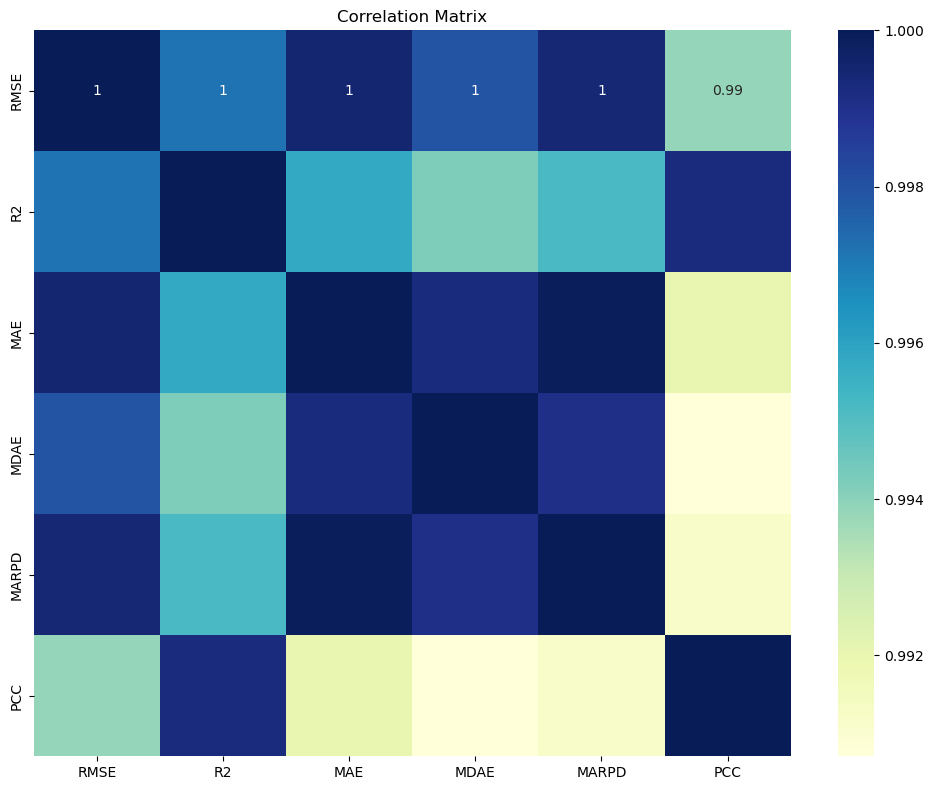

Highly correlated metrics (correlation coefficient > 0.9):
R2 and RMSE: 1.00
MAE and RMSE: 1.00
MAE and R2: 1.00
MDAE and RMSE: 0.99
MDAE and R2: 0.99
MDAE and MAE: 1.00
MARPD and RMSE: 1.00
MARPD and R2: 1.00
MARPD and MAE: 1.00
MARPD and MDAE: 1.00
PCC and RMSE: 1.00
PCC and R2: 1.00
PCC and MAE: 1.00
PCC and MDAE: 0.99
PCC and MARPD: 1.00


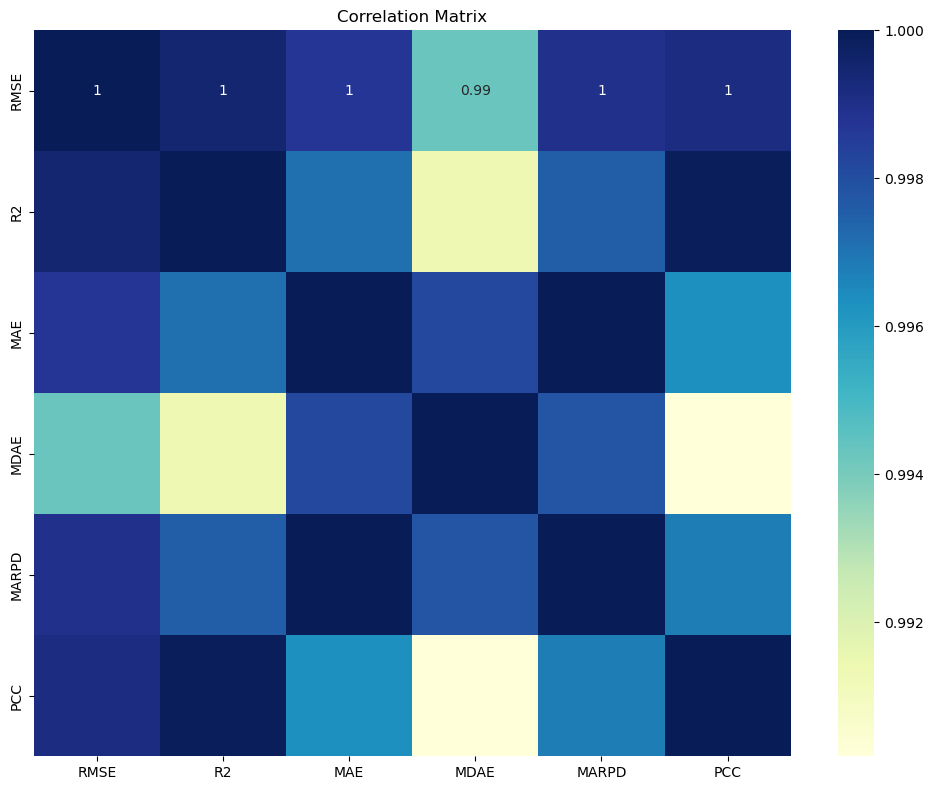

In [119]:
# save_dir=None
# highly_correlated_metrics = find_highly_correlated_metrics(df_pcm, accmetrics, threshold=0.9, save_dir=save_dir, cmap="YlGnBu")

highly_correlated_metrics = find_highly_correlated_metrics(df_pcm, accmetrics, threshold=0.9, save_dir=save_dir, cmap="YlGnBu")
highly_correlated_metrics_no_time = find_highly_correlated_metrics(df_no_time, accmetrics, threshold=0.9, save_dir=save_dir_no_time, cmap="YlGnBu")

Highly correlated metrics (correlation coefficient > 0.9):
MA Calibration and RMS Calibration: 1.00
Miscalibration Area and RMS Calibration: 1.00
Miscalibration Area and MA Calibration: 1.00
Check and CRPS: 1.00
Interval and CRPS: 0.99
Interval and Check: 0.99


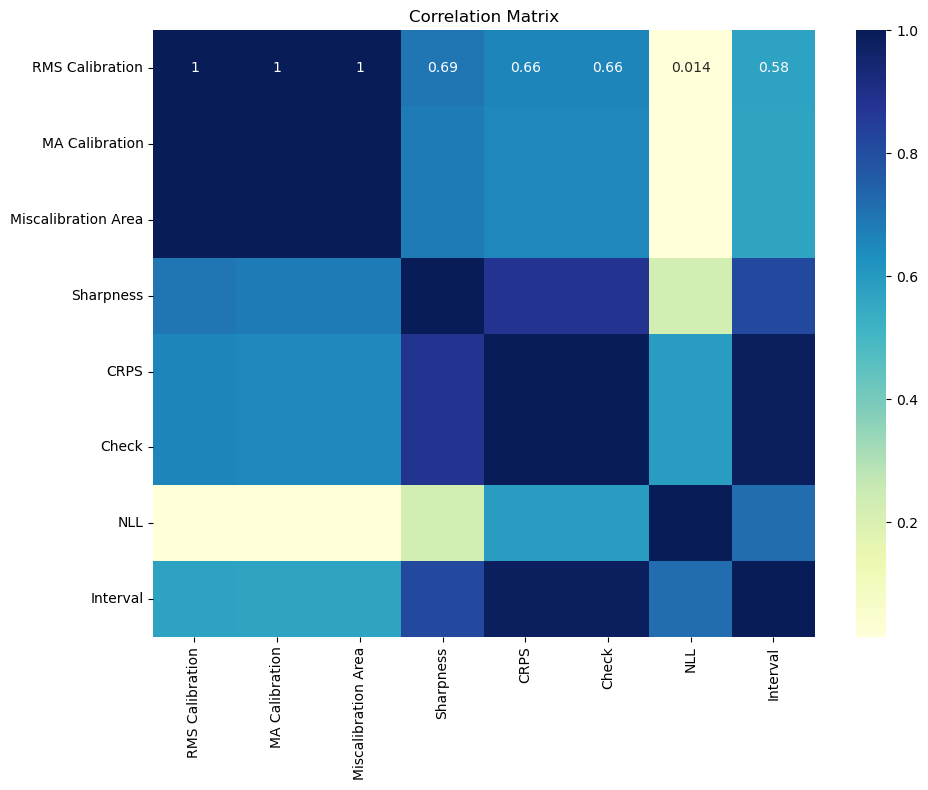

Highly correlated metrics (correlation coefficient > 0.9):
MA Calibration and RMS Calibration: 1.00
Miscalibration Area and RMS Calibration: 1.00
Miscalibration Area and MA Calibration: 1.00
Check and CRPS: 1.00
Interval and CRPS: 0.96
Interval and Check: 0.96


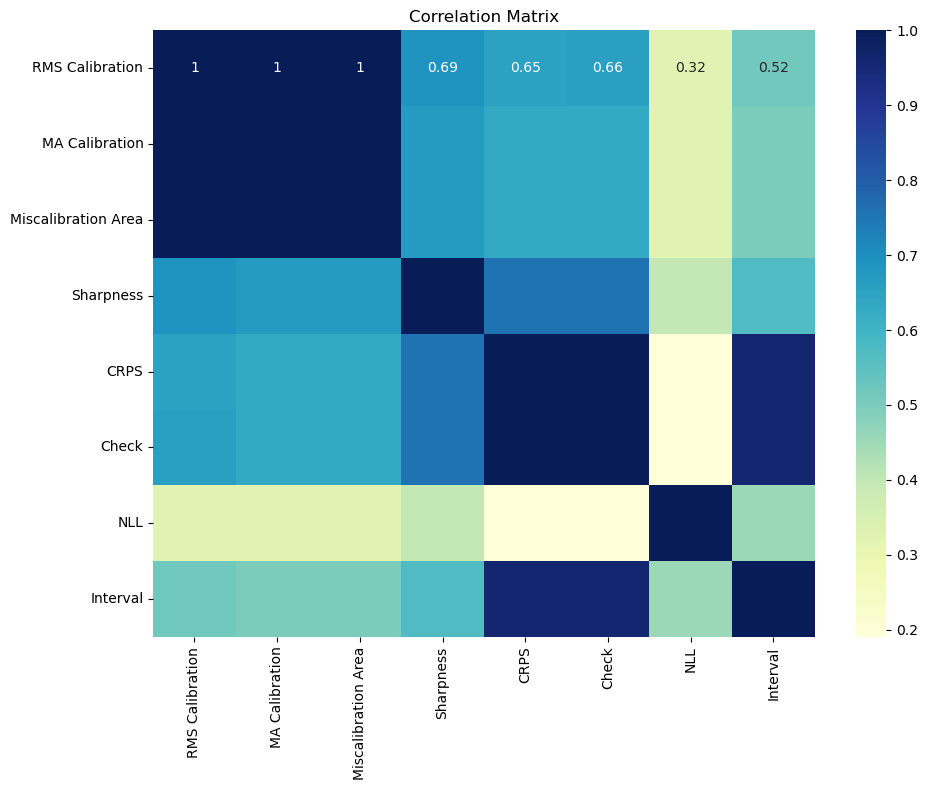

In [120]:
highly_correlated_uctmetrics = find_highly_correlated_metrics(df_pcm, uctmetrics, threshold=0.9, save_dir=save_dir, cmap="YlGnBu")
highly_correlated_uctmetrics_no_time = find_highly_correlated_metrics(df_no_time, uctmetrics, threshold=0.9, save_dir=save_dir_no_time, cmap="YlGnBu")

Highly correlated metrics (correlation coefficient > 0.9):
Interval and CRPS: 0.99


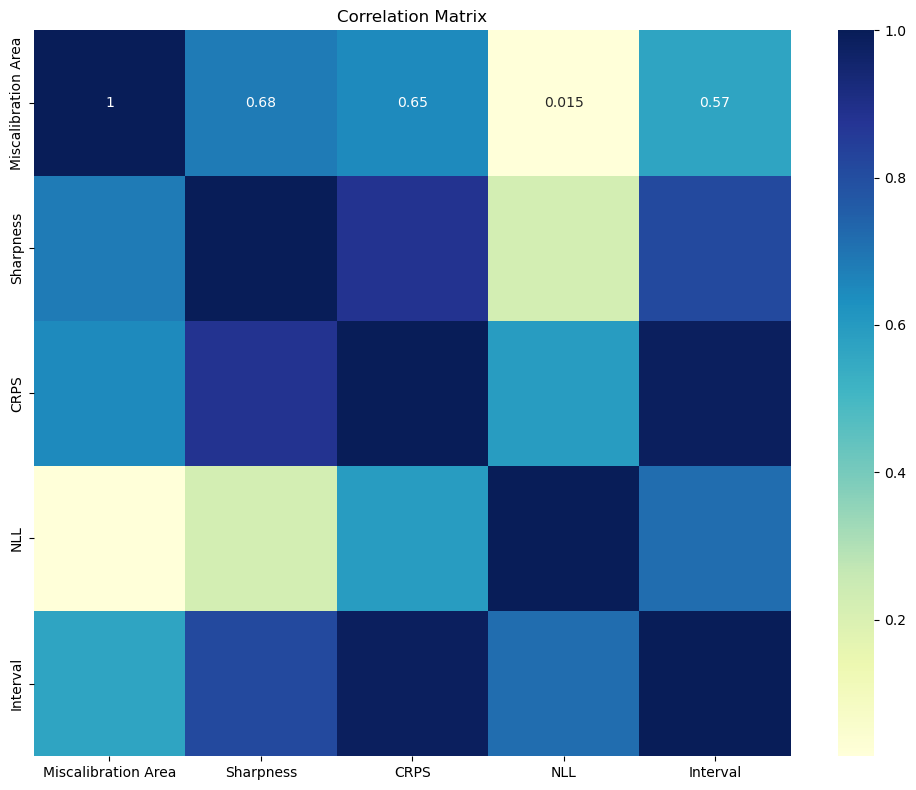

Highly correlated metrics (correlation coefficient > 0.9):
Interval and CRPS: 0.96


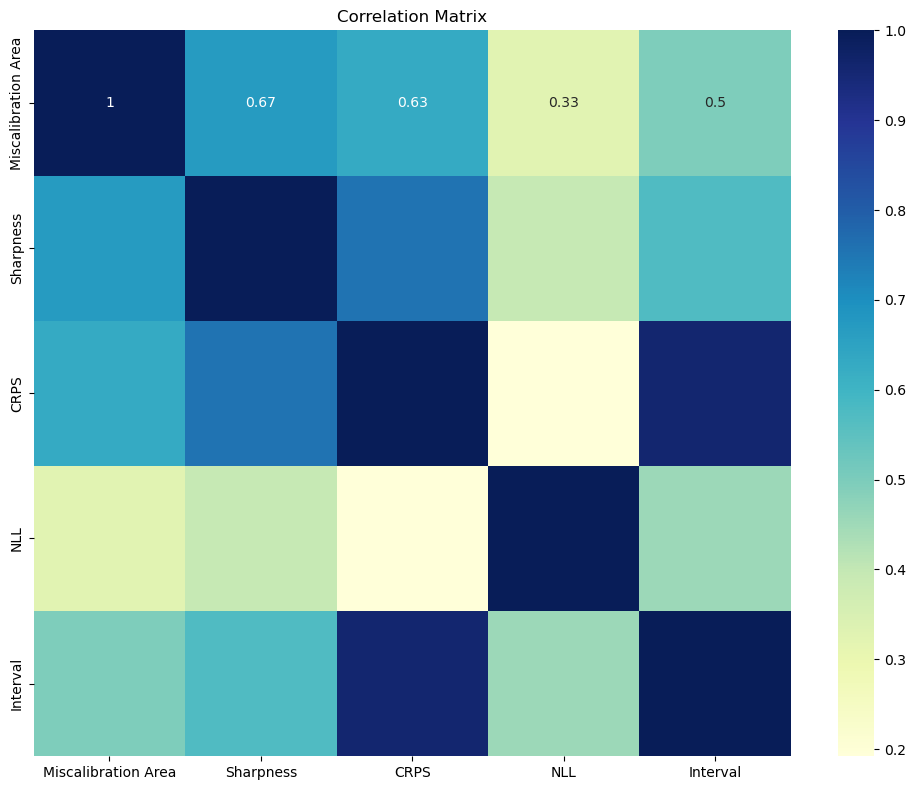

In [121]:
uctmetrics_uncorr = ['Miscalibration Area', 'Sharpness', 'CRPS', 'NLL', 'Interval']
highly_correlated_uctmetrics_uncorr = find_highly_correlated_metrics(df_pcm, uctmetrics_uncorr, threshold=0.9, save_dir=save_dir, cmap="YlGnBu")
highly_correlated_uctmetrics_uncorr_no_time = find_highly_correlated_metrics(df_no_time, uctmetrics_uncorr, threshold=0.9, save_dir=save_dir_no_time, cmap="YlGnBu")

In [122]:
# plot_pairplot(df, 'Pairplot for Highly Uncorrelated Uncertainty Metrics', uctmetrics_uncorr, save_dir=save_dir, cmap="Set2")

## Bar plots of metrics:
This includes the accuracy metrics and the uncertainty metrics
For all the metrics and also for the highly uncorrelated ones

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


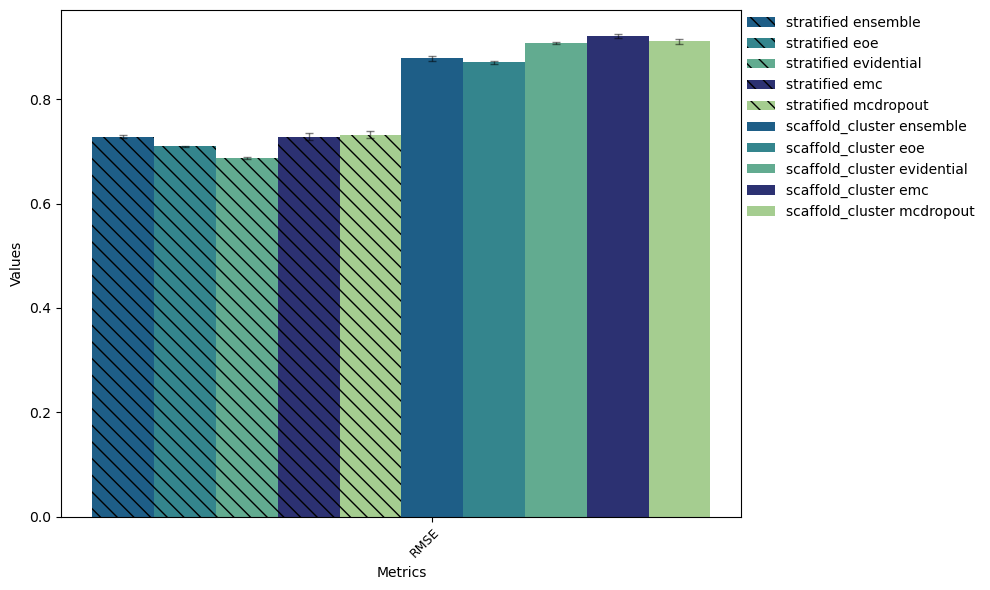

In [123]:
# plot_metrics(df_pcm, ["RMSE"], cmap="crest_r", save_dir=save_dir, hatches_dict=hatches_dict, group_order=group_order)
plot_metrics(df_no_time, ["RMSE"], cmap="crest_r", save_dir=save_dir_no_time, hatches_dict=hatches_dict_no_time, group_order=group_order_no_time)
# same angel / concentration of lines.
# 

/tmp/ipykernel_1531494/844704748.py:154: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1531494/844704748.py:154: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1531494/844704748.py:154: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ip

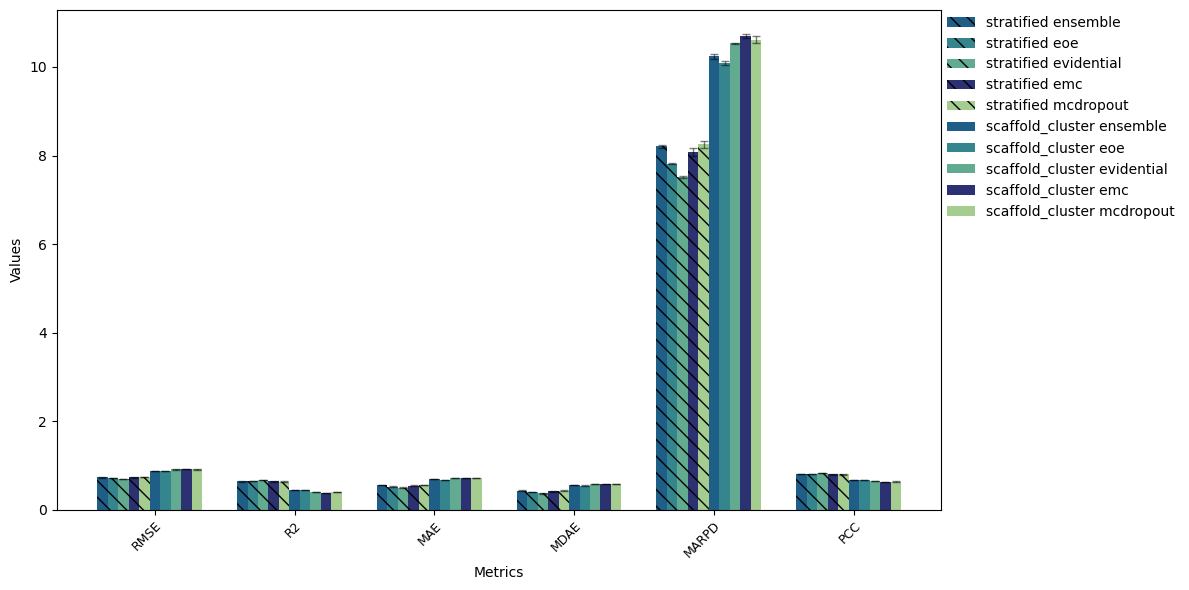

In [124]:
# plot_metrics(df_pcm, accmetrics, cmap="crest_r", save_dir=save_dir, hatches_dict=hatches_dict, group_order=group_order)
plot_metrics(df_no_time, accmetrics, cmap="crest_r", save_dir=save_dir_no_time, hatches_dict=hatches_dict_no_time, group_order=group_order_no_time)

/tmp/ipykernel_1531494/844704748.py:154: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1531494/844704748.py:154: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1531494/844704748.py:154: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

The Pos

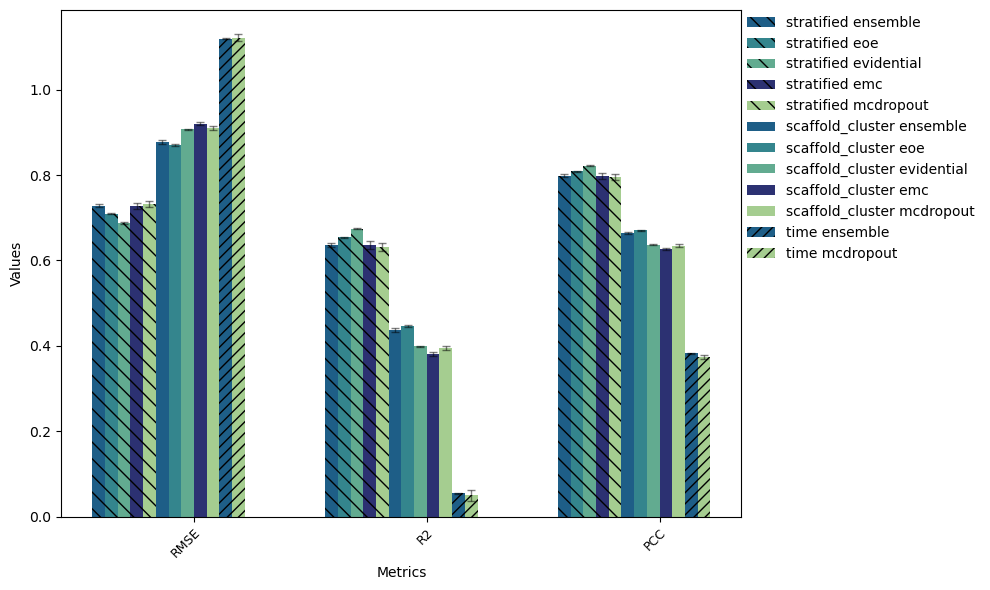

/tmp/ipykernel_1531494/844704748.py:154: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1531494/844704748.py:154: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1531494/844704748.py:154: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

The Pos

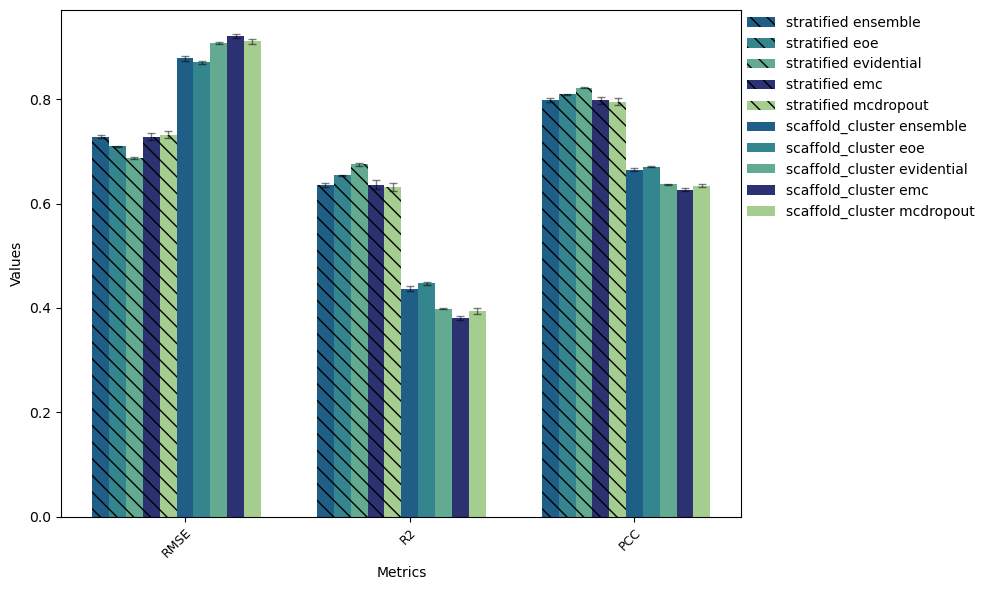

In [125]:
plot_metrics(df_pcm, accmetrics2, cmap="crest_r", save_dir=save_dir, hatches_dict=hatches_dict, group_order=group_order)
plot_metrics(df_no_time, accmetrics2, cmap="crest_r", save_dir=save_dir_no_time, hatches_dict=hatches_dict_no_time, group_order=group_order_no_time)

/tmp/ipykernel_1531494/844704748.py:154: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1531494/844704748.py:154: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1531494/844704748.py:154: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ip

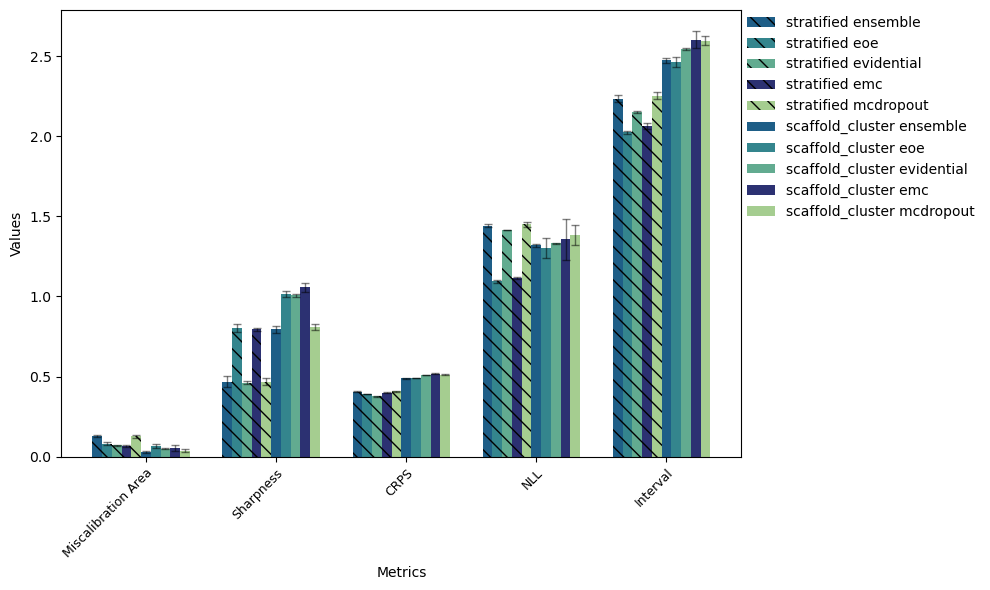

In [126]:
# plot_metrics(df_pcm, uctmetrics_uncorr, cmap="crest_r", save_dir=save_dir, hatches_dict=hatches_dict, group_order=group_order)
plot_metrics(df_no_time, uctmetrics_uncorr, cmap="crest_r", save_dir=save_dir_no_time, hatches_dict=hatches_dict_no_time, group_order=group_order_no_time)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


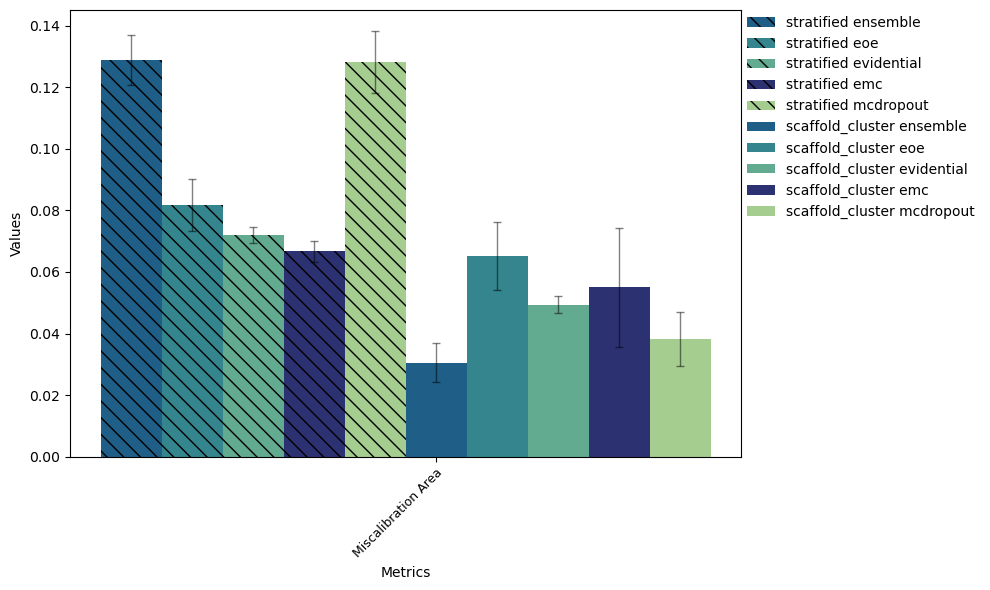

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


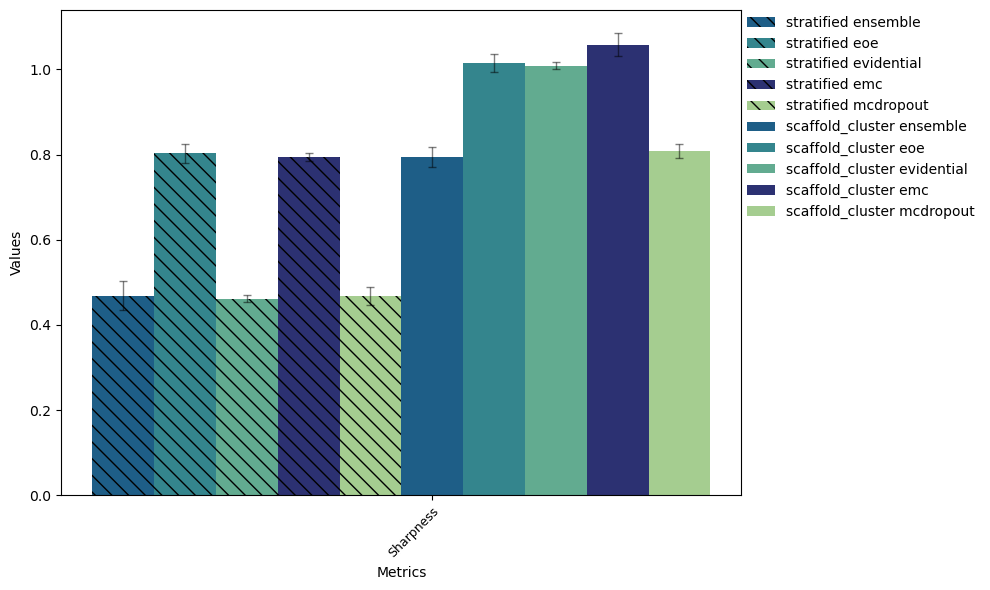

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


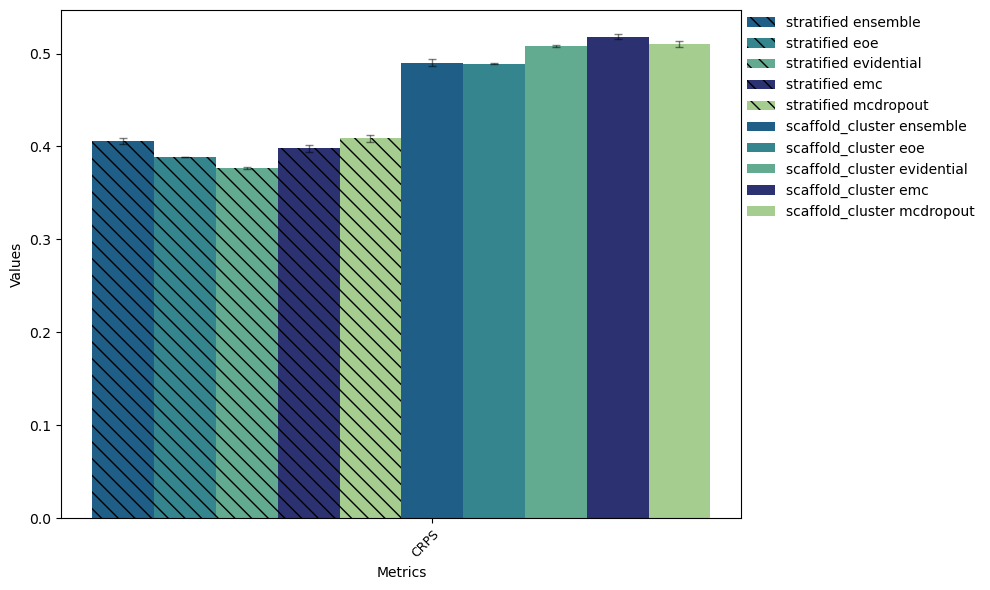

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


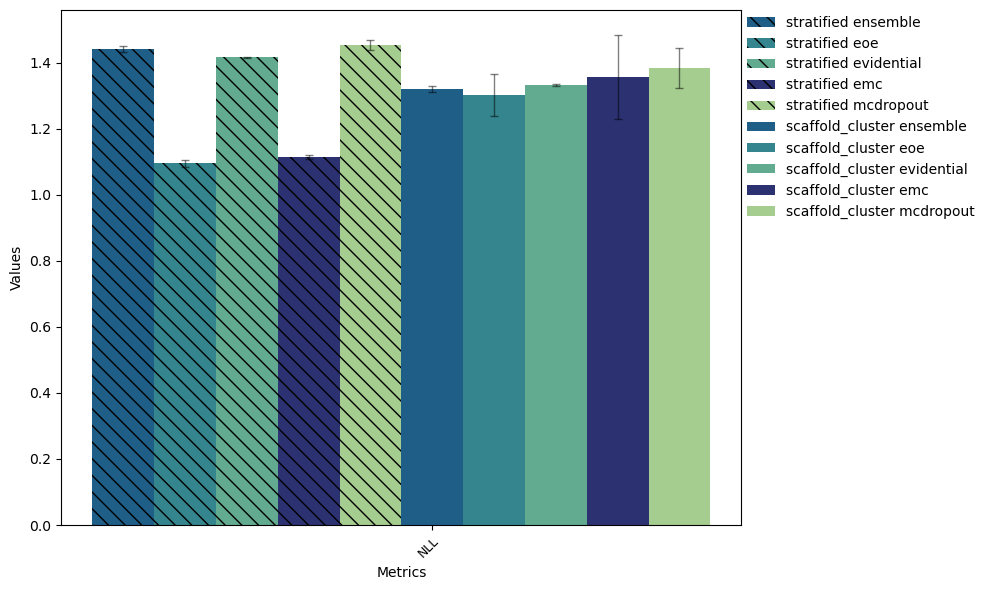

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


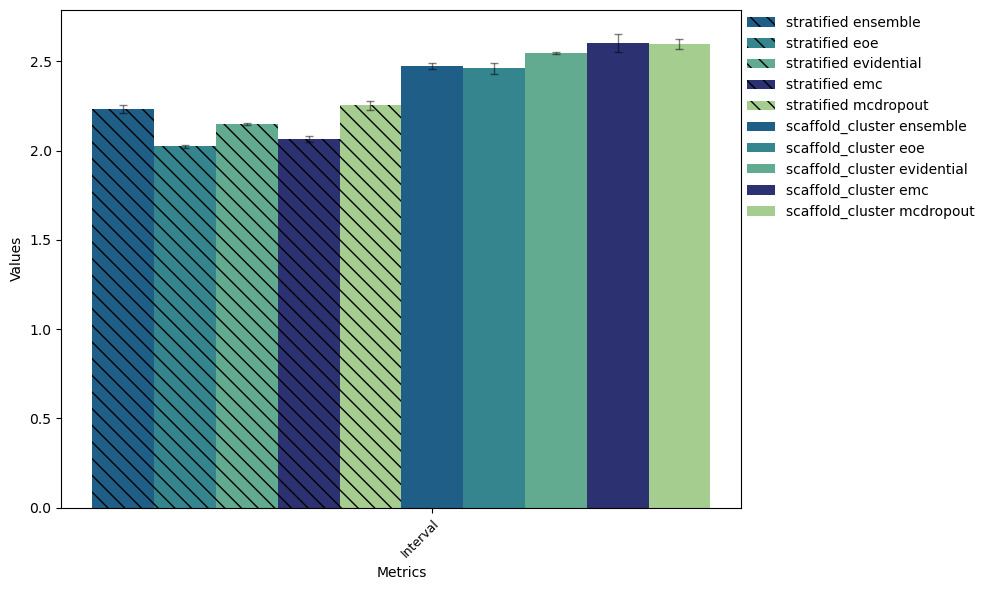

In [133]:
for m in uctmetrics_uncorr:
    # plot_metrics(df_pcm, [m], cmap="crest_r", save_dir=save_dir, hatches_dict=hatches_dict, group_order=group_order)
    plot_metrics(df_no_time, [m], cmap="crest_r", save_dir=save_dir_no_time, hatches_dict=hatches_dict_no_time, group_order=group_order_no_time)

In [128]:
# plot_metrics(df, accmetrics2, cmap="crest_r", save_dir=save_dir)

In [129]:
# plot_metrics(df_pcm, uctmetrics_uncorr, cmap="crest_r", save_dir=save_dir)

In [130]:
# plot_metrics(df_pcm[df_pcm['Split'] != 'stratified'], uctmetrics2, cmap="crest_r", save_dir=save_dir)

In [134]:
# plot_metrics(df_pcm[df_pcm['Split'] != 'stratified'], ["Miscalibration Area"], cmap="crest_r", save_dir=save_dir)
# plot_metrics(df_pcm[df_pcm['Split'] != 'stratified'], ["Miscalibration Area"], cmap="crest_r", save_dir=save_dir)


In [135]:
# plot_metrics(df_no_time, ["NLL"], cmap="crest_r", save_dir=save_dir_no_time)

In [136]:
# plot_metrics(df_pcm, ["Interval"], cmap="crest_r", save_dir=save_dir)

In [137]:
# plot_metrics(df_pcm, ["Miscalibration Area"], cmap="crest_r", save_dir=save_dir)

## Calibration comparisons

In [138]:
def plot_comparison_metrics(df, metrics, cmap="crest_r", save_dir=None):  #, draw_points_on_error_bars=False
    stats_dfs = []

    # Prepare data for each metric
    for metric in metrics:
        mean_df = (
            df.loc[:, ["Split", "Model type", "Calibration", metric]]
            .groupby(["Split", "Model type", "Calibration"])
            .mean()
            .rename(columns={metric: f"{metric}_mean"})
        )
        std_df = (
            df.loc[:, ["Split", "Model type", "Calibration", metric]]
            .groupby(["Split", "Model type", "Calibration"])
            .std()
            .rename(columns={metric: f"{metric}_std"})
        )
        stats_df = (
            pd.merge(mean_df, std_df, on=["Split", "Model type", "Calibration"])
            .sort_values(["Split", "Model type", "Calibration"])
            .reset_index()
            .assign(Group=lambda df: df.apply(lambda row: f"{row['Split']}_{row['Model type']}_{row['Calibration']}", axis=1))
        )
        stats_df['Metric'] = metric
        stats_dfs.append(stats_df)

    combined_stats_df = pd.concat(stats_dfs)

    scalar_mappable = ScalarMappable(cmap=cmap)
    model_types = combined_stats_df["Model type"].unique()
    color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}

    hatches_dict = {
        "Before Calibration": "\\\\",
        "After Calibration": "",
    }
    
    # Calculate appropriate figsize based on the number of metrics
    fig_width = max(7, len(metrics) * 3)
    fig, ax = plt.subplots(figsize=(fig_width, 6))
    
    bar_width = 0.1
    group_spacing = 0.2  # Adjusted for closer split groups
    split_spacing = 0.6
    num_bars = len(model_types) * 2  # 2 calibration statuses (Before and After)
    positions = []
    tick_positions = []
    tick_labels = []

    for i, metric in enumerate(metrics):
        metric_data = combined_stats_df[combined_stats_df['Metric'] == metric]
        split_types = metric_data["Split"].unique()
        for j, split in enumerate(split_types):
            split_data = metric_data[metric_data["Split"] == split]
            for k, model_type in enumerate(model_types):
                for l, calibration in enumerate(["Before Calibration", "After Calibration"]):
                    position = (i * (split_spacing + len(split_types) * (num_bars * bar_width + group_spacing)) + 
                                j * (num_bars * bar_width + group_spacing) + 
                                k * 2 * bar_width + l * bar_width)
                    positions.append(position)
                    height = split_data[(split_data["Model type"] == model_type) & (split_data["Calibration"] == calibration)][f"{metric}_mean"].values[0]
                    ax.bar(
                        position,
                        height=height, 
                        color=color_dict[model_type],
                        hatch=hatches_dict[calibration],
                        width=bar_width,
                    )
                    # # Draw point on the error bar
                    # if draw_points_on_error_bars:
                    #     ax.plot(position, height, 'o', color='black')
            # Add tick positions and labels for each split within each metric
            center_position = (i * (split_spacing + len(split_types) * (num_bars * bar_width + group_spacing)) + 
                               j * (num_bars * bar_width + group_spacing) + 
                               (num_bars * bar_width) / 2)
            tick_positions.append(center_position)
            tick_labels.append(f"{metric}\n{split}")

    def create_stats_legend(color_dict, hatches_dict):
        patches = []
        for label, color in color_dict.items():
            patches.append(mpatches.Patch(facecolor=color, edgecolor='black', label=label))
        for label, hatch in hatches_dict.items():
            patches.append(mpatches.Patch(facecolor='white', edgecolor='black', hatch=hatch, label=label))
        return patches

    legend_elements = create_stats_legend(color_dict, hatches_dict)

    ax.legend(
        handles=legend_elements,
        bbox_to_anchor=(1.0, 1.0),
        loc="upper left",
        borderaxespad=0,
        frameon=False,
    )

    for (_, row), bar in zip(combined_stats_df.iterrows(), ax.patches):
        x_bar = bar.get_x() + bar.get_width() / 2
        y_bar = bar.get_height()
        # print(row[f"{row['Metric']}_std"])
        yerr_lower = y_bar - max(0, y_bar - row[f"{row['Metric']}_std"])
        yerr_upper = row[f"{row['Metric']}_std"]
        ax.errorbar(
            x_bar,
            y_bar,
            # yerr=row[f"{row['Metric']}_std"],
            yerr=[[yerr_lower], [yerr_upper]], 
            color="black",
            # fmt='o' if draw_points_on_error_bars else 'none',  # Option to draw points on error bars
            fmt="none",  # Option to draw points on error bars
            elinewidth=1,
            capsize=3,
            alpha=0.5,
            
        )

    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor", fontsize=9)
    ax.set_xlabel("Metrics and Splits")
    ax.set_ylabel("Values")
    metrics_names = "_".join(metrics)
    plot_name = f"comparison_barplot_{cmap}_{metrics_names}"
    # plot_name += "_points" if draw_points_on_error_bars else ""
    save_plot(fig, save_dir, plot_name)
    plt.show()
    plt.close()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


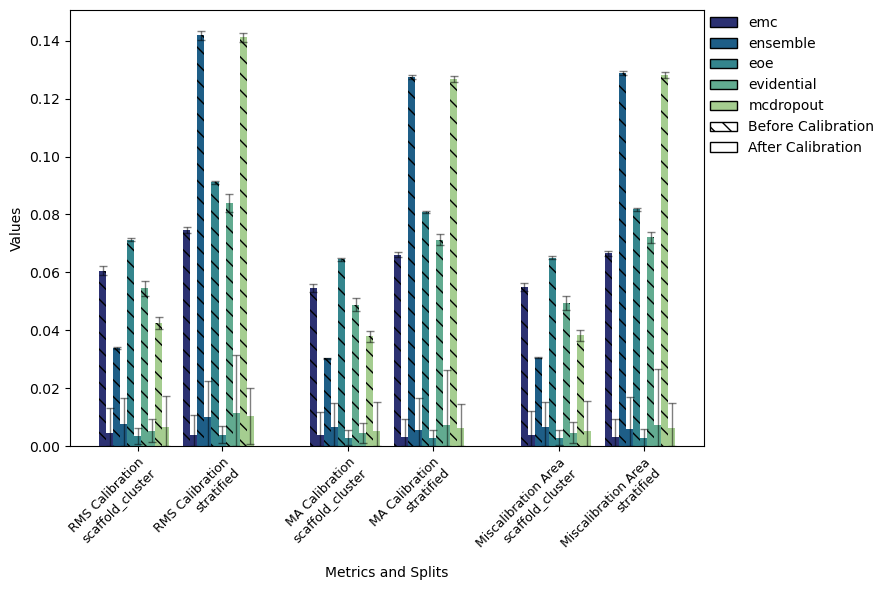

In [139]:
# plot_comparison_metrics(df_calib, ['RMS Calibration', 'MA Calibration', 'Miscalibration Area'], cmap="crest_r", save_dir=save_dir)
plot_comparison_metrics(df_calib_no_time, ['RMS Calibration', 'MA Calibration', 'Miscalibration Area'], cmap="crest_r", save_dir=save_dir_no_time)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


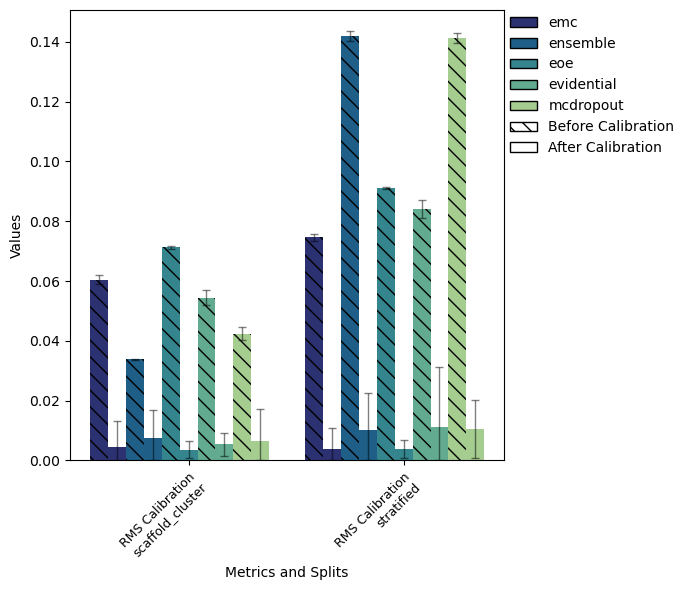

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


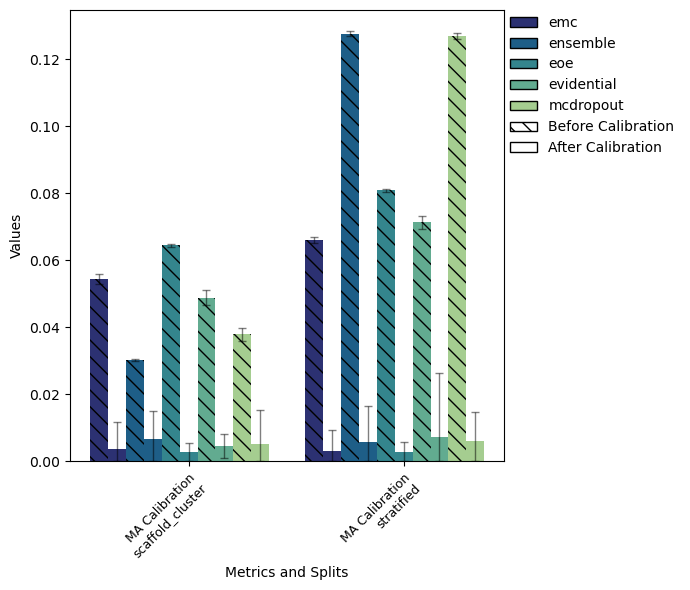

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


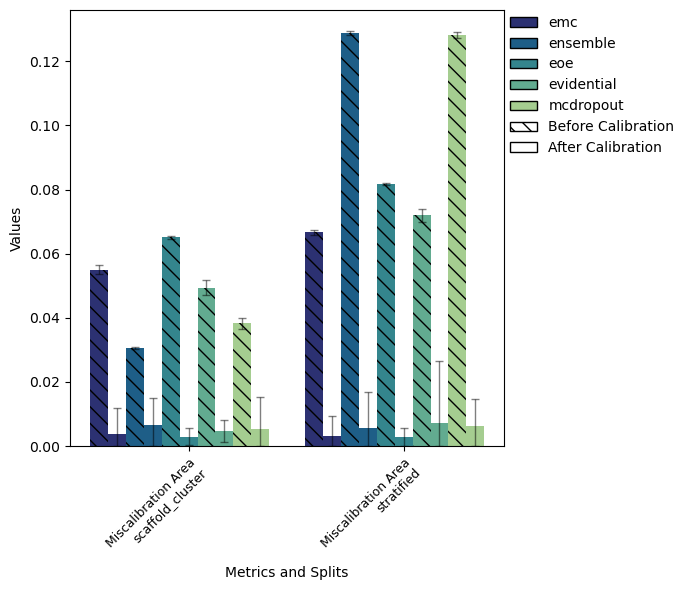

In [142]:
for x in ["RMS Calibration", "MA Calibration", "Miscalibration Area"]:
    plot_comparison_metrics(df_calib_no_time, [x], cmap="crest_r", save_dir=save_dir_no_time)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


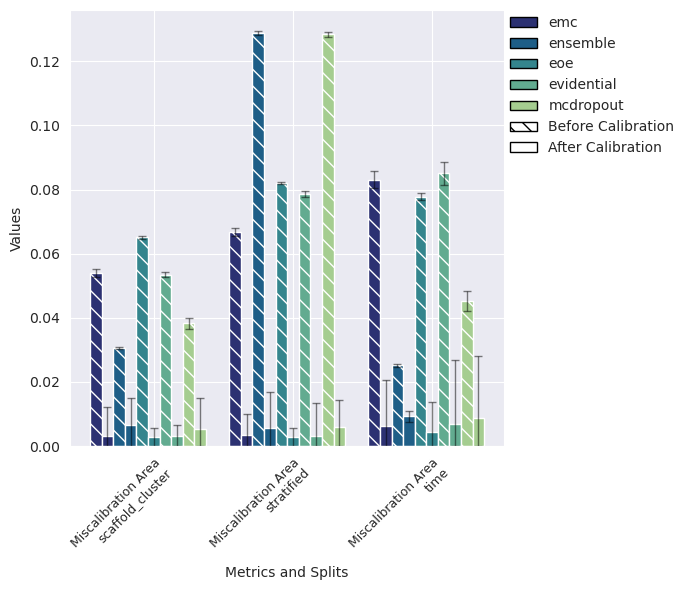

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


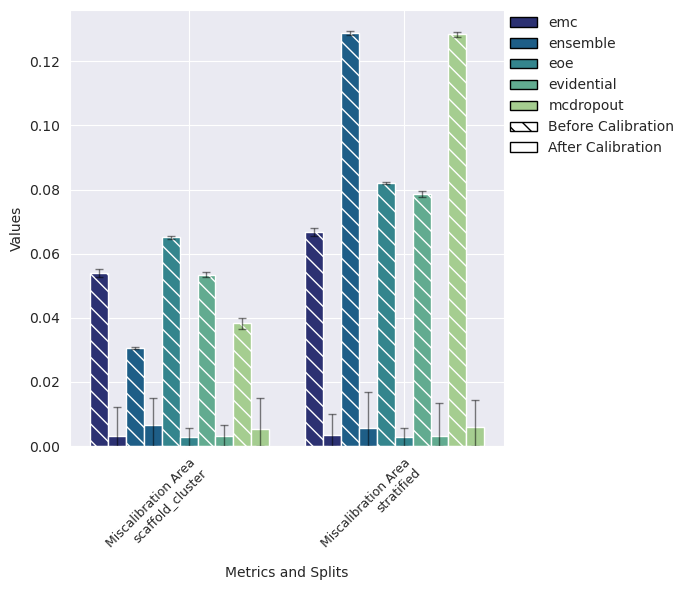

In [40]:
plot_comparison_metrics(df_calib, ['Miscalibration Area'], cmap="crest_r", save_dir=save_dir)
plot_comparison_metrics(df_calib_no_time, ['Miscalibration Area'], cmap="crest_r", save_dir=save_dir_no_time)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


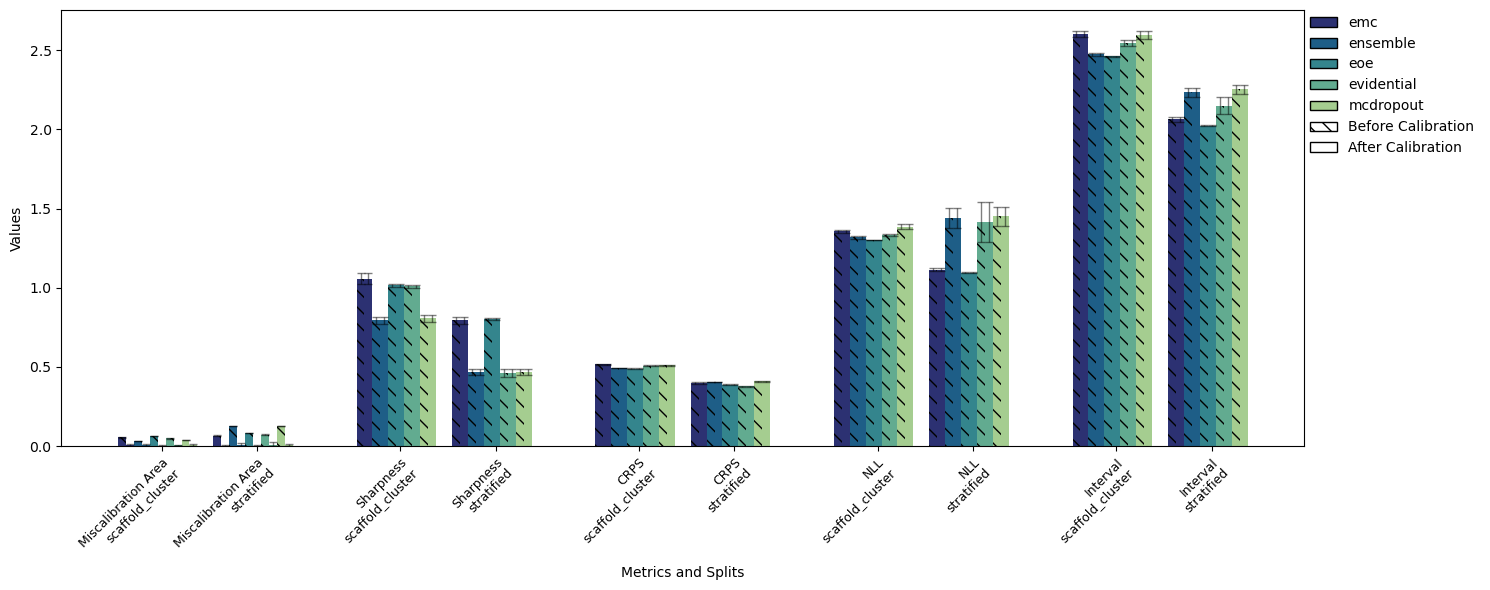

In [143]:
# plot_comparison_metrics(df_calib, uctmetrics_uncorr, cmap="crest_r", save_dir=save_dir)
plot_comparison_metrics(df_calib_no_time, uctmetrics_uncorr, cmap="crest_r", save_dir=save_dir_no_time, )

In [144]:
# df_calib.head(100)

In [146]:
df_no_time.head()

Model type Task Activity             Split   desc_prot desc_chem  dropout  \
6    ensemble  PCM     xc50  scaffold_cluster  ankh-large  ecfp2048      0.2   
12   ensemble  PCM     xc50        stratified  ankh-large  ecfp2048      0.1   
18  mcdropout  PCM     xc50  scaffold_cluster  ankh-large  ecfp2048      0.2   
30   ensemble  PCM     xc50  scaffold_cluster  ankh-large  ecfp2048      0.2   
36   ensemble  PCM     xc50  scaffold_cluster  ankh-large  ecfp2048      0.2   

          R2      RMSE       MAE  ...  rmv_rmse_slope  rmv_rmse_r_sq  \
6   0.437744  0.877445  0.684918  ...        0.425579       0.562917   
12  0.626951  0.736910  0.558098  ...        0.998964       0.879338   
18  0.399100  0.907097  0.708213  ...        0.364747       0.580369   
30  0.437580  0.877573  0.685238  ...        0.431413       0.569994   
36  0.437250  0.877830  0.685016  ...        0.418217       0.566448   

    rmv_rmse_intercept  aleatoric_uct_mean  epistemic_uct_mean  \
6             0.544932            0.766696            0.226535   
12            0.213471            0.503729            0.140191   
18            0.615129            0.786373            0.653707   
30            0.540777            0.766310            0.227445   
36            0.550652            0.768537            0.226540   

    total_uct_mean                     wandb project              wandb run  \
6         0.993232  reassess-runs_ensemble_mcdp_xc50        cosmic-field-83   
12        0.643921  reassess-runs_ensemble_mcdp_xc50           clear-wood-4   
18        1.440080  reassess-runs_ensemble_mcdp_xc50      legendary-dust-51   
30        0.993756  reassess-runs_ensemble_mcdp_xc50  cerulean-resonance-23   
36        0.995077  reassess-runs_ensemble_mcdp_xc50          leafy-wood-84   

                                           model name  \
6   20240626-papyrus_xc50_ensemble_scaffold_cluste...   
12  20240625-papyrus_xc50_ensemble_random_ankh-lar...   
18  20240625-papyrus_xc50_mcdropout_scaffold_clust...   
30  20240625-papyrus_xc50_ensemble_scaffold_cluste...   
36  20240627-papyrus_xc50_ensemble_scaffold_cluste...   

                         Group  
6    scaffold_cluster_ensemble  
12         stratified_ensemble  
18  scaffold_cluster_mcdropout  
30   scaffold_cluster_ensemble  
36   scaffold_cluster_ensemble  

[5 rows x 44 columns]

In [ ]:
base_path = "/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all"
'Model type' 'Split'

In [202]:
# TESTING
base_path = "/users/home/bkhalil/Repos/uqdd/uqdd/figures/"

test_paths = final_aggregated.loc[0, 'project_model']

test_path_0 = os.path.join(base_path, test_paths[0], 'calibration_plot_data.csv')
test_path_1 = os.path.join(base_path, test_paths[1], 'calibration_plot_data.csv')

print(test_path_0, test_path_1)

# if os.path.exists(test_path_0):
data_0 = pd.read_csv(test_path_0)

# if os.path.exists(test_path_1):
data_1 = pd.read_csv(test_path_1)
observed_values = []
expected_values = data_0['Expected Proportion']

observed_values.append(data_0['Observed Proportion'])
observed_values.append(data_1['Observed Proportion'])

expected_values = np.array(expected_values)
observed_values = np.array(observed_values)
mean_observed = np.mean(observed_values, axis=0)

lower_bound = np.min(observed_values, axis=0)
upper_bound = np.max(observed_values, axis=0)


/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-runs_evidential_xc50/20241127-papyrus_xc50_emc_scaffold_cluster_ankh-large_ecfp2048_47_rose-sky-89/calibration_plot_data.csv /users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-runs_evidential_xc50/20241127-papyrus_xc50_emc_scaffold_cluster_ankh-large_ecfp2048_42_dulcet-totem-85/calibration_plot_data.csv


In [205]:
upper_bound.shape

(100,)

In [206]:
# def save_plot(fig, save_dir, plot_name, tighten=True)
def load_and_aggregate_calibration_data(base_path, paths):
    """
    Loads calibration data for multiple paths, computes mean and bounds for observed proportions.
    """
    expected_values = []
    observed_values = []
    
    for path in paths:
        file_path = os.path.join(base_path, path, 'calibration_plot_data.csv')
        if os.path.exists(file_path):
            data = pd.read_csv(file_path)
            expected_values = data['Expected Proportion']
            # expected_values.append(data['Expected Proportion'])
            observed_values.append(data['Observed Proportion'])
        else:
            print(f"File not found: {file_path}")

    # Convert lists to numpy arrays for aggregation
    expected_values = np.array(expected_values)
    observed_values = np.array(observed_values)

    # Aggregate mean, min, and max for shading
    # mean_expected = np.mean(expected_values, 
    # mean_expected = np.mean(expected_values, axis=0)
    mean_observed = np.mean(observed_values, axis=0)
    lower_bound = np.min(observed_values, axis=0)
    upper_bound = np.max(observed_values, axis=0)

    return expected_values, mean_observed, lower_bound, upper_bound

In [218]:
def plot_calibration_data(df_aggregated, base_path, save_dir=None, title="Calibration Plot"):
    """
    Iterates over models in df_aggregated, loads and plots calibration data.
    """
    plt.figure(figsize=(12, 8))
    
    # color_map = plt.cm.get_cmap('tab10', len(df_aggregated))  # Generate unique colors

    for idx, row in df_aggregated.iterrows():
        model_paths = row['project_model']
        group_label = row['Group']
        # color = color_map(idx)  # Assign a color to each group

        # Load and aggregate calibration data
        expected, mean_observed, lower_bound, upper_bound = load_and_aggregate_calibration_data(base_path, model_paths)

        # Plot the mean line
        plt.plot(expected, mean_observed, label=group_label) # , color=color
        
        # Fill the shaded area
        plt.fill_between(expected, lower_bound, upper_bound,  alpha=0.2) # color=color,

    # Perfect calibration line
    plt.plot([0, 1], [0, 1], 'k--', label="Perfect Calibration")

    # Plot settings
    plt.title(title)
    plt.xlabel("Expected Proportion")
    plt.ylabel("Observed Proportion")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    
    if save_dir:
        plot_name = row['Activity'] + f"{title.replace(' ', '_')}.png"
        save_plot(plt.gcf(), save_dir, plot_name, tighten=True)
        
        # os.makedirs(save_dir, exist_ok=True)
        # plt.savefig(os.path.join(save_dir, f"{title.replace(' ', '_')}.png"), dpi=300, bbox_inches='tight')
    
    plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


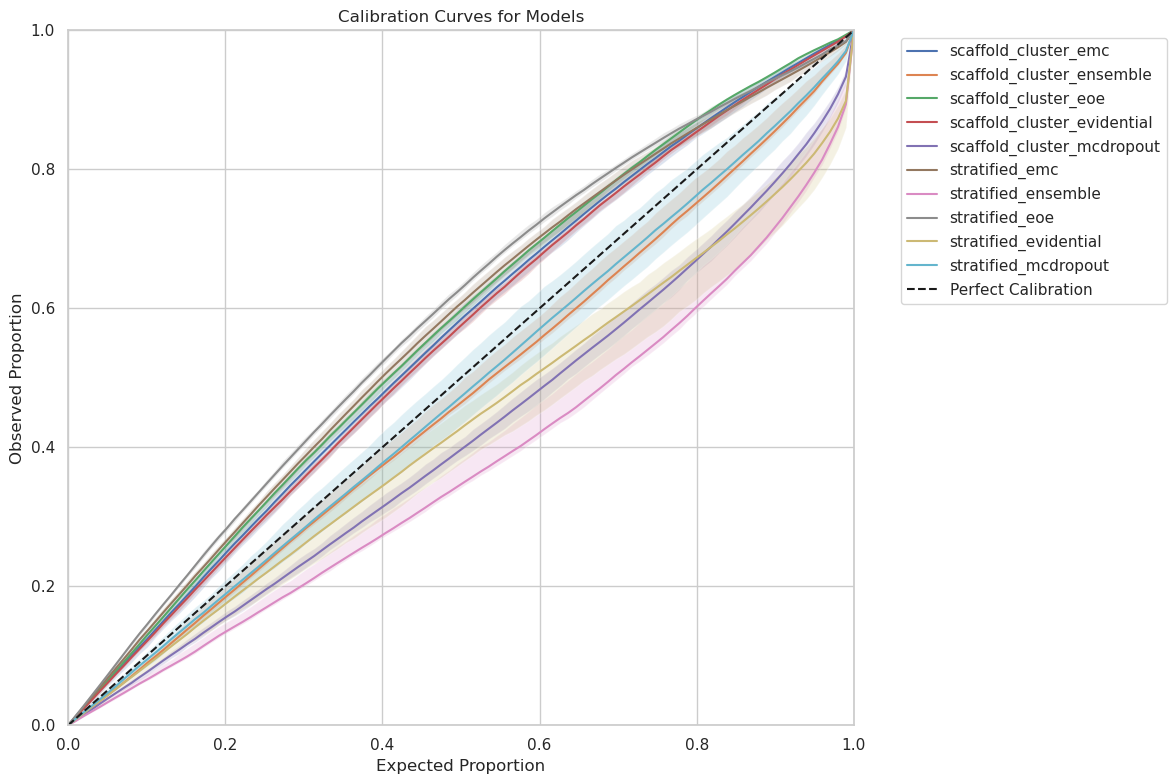

In [219]:
base_path = "/users/home/bkhalil/Repos/uqdd/uqdd/figures/"
# plot_calibration_data(df_aggregated, base_path, save_dir, title="Calibration Curves for Models")
plot_calibration_data(final_aggregated_no_time, base_path, save_dir_no_time, title="Calibration Curves for Models")

In [152]:
# # plot Mis-calibration in one plot
# # 1. we find the path(s) where the models-folders to be included in the plot are.

# # 2. note that the subfolder names should be provided through /{wandb project}/{model name}/ column values per each entry
# # so each model folder path will be {path from 1.}/{wandb project}/{model name}/

# # 3. inside each of those folders there is a file called "calibration_plot_data.csv" 
# # with two columns 'Expected Proportion' and 'Observed Proportion' we want to accumulate 
# # each of the models (with the reproducible runs as area range in the plot) together in one figure 
# # of expected proportions against observed proportions


# # Function to load calibration data from given paths
# def load_calibration_data(base_path, wandb_projects, model_names):
#     calibration_data = []

#     for project, model in zip(wandb_projects, model_names):
#         model_path = os.path.join(base_path, project, model, "calibration_plot_data.csv")
#         if os.path.exists(model_path):
#             model_df = pd.read_csv(model_path)
#             model_df["Model"] = model
#             model_df["Project"] = project
#             calibration_data.append(model_df)
#         else:
#             print(f"File not found: {model_path}")

#     if calibration_data:
#         return pd.concat(calibration_data, ignore_index=True)
#     else:
#         raise FileNotFoundError(f"No calibration data found for the provided paths: {model_path}")


# # Function to plot calibration curves with areas covering reproducible runs
# def plot_calibration_curves(calibration_data, save_dir=None):
#     sns.set(style="whitegrid")

#     # Group data by model to calculate mean and range for reproducible runs
#     grouped = calibration_data.groupby(["Model", "Expected Proportion"])
#     mean_df = grouped["Observed Proportion"].mean().reset_index()
#     std_df = grouped["Observed Proportion"].std().reset_index()

#     # Merge mean and std dataframes
#     merged_df = mean_df.merge(std_df, on=["Model", "Expected Proportion"], suffixes=("_mean", "_std"))

#     # Plotting
#     plt.figure(figsize=(10, 8))

#     for model in merged_df["Model"].unique():
#         model_data = merged_df[merged_df["Model"] == model]
#         plt.plot(
#             model_data["Expected Proportion"],
#             model_data["Observed Proportion_mean"],
#             label=model
#         )
#         plt.fill_between(
#             model_data["Expected Proportion"],
#             model_data["Observed Proportion_mean"] - model_data["Observed Proportion_std"],
#             model_data["Observed Proportion_mean"] + model_data["Observed Proportion_std"],
#             alpha=0.2
#         )

#     plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Ideal Calibration")
#     plt.xlabel("Expected Proportion")
#     plt.ylabel("Observed Proportion")
#     plt.title("Calibration Curves")
#     plt.legend(title="Models")

#     # Save the plot if save_dir is provided
#     if save_dir:
#         os.makedirs(save_dir, exist_ok=True)
#         plt.savefig(os.path.join(save_dir, "calibration_curves.png"), dpi=300)
#         plt.savefig(os.path.join(save_dir, "calibration_curves.svg"))
#         plt.savefig(os.path.join(save_dir, "calibration_curves.pdf"))

#     plt.show()

In [220]:
# # Example usage
# base_path = "/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all"
# wandb_projects = df_main["wandb project"].unique()
# model_names = df_main["model name"].unique()
# calibration_data = load_calibration_data(base_path, wandb_projects, model_names)
# # plot_calibration_curves(calibration_data, save_dir=None)

In [221]:
# wandb_projects

## Get The figures models folders in one place 

In [63]:
import os
import shutil
import pandas as pd

def move_model_folders(df, search_dirs, output_dir, overwrite=False):
    """
    Moves folders matching the unique 'model name' entries from df to output_dir.

    Parameters:
    df (pd.DataFrame): DataFrame containing a 'model name' column.
    search_dirs (list): List of directories to search for model folders.
    output_dir (str): Destination directory to move the model folders to.
    """
    # Get unique list of model names
    model_names = df['model name'].unique()

    # Ensure output_dir exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
        print(f"Created output directory '{output_dir}'.")

    # Iterate over each model name
    for model_name in model_names:
        found = False
        for search_dir in search_dirs:
            # Check if the search directory exists
            if not os.path.isdir(search_dir):
                print(f"Search directory '{search_dir}' does not exist. Skipping.")
                continue

            # Get list of immediate subdirectories in search_dir
            subdirs = [d for d in os.listdir(search_dir)
                       if os.path.isdir(os.path.join(search_dir, d))]

            if model_name in subdirs:
                source_dir = os.path.join(search_dir, model_name)
                dest_dir = os.path.join(output_dir, model_name)

                # Check if destination folder already exists
                if os.path.exists(dest_dir):
                    if overwrite:
                        shutil.copytree(source_dir, dest_dir, dirs_exist_ok=True)
                        print(f"Merged (Copied) '{source_dir}' to '{dest_dir}'.")
                    # print(f"Destination folder '{dest_dir}' already exists. Skipping move for '{model_name}'.")
                else:
                    try:
                        shutil.move(source_dir, dest_dir)
                        print(f"Moved '{source_dir}' to '{dest_dir}'.")
                    except Exception as e:
                        print(f"Error moving '{source_dir}' to '{dest_dir}': {e}")
                found = True
                break  # No need to continue searching other directories
        if not found:
            print(f"Model folder '{model_name}' not found in any of the search directories.")


In [18]:
search_dirs = [
    f"/home/bkhalil/Repos/uqdd/uqdd/figures/{data_specific_path}/reassess-2024-06-25-all-models-100/",
    "/projects/system/bkhalil/BACKUPS_DO_NOT_DELETE/uqdd/figures/papyrus/xc50/all/backup-2024-08-28/reassess-2024-06-25-all-models-100",
    f"/projects/system/bkhalil/BACKUPS_DO_NOT_DELETE/uqdd/figures/{data_specific_path}/",
    f"/home/bkhalil/Repos/uqdd/uqdd/figures/{data_specific_path}/",
]

output_dir = f"/projects/system/bkhalil/BACKUPS_DO_NOT_DELETE/uqdd/figures/{data_specific_path}/2024-09-19/"

In [65]:
move_model_folders(df_pcm, search_dirs, output_dir, overwrite=True)

Merged (Copied) '/projects/system/bkhalil/BACKUPS_DO_NOT_DELETE/uqdd/figures/papyrus/xc50/all/backup-2024-08-28/reassess-2024-06-25-all-models-100/20240625-papyrus_xc50_ensemble_random_ankh-large_ecfp2048_peach-wave-9' to '/projects/system/bkhalil/BACKUPS_DO_NOT_DELETE/uqdd/figures/papyrus/xc50/all/2024-09-19/20240625-papyrus_xc50_ensemble_random_ankh-large_ecfp2048_peach-wave-9'.
Merged (Copied) '/projects/system/bkhalil/BACKUPS_DO_NOT_DELETE/uqdd/figures/papyrus/xc50/all/backup-2024-08-28/reassess-2024-06-25-all-models-100/20240625-papyrus_xc50_ensemble_random_ankh-large_ecfp2048_exalted-gorge-1' to '/projects/system/bkhalil/BACKUPS_DO_NOT_DELETE/uqdd/figures/papyrus/xc50/all/2024-09-19/20240625-papyrus_xc50_ensemble_random_ankh-large_ecfp2048_exalted-gorge-1'.
Merged (Copied) '/projects/system/bkhalil/BACKUPS_DO_NOT_DELETE/uqdd/figures/papyrus/xc50/all/backup-2024-08-28/reassess-2024-06-25-all-models-100/20240625-papyrus_xc50_ensemble_random_ankh-large_ecfp2048_clear-wood-4' to '/pr

In [225]:
preds_dir = output_dir

NameError: name 'output_dir' is not defined

## Accuracy Rejection Curves

In [222]:
save_dir

'/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/2025-01-08-xc50-all/'

In [223]:
def load_predictions(preds_dir, model_name):
    preds_path = os.path.join(preds_dir, model_name, 'preds.pkl')
    return pd.read_pickle(preds_path)

def load_predictions_csv(preds_dir, model_name):
    preds_path = os.path.join(preds_dir, f'{model_name}_preds.csv')
    return pd.read_csv(preds_path)

In [224]:
mname = df_pcm.iloc[0]['model name']
preds_dir = 
print(mname)
preds = load_predictions(preds_dir, mname)
# 
# preds_dirpath = f'/users/home/bkhalil/Repos/uqdd/uqdd/data/predictions/{data_specific_path}/'
# preds = load_predictions_csv(preds_dirpath, mname)


20240813-papyrus_xc50_ensemble_time_ankh-large_ecfp2048_legendary-dust-112


NameError: name 'preds_dir' is not defined

In [21]:
preds.head(20)

y_true    y_pred     y_eps     y_err    y_alea
0    9.602  8.631614  0.443187 -0.970387  0.089804
1    5.223  6.125329  0.519805  0.902329  0.128243
2    7.208  7.078175  0.509354 -0.129826  0.099604
3    5.328  5.193082  0.594200 -0.134918  0.103755
4    6.730  6.645977  0.446056 -0.084023  0.128279
5    4.252  6.890951  0.666732  2.638951  0.104010
6    4.427  5.522217  0.602706  1.095217  0.090695
7    7.679  7.437817  0.450852 -0.241183  0.084123
8    5.540  5.652126  0.413029  0.112126  0.092338
9    8.523  7.651332  0.344947 -0.871668  0.128786
10   5.570  6.453177  0.331443  0.883177  0.086534
11   5.459  5.769083  0.293349  0.310082  0.091527
12   7.873  7.669521  0.314729 -0.203479  0.078862
13   5.397  5.895999  0.310567  0.498999  0.089658
14   7.310  6.571570  0.300242 -0.738430  0.067067
15   9.398  8.391245  0.448985 -1.006755  0.086573
16   5.565  5.635784  0.279313  0.070784  0.082536
17   6.084  6.181383  0.269491  0.097383  0.089612
18   5.513  5.379089  0.229109 -0.133911  0.094442
19   5.823  6.747068  0.454796  0.924068  0.138505

In [31]:
preds['uct'] = preds['y_alea'] + preds['y_eps']
# order by uct
preds = preds.sort_values(by='y_alea', ascending=False)
preds.head(20)

y_true    y_pred     y_eps     y_err    y_alea       uct
8542   6.510000  6.816971  0.676765  0.306971  0.191560  0.868325
5795   8.241000  7.290480  0.553485 -0.950520  0.181176  0.734660
52     8.225000  6.507779  0.440379 -1.717221  0.177931  0.618310
8705   6.830000  8.110103  0.697449  1.280103  0.175808  0.873256
8690   5.050000  6.680673  0.737642  1.630672  0.173300  0.910942
2316   5.215900  6.310690  0.642013  1.094790  0.171178  0.813191
8622   6.540000  6.860332  0.550517  0.320332  0.169985  0.720502
8810   5.680000  5.900983  0.582297  0.220983  0.169685  0.751982
8761   8.741667  7.392044  0.680010 -1.349623  0.168231  0.848241
8683   6.120000  6.818934  0.557028  0.698935  0.168004  0.725032
8715   6.960000  7.659008  0.554976  0.699008  0.167886  0.722862
344    9.174167  8.068413  0.934475 -1.105754  0.167274  1.101749
9827   8.455000  8.533862  0.411450  0.078862  0.166866  0.578316
8747   6.820000  7.339355  0.621068  0.519355  0.166497  0.787565
11668  6.787500  7.124194  0.266896  0.336694  0.166219  0.433115
8725   6.440000  7.175055  0.576938  0.735055  0.166190  0.743128
2602   6.480500  6.842043  0.585013  0.361543  0.166158  0.751171
9062   6.640000  9.649174  0.880380  3.009174  0.165584  1.045964
8512   6.960000  7.084765  0.568222  0.124765  0.164607  0.732829
8637   6.650000  7.220926  0.523732  0.570926  0.163559  0.687291

In [32]:
preds_uct = preds.sort_values(by='uct', ascending=False)
preds_uct.head(20)

y_true    y_pred     y_eps     y_err    y_alea       uct
12647   6.900  6.646077  1.790145 -0.253923  0.094498  1.884643
12654   5.385  6.314880  1.766870  0.929880  0.108421  1.875291
12649   6.570  6.272648  1.769586 -0.297352  0.097640  1.867226
12653  11.000  9.313318  1.594842 -1.686682  0.133687  1.728529
12656  11.000  9.309278  1.584437 -1.690722  0.114505  1.698942
12646  11.000  9.317883  1.542192 -1.682117  0.098353  1.640545
12648  11.000  9.595449  1.506763 -1.404551  0.117066  1.623829
12650  11.000  9.263803  1.487508 -1.736197  0.115654  1.603162
12652   7.000  9.935590  1.435737  2.935590  0.110253  1.545990
12655  11.000  9.321902  1.421044 -1.678098  0.107618  1.528662
12651  11.000  9.421525  1.387439 -1.578475  0.132919  1.520358
12614   9.395  7.235258  1.390887 -2.159742  0.124215  1.515102
12627   5.715  6.666726  1.397759  0.951726  0.081816  1.479576
12628   8.035  6.360199  1.383723 -1.674801  0.078593  1.462316
12607   6.060  6.515577  1.359784  0.455577  0.083694  1.443478
10916   9.210  9.216903  1.317138  0.006903  0.117294  1.434433
12622   8.315  6.626168  1.333987 -1.688831  0.082282  1.416270
12608   6.510  5.808683  1.334358 -0.701317  0.077527  1.411885
12629   5.200  5.387891  1.320926  0.187891  0.089656  1.410581
12529  10.685  8.862783  1.293151 -1.822217  0.107129  1.400280

In [33]:
preds_uct.to_csv(f'/users/home/bkhalil/Repos/uqdd/uqdd/preds_uct.csv', index=False)

In [236]:
df_pcm.columns

Index(['index', 'Model type', 'Task', 'Activity', 'Split', 'desc_prot',
       'desc_chem', 'dropout', 'R2', 'RMSE', 'MAE', 'MDAE', 'MARPD', 'PCC',
       'RMS Calibration', 'MA Calibration', 'Miscalibration Area', 'Sharpness',
       'NLL', 'CRPS', 'Check', 'Interval', 'rho_rank', 'rho_rank_sim',
       'rho_rank_sim_std', 'uq_mis_cal', 'uq_NLL', 'uq_NLL_sim',
       'uq_NLL_sim_std', 'Z_var', 'Z_var_CI_low', 'Z_var_CI_high', 'Z_mean',
       'Z_mean_CI_low', 'Z_mean_CI_high', 'rmv_rmse_slope', 'rmv_rmse_r_sq',
       'rmv_rmse_intercept', 'aleatoric_uct_mean', 'epistemic_uct_mean',
       'total_uct_mean', 'wandb project', 'wandb run', 'model name', 'Group',
       'project_model'],
      dtype='object')

In [324]:
from sklearn.metrics import mean_squared_error, auc

def load_predictions(model_path):
    preds_path = os.path.join(model_path, 'preds.pkl')
    return pd.read_pickle(preds_path)
    
def calculate_rmse_rejection_curve(preds, uncertainty_col='y_alea', true_label_col='y_true', pred_label_col='y_pred', normalize_rmse=False, random_rejection=False, unc_type=None, max_rejection_ratio=0.95):
    # First we choose which type of uncertainty to use
    if unc_type == 'aleatoric':
        uncertainty_col = 'y_alea'
    elif unc_type == 'epistemic':
        uncertainty_col = 'y_eps'
    elif unc_type == 'both':
        preds['y_unc'] = preds['y_alea'] + preds['y_eps']
        uncertainty_col = 'y_unc'
    elif unc_type is None and uncertainty_col in preds.columns:
        pass
    else:
        raise ValueError(f"Either provide valid uncertainty type or provide the uncertainty column name in the DataFrame"
                         f"unc_type: {unc_type}, uncertainty_col: {uncertainty_col}")
    
    # Sort the DataFrame based on the uncertainty column or shuffle it randomly
    if random_rejection:
        preds = preds.sample(frac=max_rejection_ratio).reset_index(drop=True)  # Shuffle the DataFrame randomly
    else:
        preds = preds.sort_values(by=uncertainty_col, ascending=False)
    
    max_rejection_index = int(len(preds) * max_rejection_ratio)
    rejection_steps = np.arange(0, max_rejection_index, step=int(len(preds) * 0.01))
    rejection_rates = rejection_steps / len(preds)
    rmses = []
    
    initial_rmse = mean_squared_error(preds[true_label_col], preds[pred_label_col], squared=False)
    
    # RRC calculation
    for i in rejection_steps:
        selected_preds = preds.iloc[i:]
        rmse = mean_squared_error(selected_preds[true_label_col], selected_preds[pred_label_col], squared=False)
        if normalize_rmse:
            rmse /= initial_rmse
        rmses.append(rmse)
    # AUC calculation
    auc_arc = auc(rejection_rates, rmses)
    
    return rejection_rates, rmses, auc_arc


def plot_rmse_rejection_curves(df_pcm, base_dir, cmap="crest_r", save_dir_plot=None, add_to_title="", normalize_rmse=False, unc_type='aleatoric', max_rejection_ratio=0.95):
    assert unc_type in ['aleatoric', 'epistemic', 'both'], "unc_type should be either 'aleatoric' or 'epistemic' or 'both'"
    unc_col = 'y_alea' if unc_type == 'aleatoric' else 'y_eps'
    stats_dfs = []
    model_types = ["ensemble", "eoe", "evidential", "emc", "mcdropout"]
    splits = df_pcm["Split"].unique()
    # print(splits)
    df_pcm['model_path'] = df_pcm['project_model'].apply(
        lambda x: str(os.path.join(base_dir, x)) if not str(x).startswith(base_dir) else x
    )
    
    scalar_mappable = ScalarMappable(cmap=cmap)
    color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}

    fig, ax = plt.subplots(figsize=(12, 8))

    for model_type in model_types:
        for split in splits:
            model_names = df_pcm[(df_pcm["Model type"] == model_type) & (df_pcm["Split"] == split)]["model name"].unique()
            model_paths = df_pcm[(df_pcm["Model type"] == model_type) & (df_pcm["Split"] == split)]["model_path"].unique()
            aggregated_rmses = []
            auc_values = []
            # print(len(model_names))
            # print(len(model_paths))
            for model_name, model_path in zip(model_names, model_paths):
                # print(df_pcm[df_pcm['model name'] == model_name]['project_model']
                # model_path = os.path.join(base_dir, df_pcm[df_pcm['model name'] == model_name]['project_model'].iloc[0])
                # print(df_pcm[df_pcm['model name'] == model_name])
                # print(model_name)
                # print(model_path)
                preds = load_predictions(model_path)
                # print(preds.shape)
                rejection_rates, rmses, auc_arc = calculate_rmse_rejection_curve(preds, uncertainty_col=unc_col, normalize_rmse=normalize_rmse, max_rejection_ratio=max_rejection_ratio)
                
                
                aggregated_rmses.append(rmses)
                auc_values.append(auc_arc)

            # Average RMSE values across models
            # print(aggregated_rmses)
            mean_rmses = np.mean(aggregated_rmses, axis=0)
            std_rmses = np.std(aggregated_rmses, axis=0)
            
            mean_auc = np.mean(auc_values)
            std_auc = np.std(auc_values)

            # print(rejection_rates.shape)
            # print(rejection_rates)
            # print(mean_rmses.shape)
            # print(mean_rmses)
            
            # Plot the aggregated RMSE-Rejection curve            
            ax.plot(rejection_rates, mean_rmses, label=f"{model_type}-{split} (AUC-RRC:{mean_auc:.3f} ($\sigma${std_auc:.3f}))", color=color_dict[model_type])
            ax.fill_between(rejection_rates, mean_rmses - std_rmses, mean_rmses + std_rmses, color=color_dict[model_type], alpha=0.2)
            
            # Store aggregated AUC values
            stats_dfs.append({'Model type': model_type, 'Split': split, 'AUC-RRC_mean': mean_auc, 'AUC-RRC_std': std_auc})
    
    # Plot the baseline random rejection curve
    for split in splits:
        model_names = df_pcm[df_pcm["Split"] == split]["model name"].unique()
        model_paths = df_pcm[df_pcm["Split"] == split]["model_path"].unique()
        aggregated_rmses_random = []
        auc_values_random = []
        # for model_name in df_pcm["model name"].unique():
        for model_name, model_path in zip(model_names, model_paths):
            # model_path = os.path.join(base_dir, df_pcm[df_pcm['model name'] == model_name]['project_model'].iloc[0])
            preds = load_predictions(model_path)
            # print(preds.shape)
            rejection_rates, rmses_random, auc_rrc_random = calculate_rmse_rejection_curve(preds, uncertainty_col=unc_col, random_rejection=True, normalize_rmse=normalize_rmse, max_rejection_ratio=max_rejection_ratio)
            
            aggregated_rmses_random.append(rmses_random)
            auc_values_random.append(auc_rrc_random)
            
        mean_rmses_random = np.mean(aggregated_rmses_random, axis=0)
        std_rmses_random = np.std(aggregated_rmses_random, axis=0)
        
        mean_auc_random = np.mean(auc_values_random)
        std_auc_random = np.std(auc_values_random)
        
        # print(rejection_rates.shape)
        # print(rejection_rates)
        # print(mean_rmses_random.shape)
        # print(mean_rmses_random)
        
        ax.plot(rejection_rates, mean_rmses_random, label=f"random-reject-{split} (AUC-RRC:{mean_auc_random:.3f} ($\sigma${std_auc_random:.3f}))", color='black', linestyle='--')
        ax.fill_between(rejection_rates, mean_rmses_random - std_rmses_random, mean_rmses_random + std_rmses_random, color='grey', alpha=0.2)
        
        stats_dfs.append({'Model type': 'random', 'Split': split, 'AUC-RRC_mean': mean_auc_random, 'AUC-RRC_std': std_auc_random})
        
    ax.set_xlabel("Rejection Rate")
    ax.set_ylabel("RMSE" if not normalize_rmse else "Normalized RMSE")
    ax.set_title("RMSE-Rejection Curves" if not normalize_rmse else "Normalized RMSE-Rejection Curves")
    ax.set_ylim(0.75,1.05) if normalize_rmse else None
    ax.set_xlim(0, max_rejection_ratio) # Rejection rate from 0 to 1
    ax.set_xticks(np.append(np.arange(0, max_rejection_ratio+0.05, 0.1), max_rejection_ratio))
    # ax.set_yticks(np.arange(0.75, 1.05, 0.05))
    # Custom legend order
    # handles, labels = ax.get_legend_handles_labels()
    # stratified_handles = [h for h, l in zip(handles, labels) if 'stratified' in l]
    # scaffold_handles = [h for h, l in zip(handles, labels) if 'scaffold_cluster' in l]
    # ordered_handles = [item for pair in zip(stratified_handles, scaffold_handles) for item in pair]
    # ordered_handles += [h for h, l in zip(handles, labels) if 'Random' in l]  # Add random baseline last
    #     
    # ax.legend(
    #     ordered_handles,
    #     bbox_to_anchor=(0, 0),  # Place the legend inside the plot area, bottom-left corner
    #     loc='lower left',       # Align the legend to the lower left
    #     borderaxespad=0,        # No padding between legend and axes
    #     frameon=False,          # No frame around the legend
    #     fontsize='small',       # Adjust font size
    #     # ncol=2                  # Number of columns in the legend
    # )
    # Custom legend order
    handles, labels = ax.get_legend_handles_labels()
    ordered_labels = [f"{model_type}-" for model_type in model_types+["random"]]
    ordered_handles = [handles[labels.index(label)] for label in labels if any(label.startswith(ol) for ol in ordered_labels)]
    ax.legend(handles=ordered_handles, loc='lower left')
    
    plot_name = "rmse_rejection_curve"
    plot_name += f"_{add_to_title}" if add_to_title else ""
    save_plot(fig, save_dir_plot, plot_name, tighten=True)
    
    plt.show()

    return pd.DataFrame(stats_dfs)


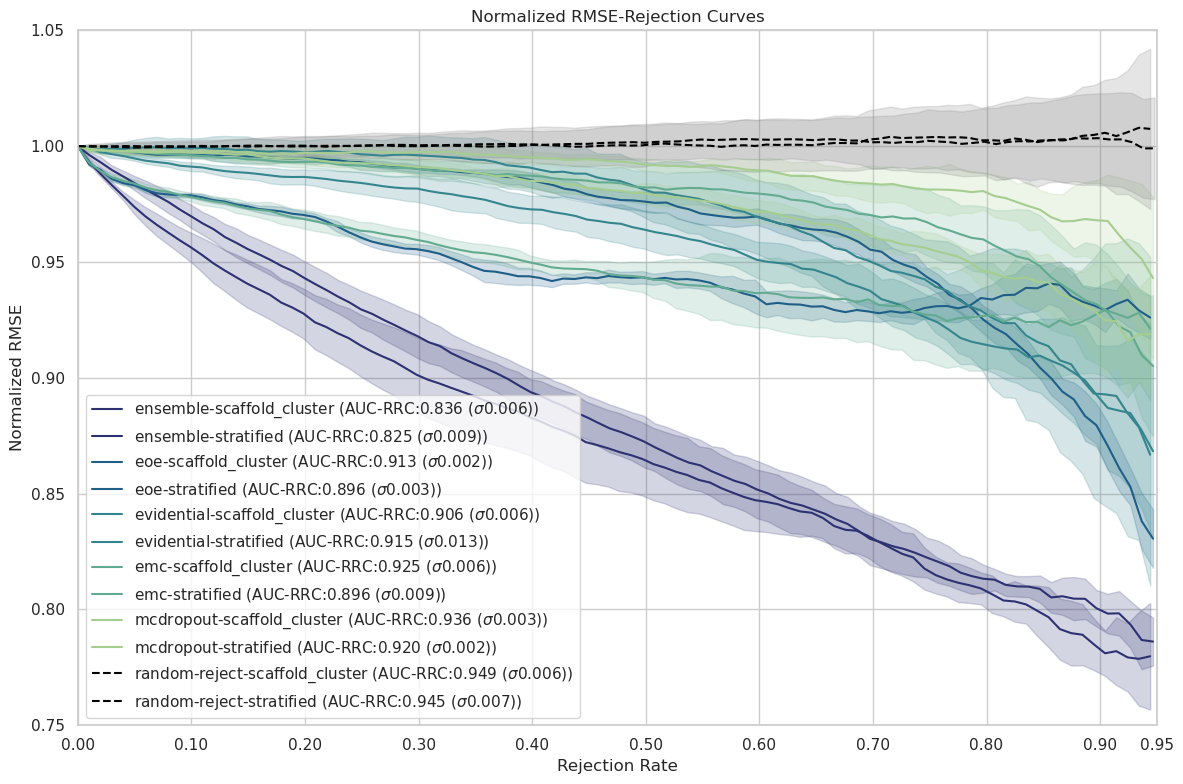

In [325]:
stats_df = plot_rmse_rejection_curves(df_no_time, base_path, cmap="crest_r", save_dir_plot=None, add_to_title="", normalize_rmse=True, unc_type='aleatoric', max_rejection_ratio=0.95)

In [311]:
# df_pcm[df_pcm['model name'] == "20240813-papyrus_xc50_ensemble_time_ankh-large_ecfp2048_legendary-dust-112"]['project_model'].iloc[0]
# print(df_pcm[df_pcm['project_model'].isna()])
# print(df_pcm['project_model'].values)

In [326]:
def plot_auc_comparison(stats_df, cmap="crest_r", save_dir=None, add_to_title="", min_y_axis=0.5):
    model_types = ["ensemble", "eoe", "evidential", "emc", "mcdropout", "random"]  # Ordered model types including Random
    # model_types = ["ensemble", "evidential", "mcdropout", "random"]  # Ordered model types including Random

    splits = stats_df["Split"].unique()
    
    scalar_mappable = ScalarMappable(cmap=cmap)
    color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
    color_dict["random"] = 'black'  # Color for Random baseline

    fig, ax = plt.subplots(figsize=(12, 8))
    bar_width = 0.35
    group_spacing = 0.6
    num_bars = len(model_types)
    positions = []
    tick_positions = []
    tick_labels = []

    for i, split in enumerate(splits):
        split_data = stats_df[stats_df['Split'] == split]
        for j, model_type in enumerate(model_types):
            model_data = split_data[split_data['Model type'] == model_type]
            position = i * (num_bars * bar_width + group_spacing) + j * bar_width
            positions.append(position)
            height = model_data['AUC-RRC_mean'].values[0]
            yerr = model_data['AUC-RRC_std'].values[0]
            ax.bar(
                position,
                height=height,
                yerr=yerr,
                color=color_dict[model_type],
                width=bar_width,
                label=model_type if i == 0 else ""
            )
            # Add tick positions and labels
            if j == len(model_types) - 1:
                center_position = (i * (num_bars * bar_width + group_spacing)) + (num_bars * bar_width - bar_width / 2) / 2
                tick_positions.append(center_position)
                tick_labels.append(f"{split}")

    def create_stats_legend(color_dict):
        patches = []
        for label, color in color_dict.items():
            patches.append(mpatches.Patch(facecolor=color, edgecolor='black', label=label))
        return patches

    legend_elements = create_stats_legend(color_dict)

    ax.legend(handles=legend_elements, bbox_to_anchor=(1.0, 1.0), loc="upper left", borderaxespad=0, frameon=False)
    ax.set_xticks(tick_positions)
    ax.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor", fontsize=9)
    ax.set_xlabel("Splits")
    ax.set_ylabel("AUC-RRC")
    ax.set_ylim(min_y_axis, 1.0)
    
    plot_name = f"auc_comparison_barplot_{cmap}"
    plot_name += f"_{add_to_title}" if add_to_title else ""
    save_plot(fig, save_dir, plot_name, tighten=True)
    plt.show()
    plt.close()

# def plot_auc_comparison(stats_df, cmap="crest_r", save_dir=None, add_to_title=""):
#     # model_types = stats_df["Model type"].unique()
#     model_types = ["ensemble", "evidential", "mcdropout"]  # Ordered model types
# 
#     splits = stats_df["Split"].unique()
# 
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
#     bar_width = 0.35
#     group_spacing = 0.6
#     num_bars = len(model_types)
#     positions = []
#     tick_positions = []
#     tick_labels = []
# 
#     for i, split in enumerate(splits):
#         split_data = stats_df[stats_df['Split'] == split]
#         for j, model_type in enumerate(model_types):
#             model_data = split_data[split_data['Model type'] == model_type]
#             position = i * (num_bars * bar_width + group_spacing) + j * bar_width
#             positions.append(position)
#             height = model_data['AUC-RRC_mean'].values[0]
#             yerr = model_data['AUC-RRC_std'].values[0]
#             ax.bar(
#                 position,
#                 height=height,
#                 yerr=yerr,
#                 color=color_dict[model_type],
#                 width=bar_width,
#                 label=model_type if i == 0 else ""
#             )
#             # Add tick positions and labels
#             if j == len(model_types) - 1:
#                 # center_position = (i * (num_bars * bar_width + group_spacing)) + (num_bars * bar_width) / 2
#                 center_position = (i * (num_bars * bar_width + group_spacing)) + (num_bars * bar_width - bar_width / 2) / 2
#                 tick_positions.append(center_position)
#                 tick_labels.append(f"{split}")
# 
#     def create_stats_legend(color_dict):
#         patches = []
#         for label, color in color_dict.items():
#             patches.append(mpatches.Patch(facecolor=color, edgecolor='black', label=label))
#         return patches
# 
#     legend_elements = create_stats_legend(color_dict)
# 
#     ax.legend(handles=legend_elements, bbox_to_anchor=(1.0, 1.0), loc="upper left", borderaxespad=0, frameon=False)
#     ax.set_xticks(tick_positions)
#     ax.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor", fontsize=9)
#     ax.set_xlabel("Splits")
#     ax.set_ylabel("AUC-RRC")
#     plot_name = f"auc_comparison_barplot_{cmap}"
#     plot_name += f"_{add_to_title}" if add_to_title else ""
#     save_plot(fig, save_dir, plot_name, tighten=True)
#     plt.show()
#     plt.close()

In [261]:
# df_pcm_stratified = df_pcm[df_pcm['Split'] == 'stratified']
# df_pcm_scaffold = df_pcm[df_pcm['Split'] == 'scaffold_cluster']
# df_pcm_time = df_pcm[df_pcm['Split'] == 'time']
# print(df_pcm_stratified.shape, df_pcm_scaffold.shape, df_pcm_time.shape)

In [262]:
# df_pcm.reset_index(inplace=True)

In [263]:
# df_pcm.loc[0]['project_model']

'papyrus/xc50/all/reassess-runs_ensemble_mcdp_xc50/20240813-papyrus_xc50_ensemble_time_ankh-large_ecfp2048_legendary-dust-112/'

In [327]:
# stats_df = plot_rmse_rejection_curves(df_pcm, base_path, cmap="crest_r", save_dir_plot=None, add_to_title="", normalize_rmse=True, unc_type='both', max_rejection_ratio=0.95)
# stats_df = plot_rmse_rejection_curves(df_pcm, preds_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="", normalize_rmse=True, unc_type='both', max_rejection_ratio=0.95)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


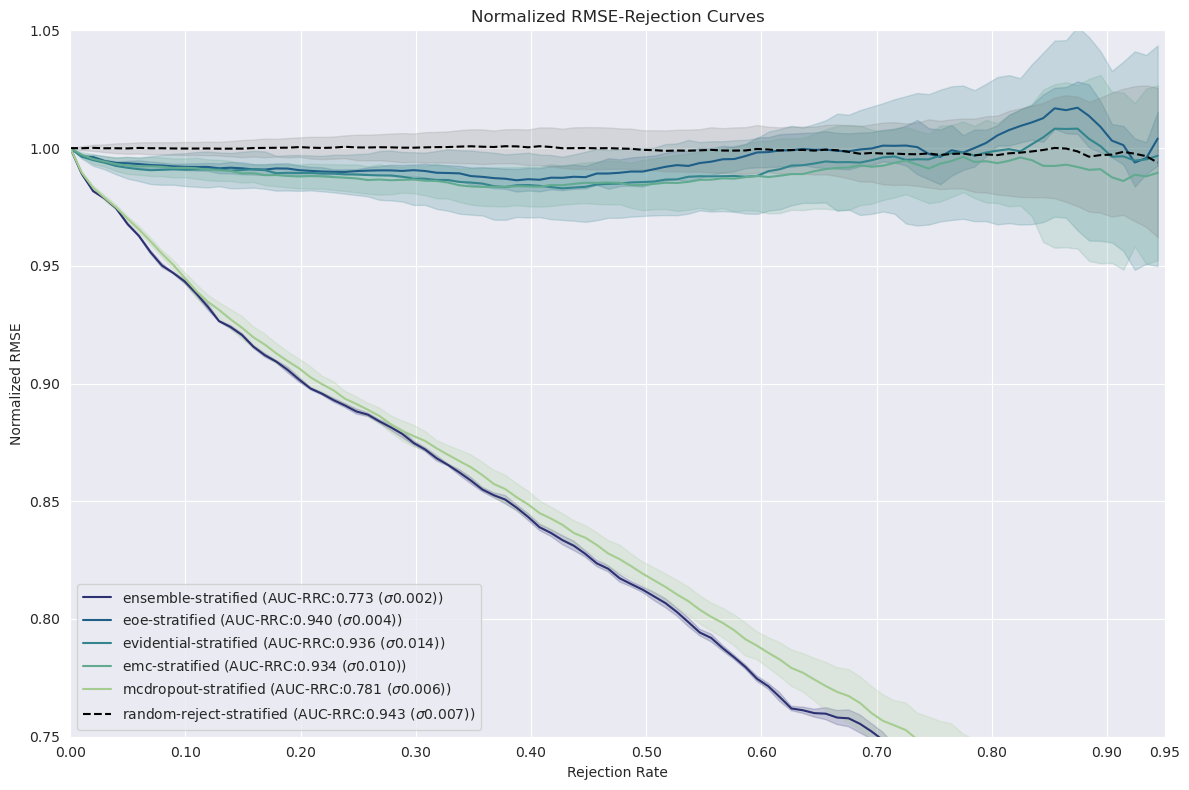

In [29]:
stats_df = plot_rmse_rejection_curves(df_pcm_stratified, preds_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="stratified-both-uct", normalize_rmse=True, unc_type='both', max_rejection_ratio=0.95)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


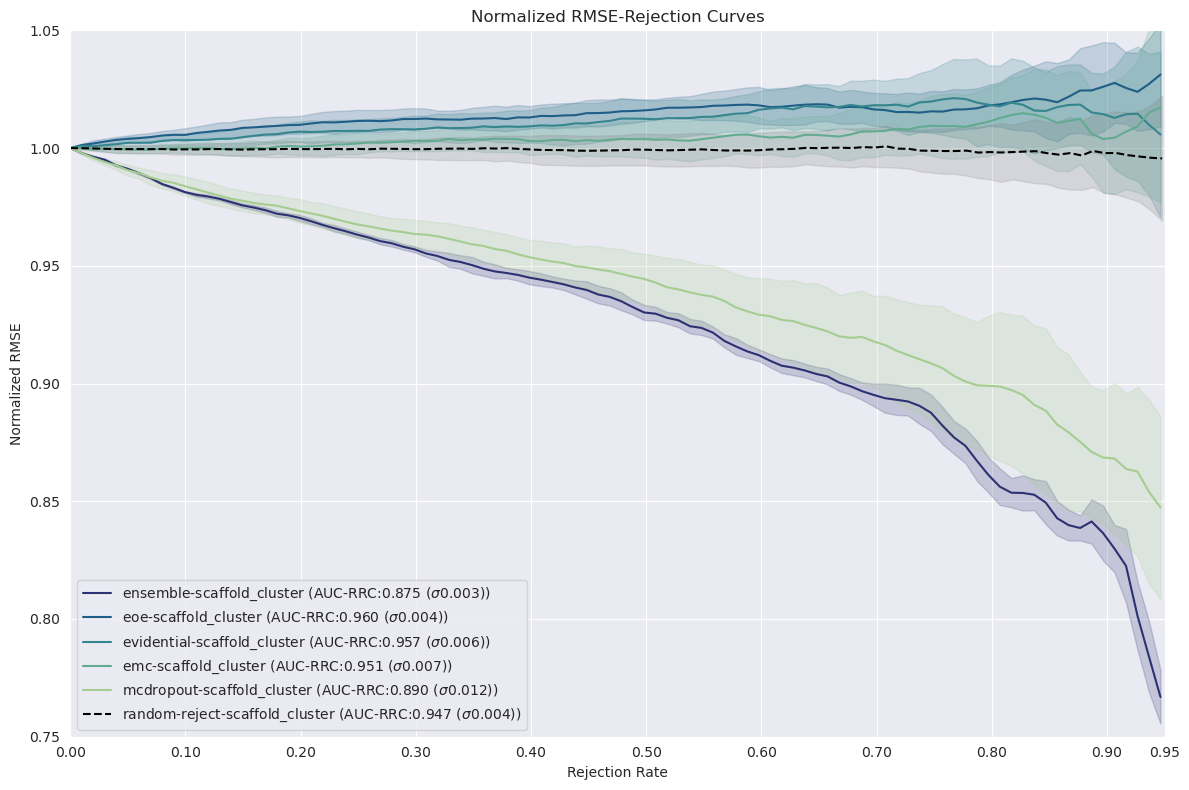

In [30]:
stats_df = plot_rmse_rejection_curves(df_pcm_scaffold, preds_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="scaffold-both-uct", normalize_rmse=True, unc_type='both', max_rejection_ratio=0.95)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


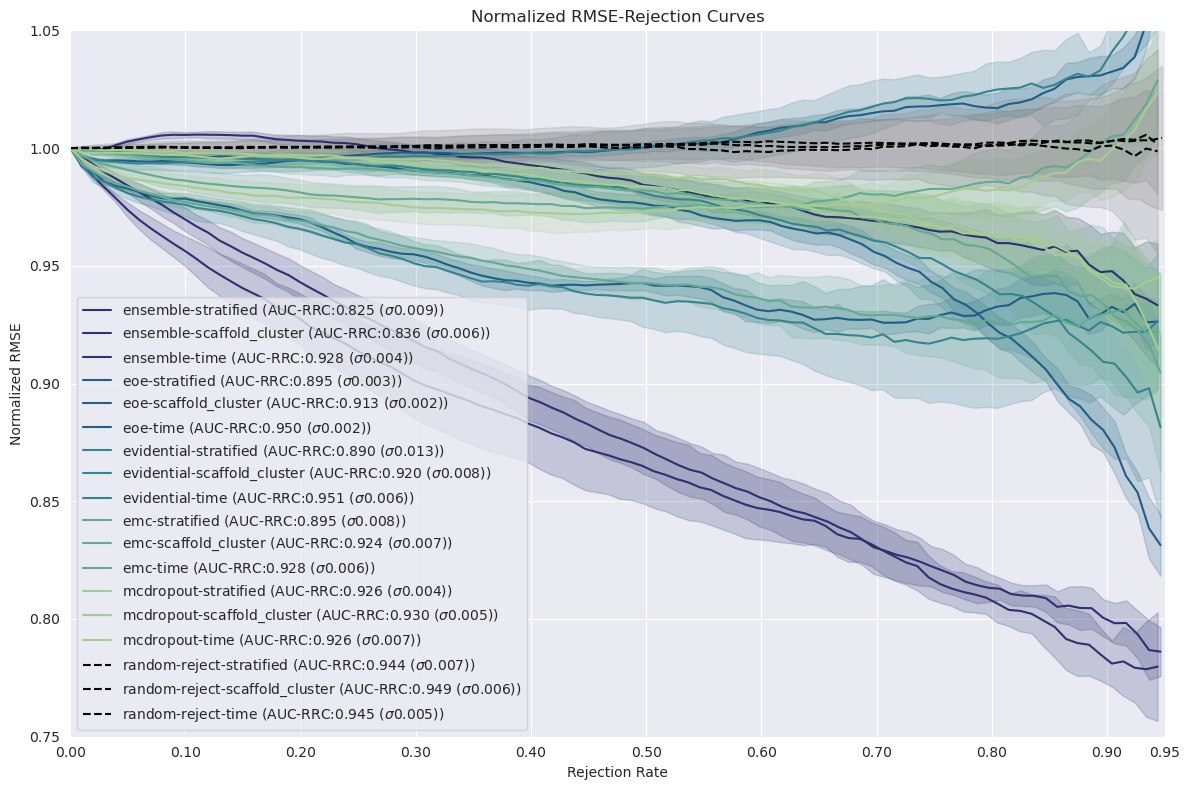

In [83]:
stats_df = plot_rmse_rejection_curves(df_pcm, preds_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="", normalize_rmse=True, unc_type='aleatoric', max_rejection_ratio=0.95)
# plot_rmse_rejection_curves(df_pcm, models_dir, cmap="crest_r", save_dir_plot=None, add_to_title="", normalize_rmse=False, unc_type='aleatoric', max_rejection_ratio=0.95):

In [84]:
stats_df.head(10)

Model type             Split  AUC-RRC_mean  AUC-RRC_std
0    ensemble        stratified      0.824802     0.008691
1    ensemble  scaffold_cluster      0.836012     0.006410
2    ensemble              time      0.928077     0.004332
3         eoe        stratified      0.894798     0.002806
4         eoe  scaffold_cluster      0.913204     0.001945
5         eoe              time      0.949707     0.001973
6  evidential        stratified      0.890142     0.012977
7  evidential  scaffold_cluster      0.920013     0.008152
8  evidential              time      0.950835     0.005590
9         emc        stratified      0.895391     0.008363

In [100]:
# plot_auc_comparison(stats_df, cmap="crest_r", save_dir=save_dir, add_to_title="")

In [94]:
# stats_df = plot_rmse_rejection_curves(df_pcm_stratified, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="stratified-normalized", normalize_rmse=True)
# stats_df = plot_rmse_rejection_curves(df_pcm_scaffold, save_dir, cmap="crest_r", save_dir_plot=None, normalize_rmse=False)

In [54]:
# # BACKUP
# from sklearn.metrics import mean_squared_error, auc
# 
# def calculate_rmse_rejection_curve(preds, uncertainty_col='y_alea', true_label_col='y_true', pred_label_col='y_pred', normalize_rmse=False, random_rejection=False):
#     if random_rejection:
#         preds = preds.sample(frac=1).reset_index(drop=True)  # Shuffle the DataFrame randomly
#     else:
#         preds = preds.sort_values(by=uncertainty_col, ascending=False)
#     # preds = preds.sort_values(by=uncertainty_col, ascending=False)
#     rejection_steps = np.arange(0, len(preds), step=int(len(preds) * 0.01))
#     rejection_rates = rejection_steps / len(preds)
#     rmses = []
#     
#     initial_rmse = mean_squared_error(preds[true_label_col], preds[pred_label_col], squared=False)
# 
#     for i in rejection_steps:
#         selected_preds = preds.iloc[i:]
#         rmse = mean_squared_error(selected_preds[true_label_col], selected_preds[pred_label_col], squared=False)
#         if normalize_rmse:
#             rmse /= initial_rmse
#         rmses.append(rmse)
# 
#     auc_arc = auc(rejection_rates, rmses)
#     return rejection_rates, rmses, auc_arc
# 
# 
# def plot_rmse_rejection_curves(df_pcm, models_dir, cmap="crest_r", save_dir_plot=None, add_to_title="", normalize_rmse=False):
#     stats_dfs = []
#     # model_types = df_pcm["Model type"].unique()
#     model_types = ["ensemble", "evidential", "mcdropout"]  # Ordered model types
#     splits = df_pcm["Split"].unique()
#     
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
# 
#     for model_type in model_types:
#         for split in splits:
#             model_names = df_pcm[(df_pcm["Model type"] == model_type) & (df_pcm["Split"] == split)]["model name"].unique()
#             aggregated_rmses = []
#             auc_values = []
# 
#             for model_name in model_names:
#                 preds = load_predictions(models_dir, model_name)
#                 rejection_rates, rmses, auc_arc = calculate_rmse_rejection_curve(preds, normalize_rmse=normalize_rmse)
#                 aggregated_rmses.append(rmses)
#                 auc_values.append(auc_arc)
# 
#             # Average RMSE values across models
#             mean_rmses = np.mean(aggregated_rmses, axis=0)
#             std_rmses = np.std(aggregated_rmses, axis=0)
# 
#             # Plot the aggregated RMSE-Rejection curve
#             ax.plot(rejection_rates, mean_rmses, label=f"{model_type}-{split} (AUC-RRC: {np.mean(auc_values):.2f})", color=color_dict[model_type])
#             ax.fill_between(rejection_rates, mean_rmses - std_rmses, mean_rmses + std_rmses, color=color_dict[model_type], alpha=0.2)
#             
#             # Store aggregated AUC values
#             mean_auc = np.mean(auc_values)
#             std_auc = np.std(auc_values)
#             stats_dfs.append({'Model type': model_type, 'Split': split, 'AUC-RRC_mean': mean_auc, 'AUC-RRC_std': std_auc})
#     
#     # # Plot the baseline random rejection curve
#     # aggregated_rmses_random = []
#     # auc_values_random = []
#     # for model_name in df_pcm["model name"].unique():
#     #     preds = load_predictions(models_dir, model_name)
#     #     rejection_rates, rmses_random, auc_rrc_random = calculate_rmse_rejection_curve(preds, random_rejection=True)
#     #     aggregated_rmses_random.append(rmses_random)
#     #     auc_values_random.append(auc_rrc_random)
#     # mean_rmses_random = np.mean(aggregated_rmses_random, axis=0)
#     # std_rmses_random = np.std(aggregated_rmses_random, axis=0)
#     ax.set_xlabel("Rejection Rate")
#     ax.set_ylabel("RMSE" if not normalize_rmse else "Normalized RMSE")
#     ax.set_title("RMSE-Rejection Curves" if not normalize_rmse else "Normalized RMSE-Rejection Curves")
#     ax.set_ylim(0.75,1.05) if normalize_rmse else None
#     ax.set_xlim(0, 1) # Rejection rate from 0 to 1
#     # Custom legend order
#     handles, labels = ax.get_legend_handles_labels()
#     ordered_labels = [f"{model_type}-" for model_type in model_types]
#     ordered_handles = [handles[labels.index(label)] for label in labels if any(label.startswith(ol) for ol in ordered_labels)]
#     ax.legend(handles=ordered_handles, bbox_to_anchor=(1.05, 1), loc='upper left')
#     # ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     
#     plot_name = "rmse_rejection_curve"
#     plot_name += f"_{add_to_title}" if add_to_title else ""
#     # plot_name += "_normalized" if normalize_rmse else ""
#     save_plot(fig, save_dir_plot, plot_name, tighten=True)
#     
#     plt.show()
# 
#     return pd.DataFrame(stats_dfs)
# 
# def plot_auc_comparison(stats_df, cmap="crest_r", save_dir=None, add_to_title=""):
#     # model_types = stats_df["Model type"].unique()
#     model_types = ["ensemble", "evidential", "mcdropout"]  # Ordered model types
# 
#     splits = stats_df["Split"].unique()
#     
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
#     bar_width = 0.35
#     group_spacing = 0.6
#     num_bars = len(model_types)
#     positions = []
#     tick_positions = []
#     tick_labels = []
# 
#     for i, split in enumerate(splits):
#         split_data = stats_df[stats_df['Split'] == split]
#         for j, model_type in enumerate(model_types):
#             model_data = split_data[split_data['Model type'] == model_type]
#             position = i * (num_bars * bar_width + group_spacing) + j * bar_width
#             positions.append(position)
#             height = model_data['AUC-RRC_mean'].values[0]
#             yerr = model_data['AUC-RRC_std'].values[0]
#             ax.bar(
#                 position,
#                 height=height,
#                 yerr=yerr,
#                 color=color_dict[model_type],
#                 width=bar_width,
#                 label=model_type if i == 0 else ""
#             )
#             # Add tick positions and labels
#             if j == len(model_types) - 1:
#                 # center_position = (i * (num_bars * bar_width + group_spacing)) + (num_bars * bar_width) / 2
#                 center_position = (i * (num_bars * bar_width + group_spacing)) + (num_bars * bar_width - bar_width / 2) / 2
#                 tick_positions.append(center_position)
#                 tick_labels.append(f"{split}")
# 
#     def create_stats_legend(color_dict):
#         patches = []
#         for label, color in color_dict.items():
#             patches.append(mpatches.Patch(facecolor=color, edgecolor='black', label=label))
#         return patches
# 
#     legend_elements = create_stats_legend(color_dict)
# 
#     ax.legend(handles=legend_elements, bbox_to_anchor=(1.0, 1.0), loc="upper left", borderaxespad=0, frameon=False)
#     ax.set_xticks(tick_positions)
#     ax.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor", fontsize=9)
#     ax.set_xlabel("Splits")
#     ax.set_ylabel("AUC-RRC")
#     plot_name = f"auc_comparison_barplot_{cmap}"
#     plot_name += f"_{add_to_title}" if add_to_title else ""
#     save_plot(fig, save_dir, plot_name, tighten=True)
#     plt.show()
#     plt.close()

In [93]:
# stats_df = plot_rmse_rejection_curves(df_pcm_scaffold, save_dir, cmap="crest_r", save_dir_plot=None, normalize_rmse=True, unc_type='epistemic')

In [92]:
# stats_df = plot_rmse_rejection_curves(df_pcm_scaffold, save_dir, cmap="crest_r", save_dir_plot=None, normalize_rmse=True, unc_type='aleatoric')

In [91]:
# stats_df = plot_rmse_rejection_curves(df_pcm_scaffold, save_dir, cmap="crest_r", save_dir_plot=None, normalize_rmse=True, unc_type='both')

In [329]:
# we want to create a function to save stats_df to a csv file
def save_stats_df(stats_df, save_dir, add_to_title=""):
    stats_df.to_csv(os.path.join(save_dir, f"stats_df_{add_to_title}.csv"), index=False)
    
def load_stats_df(save_dir, add_to_title=""):
    return pd.read_csv(os.path.join(save_dir, f"stats_df_{add_to_title}.csv"))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


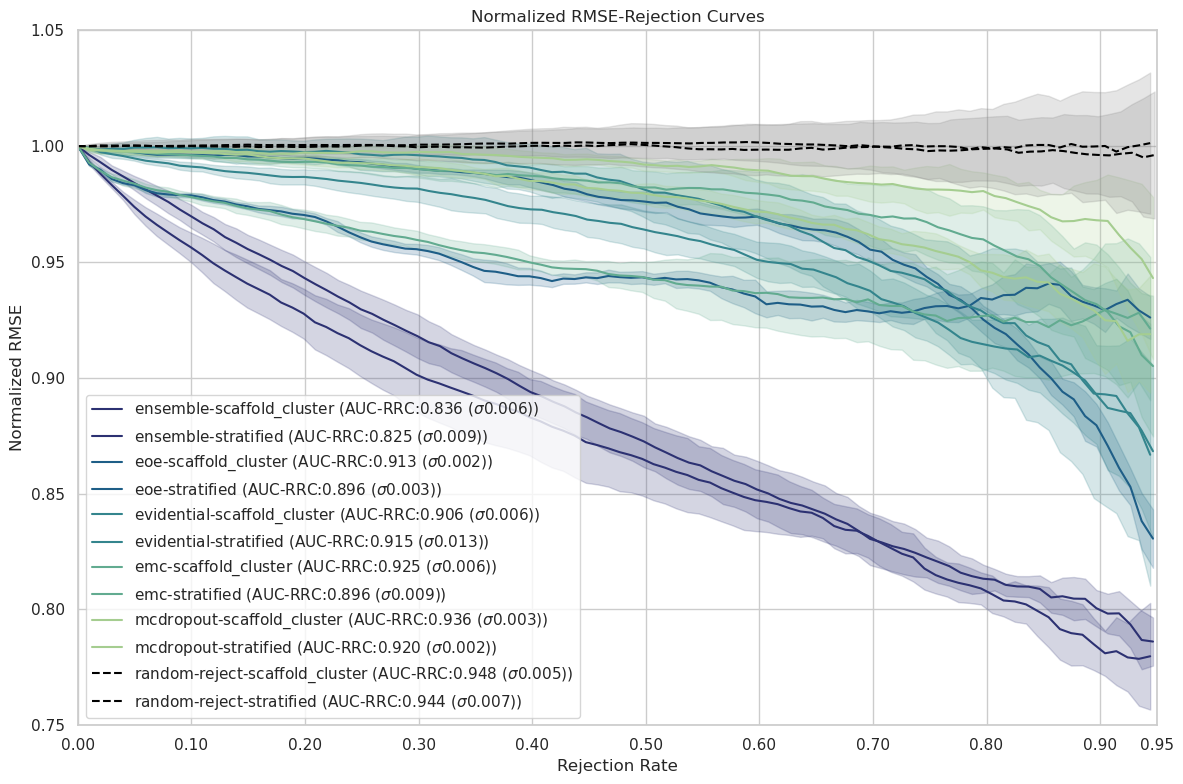

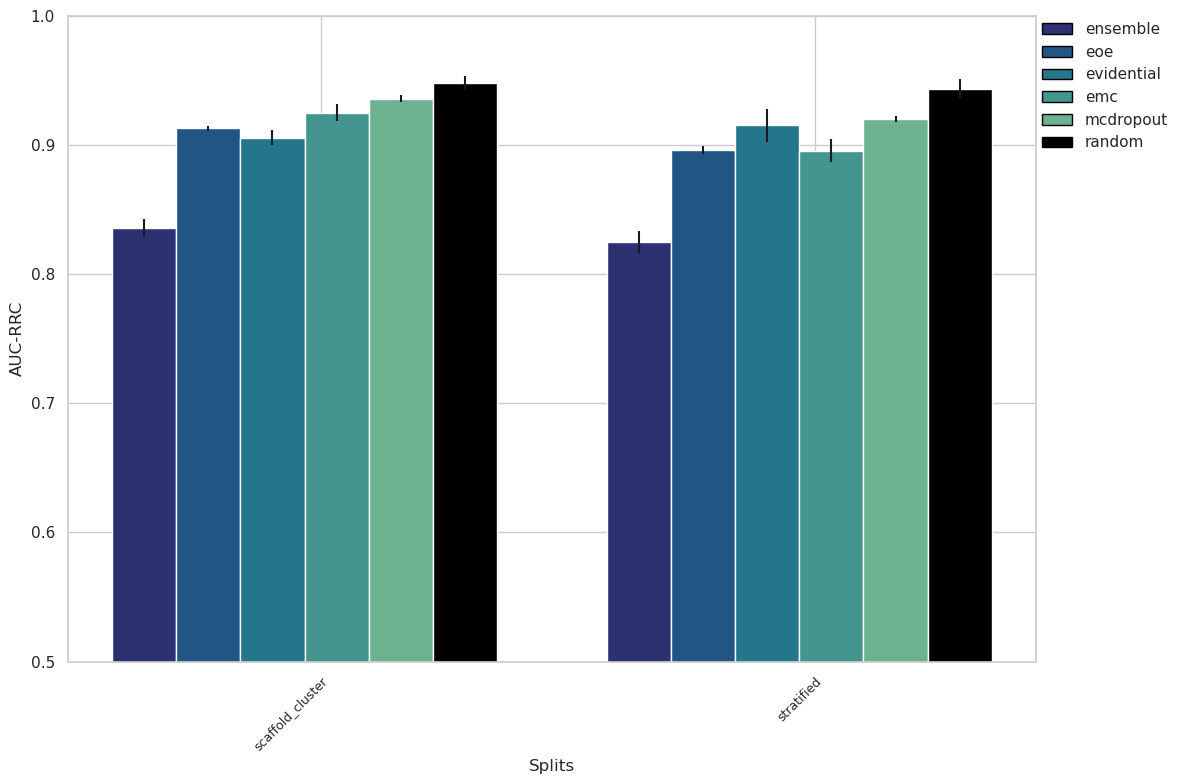

/tmp/ipykernel_1531494/467680392.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


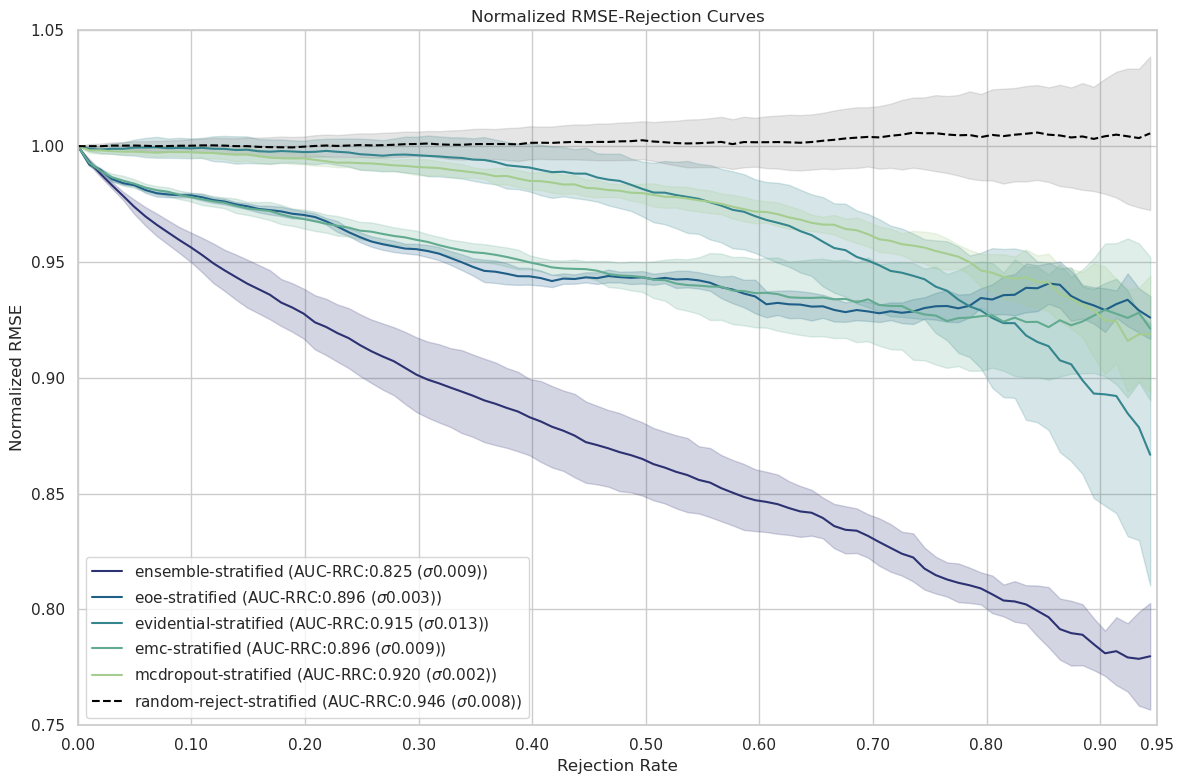

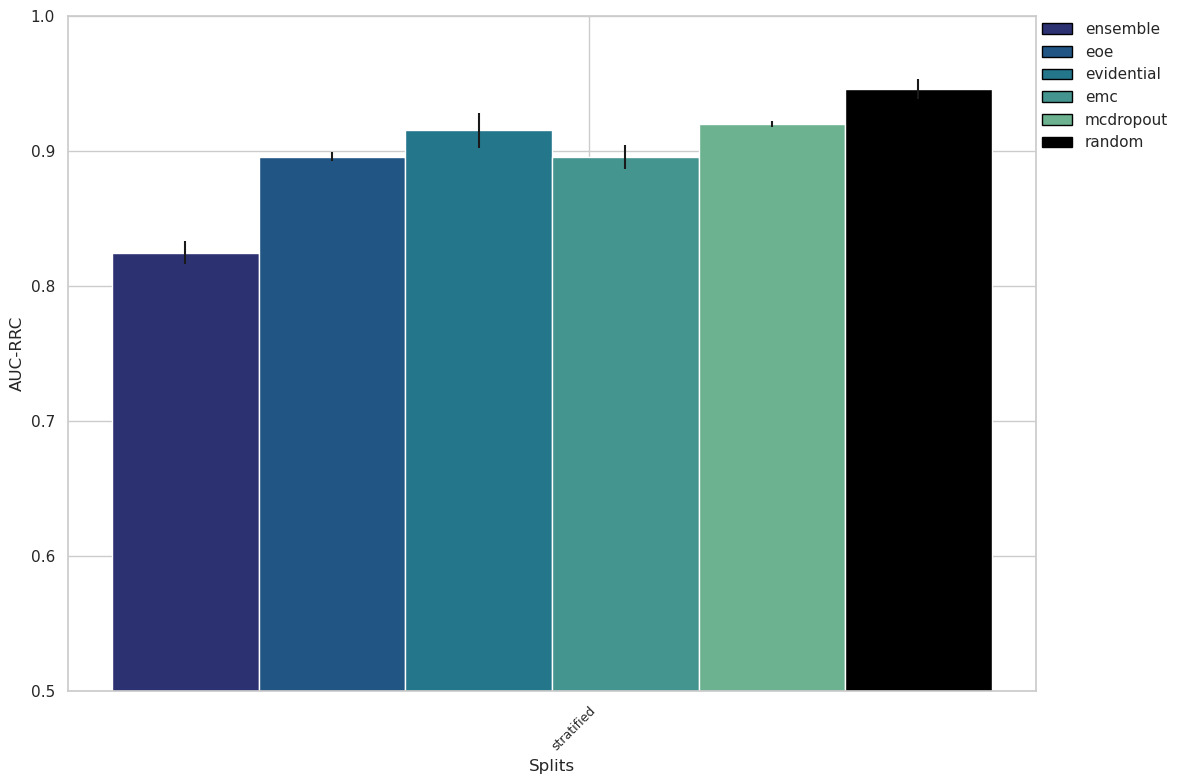

/tmp/ipykernel_1531494/467680392.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


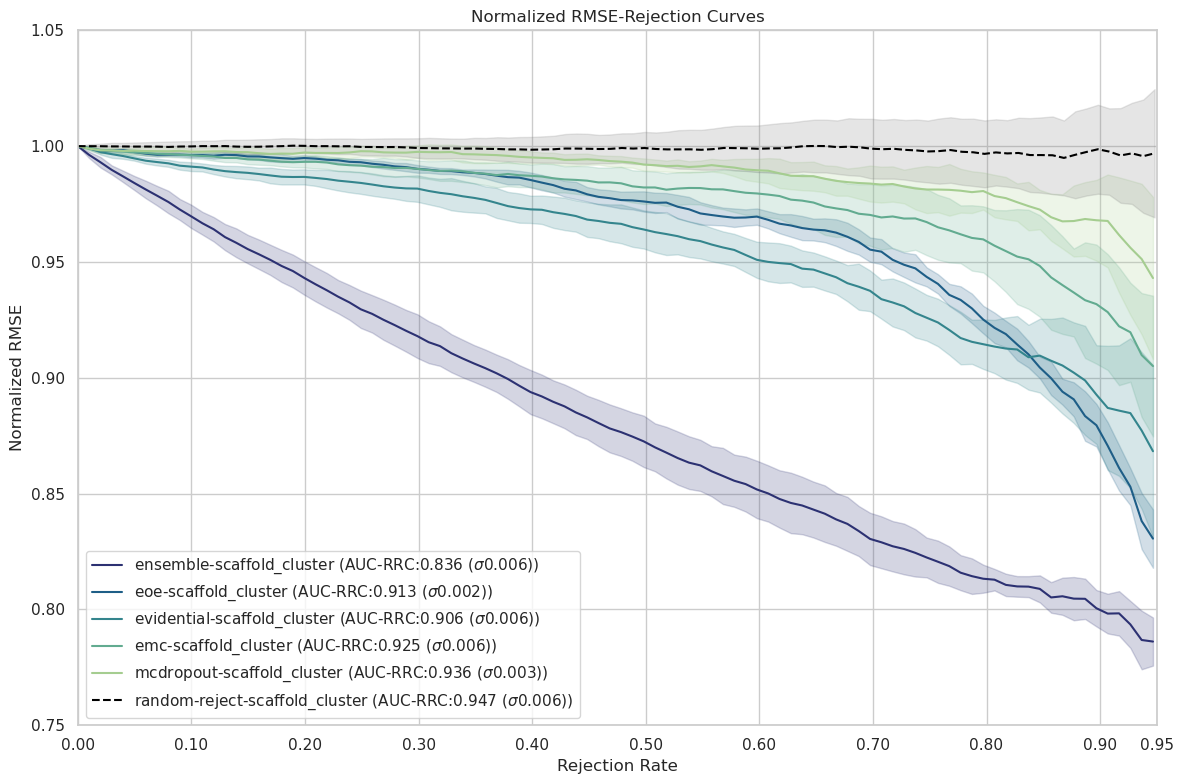

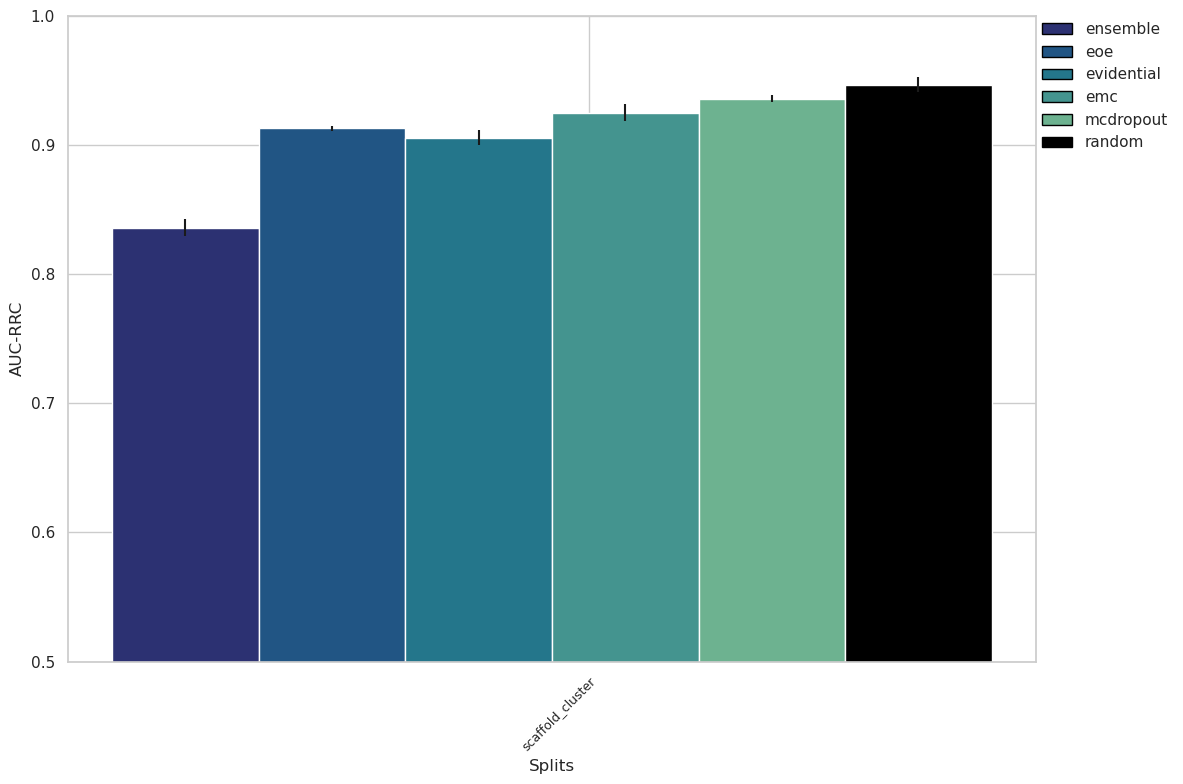

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


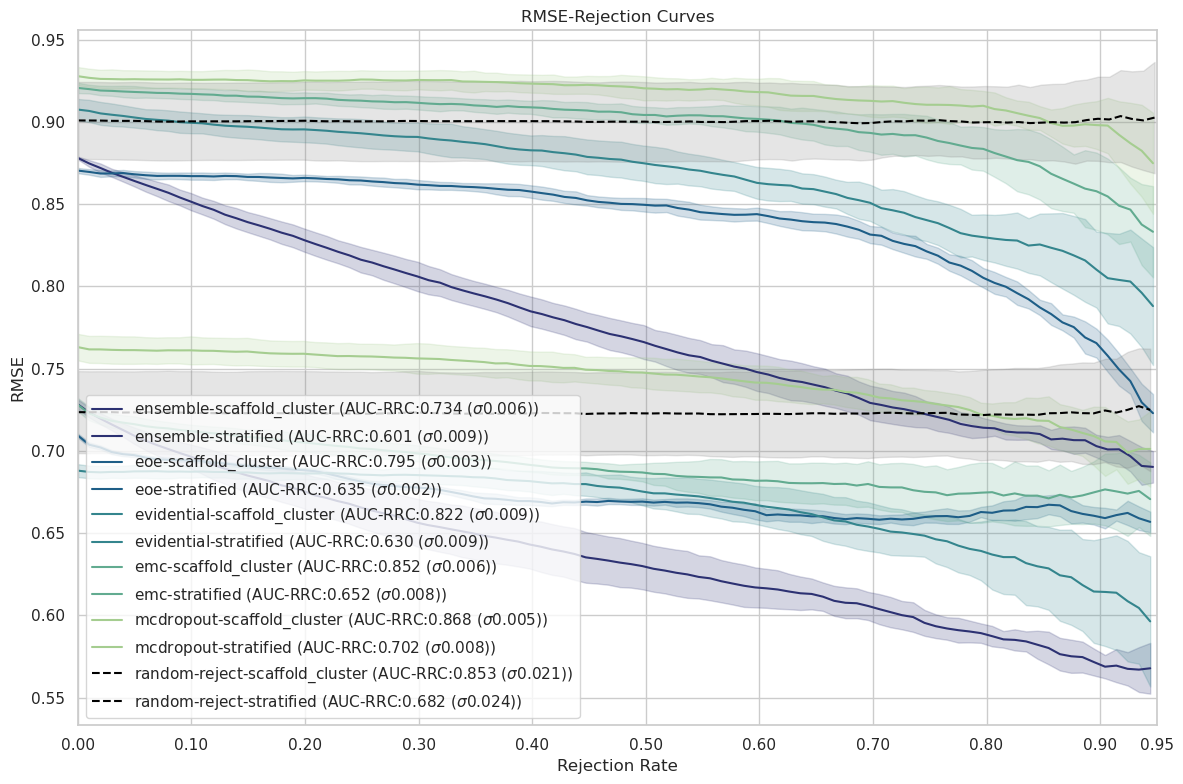

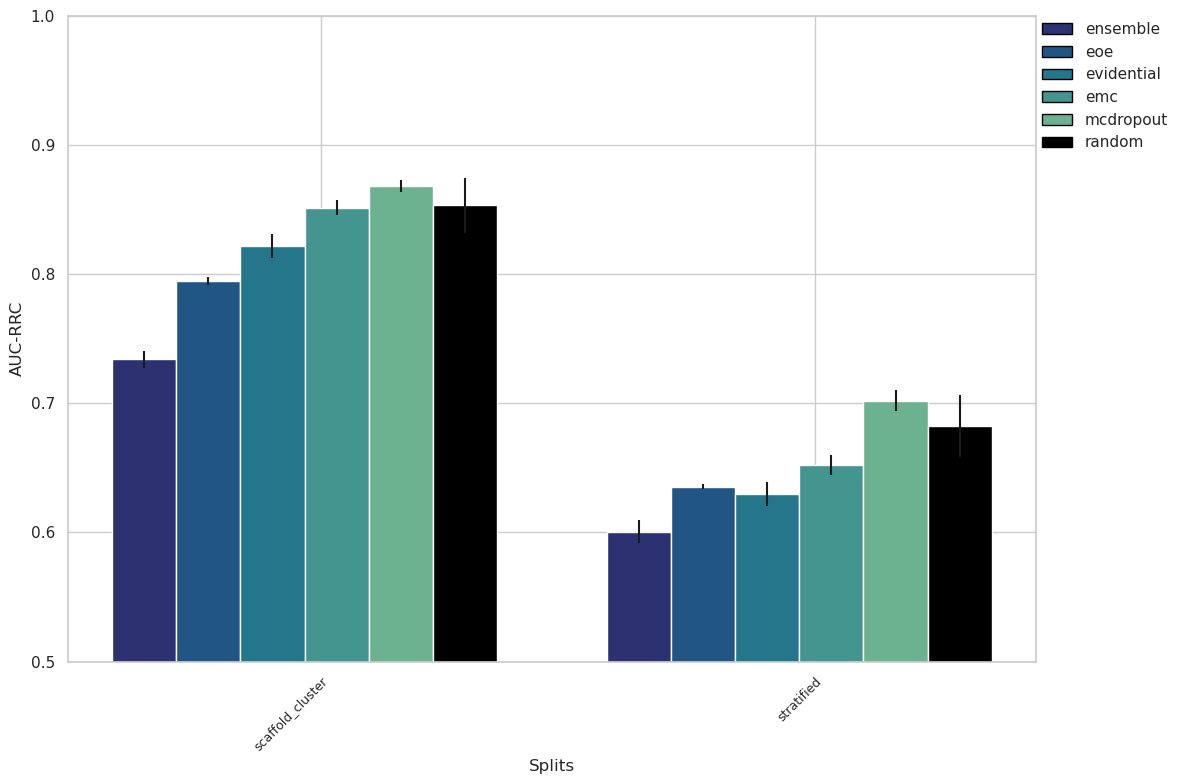

/tmp/ipykernel_1531494/467680392.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


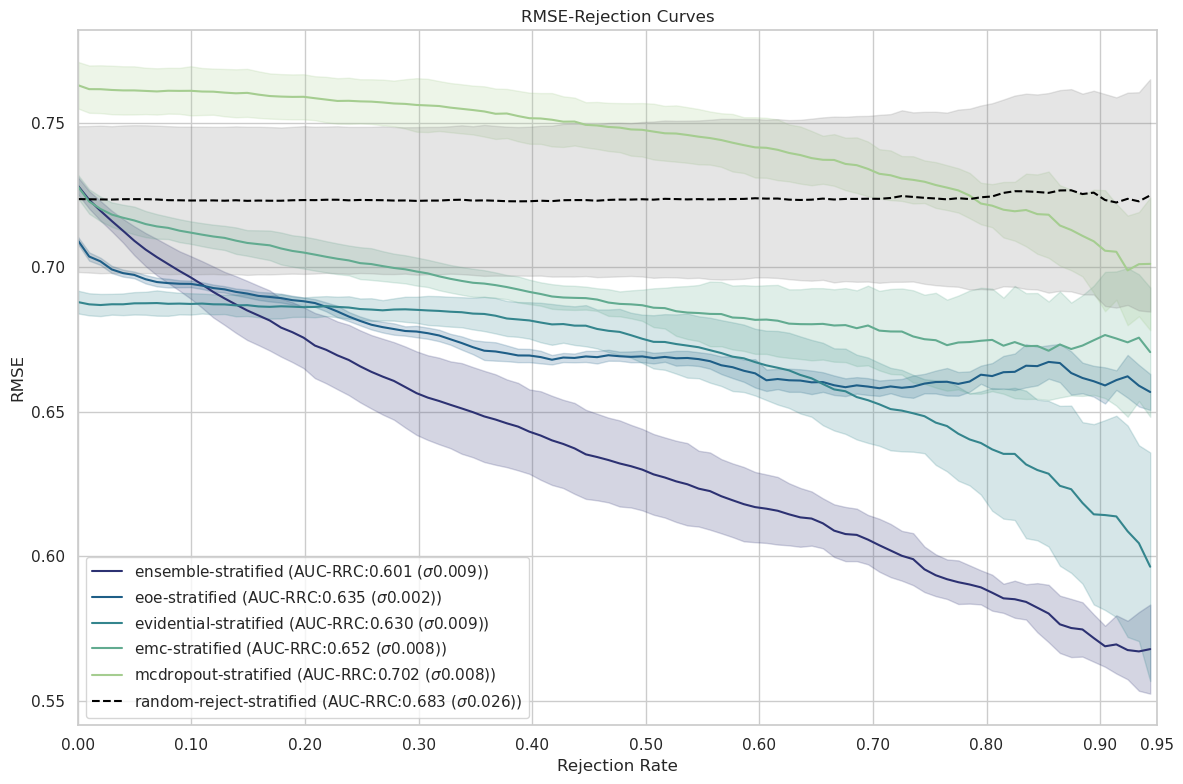

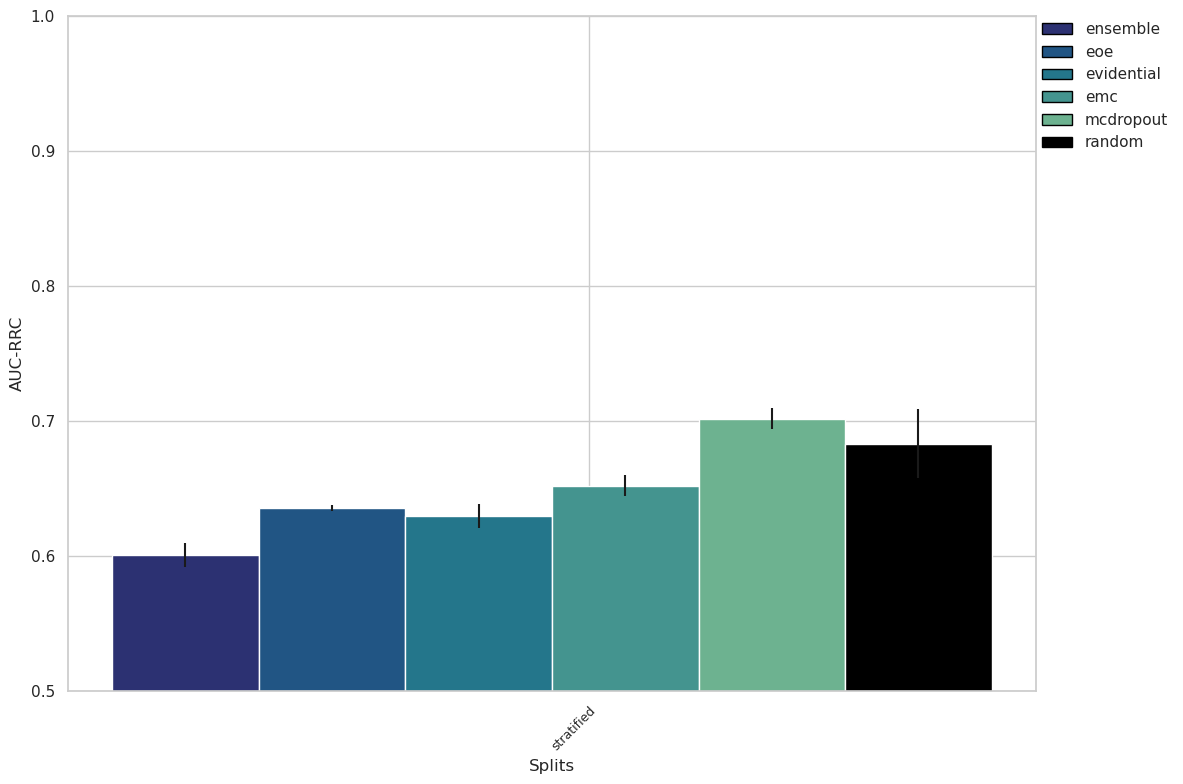

/tmp/ipykernel_1531494/467680392.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


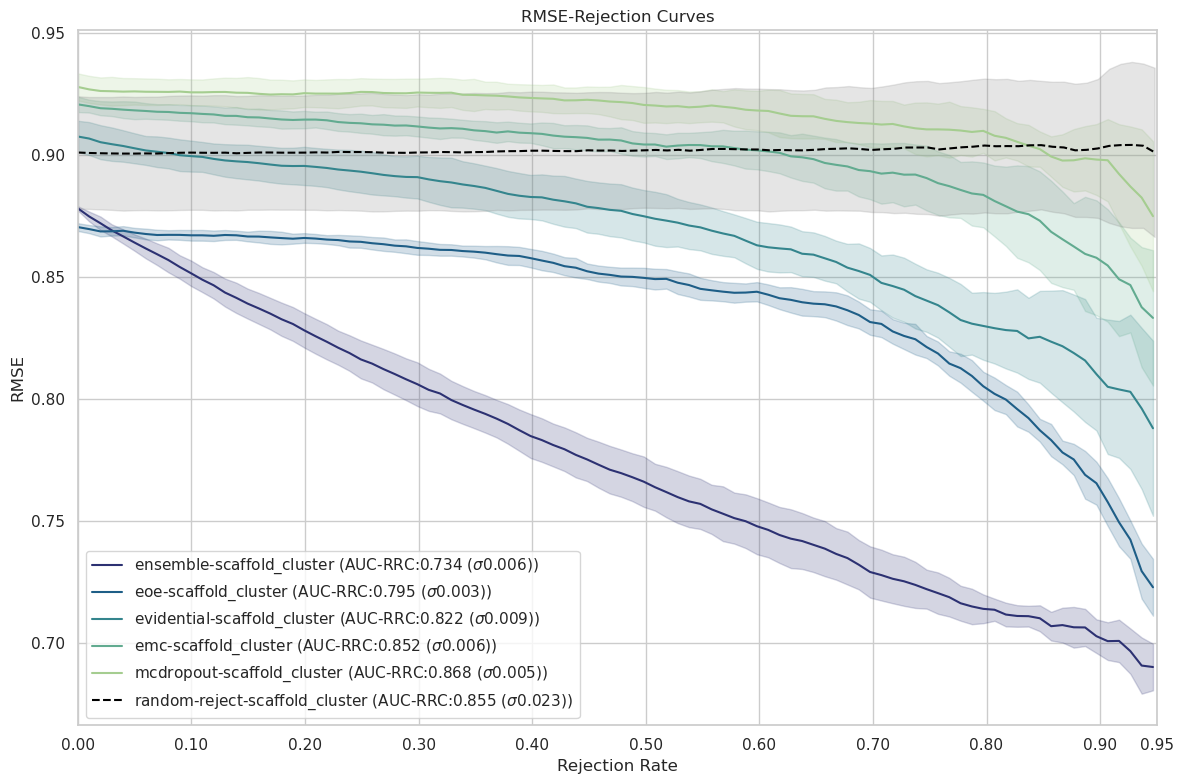

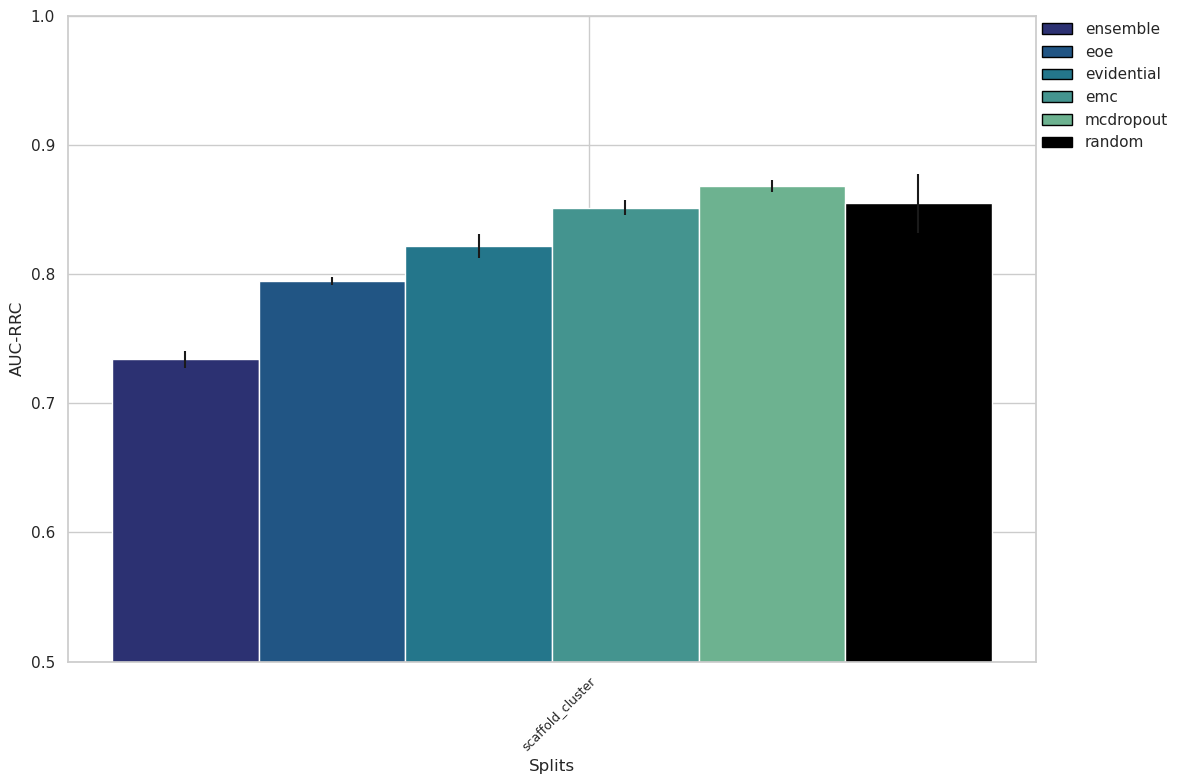

In [331]:
# for loop one normalized and one not
# save_dir = '/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/'
# save_dir_plot = '/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/rrcs/'
save_dir_plot = os.path.join(save_dir_no_time, "rrcs")
# make dir if not exist
os.makedirs(save_dir_plot, exist_ok=True)

for normalize_rmse in [True, False]:
    add_to_title = "-normalized" if normalize_rmse else ""
    stats_df = plot_rmse_rejection_curves(df_no_time, base_path, cmap="crest_r", save_dir_plot=save_dir_plot, add_to_title="all"+add_to_title, normalize_rmse=normalize_rmse, max_rejection_ratio=0.95, unc_type='aleatoric')
    plot_auc_comparison(stats_df, cmap="crest_r", save_dir=save_dir_plot, add_to_title="all"+add_to_title)
    save_stats_df(stats_df, save_dir_plot, add_to_title="all"+add_to_title)
    for name, df in zip(["stratified", "scaffold"], [df_pcm_stratified, df_pcm_scaffold]):
        stats_df = plot_rmse_rejection_curves(df, base_path, cmap="crest_r", save_dir_plot=save_dir_plot, add_to_title=name+add_to_title, normalize_rmse=normalize_rmse, max_rejection_ratio=0.95, unc_type='aleatoric')
        plot_auc_comparison(stats_df, cmap="crest_r", save_dir=save_dir_plot, add_to_title=name+add_to_title)
        save_stats_df(stats_df, save_dir_plot, add_to_title=name+add_to_title)
# stats_df = plot_rmse_rejection_curves(df_pcm, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title=add_to_title, normalize_rmse=False)
# plot_auc_comparison(stats_df, cmap="crest_r", save_dir=save_dir, add_to_title="all")


In [ ]:
# CREST_R is bad M'Kay!

In [ ]:
# for loop one normalized and one not
# save_dir = '/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/'
# save_dir_plot = '/users/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/reassess-2024-06-25-all-models-100/rrcs/'
save_dir_plot = os.path.join(save_dir, "rrcs")
# make dir if not exist
os.makedirs(save_dir_plot, exist_ok=True)

for normalize_rmse in [True, False]:
    add_to_title = "-normalized" if normalize_rmse else ""
    stats_df = plot_rmse_rejection_curves(df_pcm, preds_dir, cmap="crest_r", save_dir_plot=save_dir_plot, add_to_title="all"+add_to_title, normalize_rmse=normalize_rmse, max_rejection_ratio=0.95)
    plot_auc_comparison(stats_df, cmap="crest_r", save_dir=save_dir_plot, add_to_title="all"+add_to_title)
    save_stats_df(stats_df, save_dir_plot, add_to_title="all"+add_to_title)
    for name, df in zip(["stratified", "scaffold", "time"], [df_pcm_stratified, df_pcm_scaffold, df_pcm_time]):
        stats_df = plot_rmse_rejection_curves(df, preds_dir, cmap="crest_r", save_dir_plot=save_dir_plot, add_to_title=name+add_to_title, normalize_rmse=normalize_rmse, max_rejection_ratio=0.95)
        plot_auc_comparison(stats_df, cmap="crest_r", save_dir=save_dir_plot, add_to_title=name+add_to_title)
        save_stats_df(stats_df, save_dir_plot, add_to_title=name+add_to_title)
# stats_df = plot_rmse_rejection_curves(df_pcm, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title=add_to_title, normalize_rmse=False)
# plot_auc_comparison(stats_df, cmap="crest_r", save_dir=save_dir, add_to_title="all")


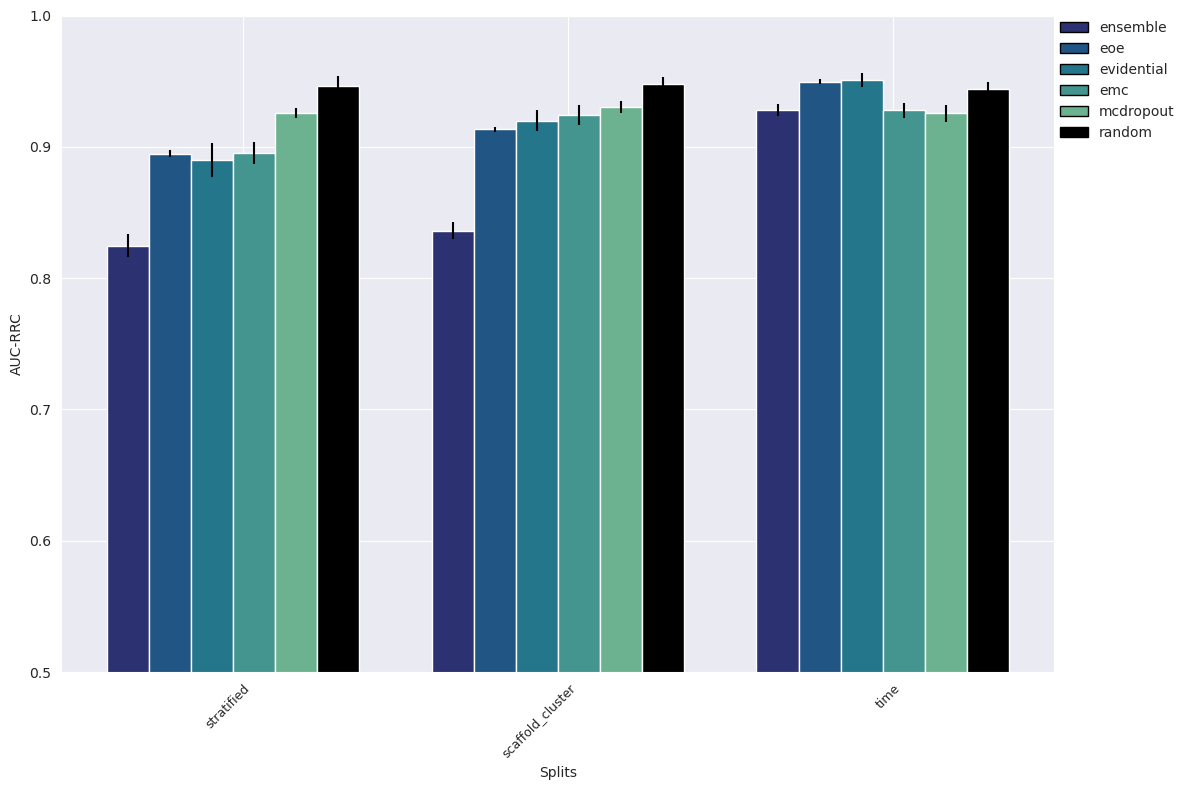

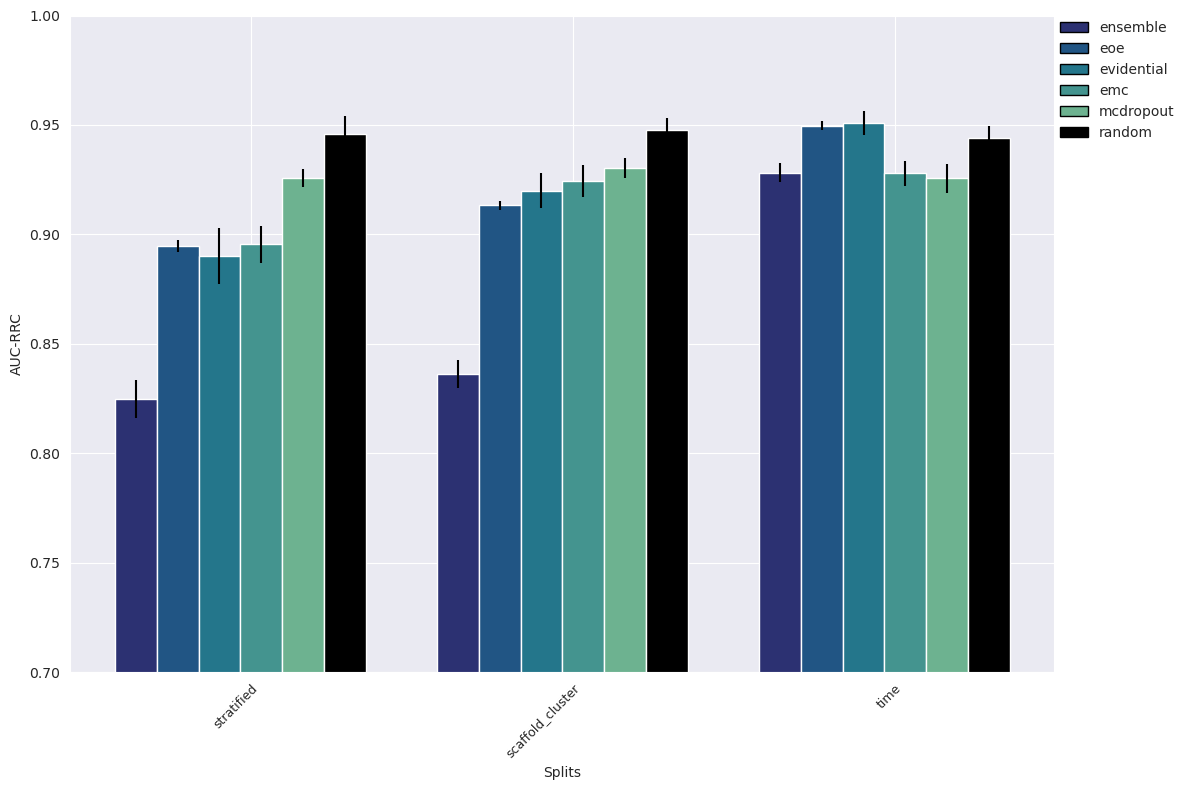

In [102]:
# load stats_df from stratified and scaffold normalized then combine them and create a bar plot for auc comparison with added tag "combined"
stats_df_stratified_normal = load_stats_df(save_dir_plot, add_to_title="stratified-normalized")
stats_df_scaled_normal = load_stats_df(save_dir_plot, add_to_title="scaffold-normalized")
stats_df_time_normal = load_stats_df(save_dir_plot, add_to_title="time-normalized")

combined_stats_df = pd.concat([stats_df_stratified_normal, stats_df_scaled_normal, stats_df_time_normal])
plot_auc_comparison(combined_stats_df, cmap="crest_r", save_dir=save_dir_plot, add_to_title="combined-normalized")
plot_auc_comparison(combined_stats_df, cmap="crest_r", save_dir=save_dir_plot, add_to_title="combined-normalized0.7", min_y_axis=0.7)


In [ ]:
# stats_df_normalized = plot_rmse_rejection_curves(df_pcm, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="all-normal", normalize_rmse=True)
# plot_auc_comparison(stats_df_normalized, cmap="crest_r", save_dir=save_dir, add_to_title="all-normal")

In [ ]:
# stats_df_stratified = plot_rmse_rejection_curves(df_pcm_stratified, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="stratified", normalize_rmse=False)
# plot_auc_comparison(stats_df_stratified, cmap="crest_r", save_dir=save_dir, add_to_title="stratified")
# stats_df_stratified_normal = plot_rmse_rejection_curves(df_pcm_stratified, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="stratified-normal", normalize_rmse=True)
# plot_auc_comparison(stats_df_stratified_normal, cmap="crest_r", save_dir=save_dir, add_to_title="stratified-normal")

In [ ]:
# stats_df_scaled = plot_rmse_rejection_curves(df_pcm_scaffold, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="scaffold", normalize_rmse=False)
# plot_auc_comparison(stats_df_scaled, cmap="crest_r", save_dir=save_dir, add_to_title="scaffold")
# stats_df_scaled_normal = plot_rmse_rejection_curves(df_pcm_scaffold, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="scaffold-normal", normalize_rmse=True)
# plot_auc_comparison(stats_df_scaled_normal, cmap="crest_r", save_dir=save_dir, add_to_title="scaffold-normal")

In [ ]:
# plot_auc_comparison(pd.concat([stats_df_stratified_normal, stats_df_scaled_normal]), cmap="crest_r", save_dir=save_dir, add_to_title="combined")

In [ ]:
# plot_auc_comparison(stats_df_stratified, cmap="crest_r", save_dir=save_dir, add_to_title="stratified")

In [ ]:
# stats_df_scaffold = plot_rmse_rejection_curves(df_pcm_scaffold, save_dir, cmap="crest_r", save_dir_plot=save_dir, add_to_title="scaffold")

In [ ]:
# # TRIAL 2 with RMSE NORMALIZATION
# 
# def load_predictions(models_dir, model_name):
#     preds_path = os.path.join(models_dir, model_name, 'preds.pkl')
#     return pd.read_pickle(preds_path)
# 
# def calculate_rmse_rejection_curve(preds, uncertainty_col='y_alea', true_label_col='y_true', pred_label_col='y_pred'):
#     preds = preds.sort_values(by=uncertainty_col, ascending=False)
#     rejection_steps = np.arange(0, len(preds), step=int(len(preds) * 0.05))
#     rejection_rates = rejection_steps / len(preds)
#     rmses = []
# 
#     initial_rmse = mean_squared_error(preds[true_label_col], preds[pred_label_col], squared=False)
#     
#     for i in rejection_steps:
#         selected_preds = preds.iloc[i:]
#         rmse = mean_squared_error(selected_preds[true_label_col], selected_preds[pred_label_col], squared=False)
#         normalized_rmse = rmse / initial_rmse  # Normalize RMSE values to start at 1
#         rmses.append(normalized_rmse)
#         # rmses.append(rmse - initial_rmse)  # Normalize RMSE values
# 
#     auc_arc = auc(rejection_rates, rmses)
#     return rejection_rates, rmses, auc_arc
# 
# def plot_rmse_rejection_curves(df_pcm, models_dir, cmap="crest", save_dir_plot=None):
#     stats_dfs = []
#     model_types = ["ensemble", "evidential", "mcdropout"]  # Ordered model types
#     splits = df_pcm["Split"].unique()
#     
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
# 
#     for model_type in model_types:
#         for split in splits:
#             model_names = df_pcm[(df_pcm["Model type"] == model_type) & (df_pcm["Split"] == split)]["model name"].unique()
#             aggregated_rmses = []
#             auc_values = []
# 
#             for model_name in model_names:
#                 preds = load_predictions(models_dir, model_name)
#                 rejection_rates, rmses, auc_arc = calculate_rmse_rejection_curve(preds)
#                 aggregated_rmses.append(rmses)
#                 auc_values.append(auc_arc)
# 
#             # Average RMSE values across models
#             mean_rmses = np.mean(aggregated_rmses, axis=0)
#             std_rmses = np.std(aggregated_rmses, axis=0)
# 
#             # Plot the aggregated RMSE-Rejection curve
#             ax.plot(rejection_rates, mean_rmses, label=f"{model_type}-{split} (AUC-ARC: {np.mean(auc_values):.2f})", color=color_dict[model_type])
#             ax.fill_between(rejection_rates, mean_rmses - std_rmses, mean_rmses + std_rmses, color=color_dict[model_type], alpha=0.2)
#             
#             # Store aggregated AUC values
#             mean_auc = np.mean(auc_values)
#             std_auc = np.std(auc_values)
#             stats_dfs.append({'Model type': model_type, 'Split': split, 'AUC-ARC_mean': mean_auc, 'AUC-ARC_std': std_auc})
# 
#     ax.set_xlabel("Rejection Rate")
#     ax.set_ylabel("Normalized RMSE")
#     ax.set_title("Normalized RMSE-Rejection Curves")
# 
#     # Custom legend order
#     handles, labels = ax.get_legend_handles_labels()
#     ordered_labels = [f"{model_type}-" for model_type in model_types]
#     ordered_handles = [handles[labels.index(label)] for label in labels if any(label.startswith(ol) for ol in ordered_labels)]
#     ax.legend(handles=ordered_handles, bbox_to_anchor=(1.05, 1), loc='upper left')
#     
#     plot_name = "rmse_rejection_curve"
#     save_plot(fig, save_dir_plot, plot_name, tighten=False)
#     
#     plt.show()
# 
#     return pd.DataFrame(stats_dfs)

In [ ]:
# stats_df = plot_rmse_rejection_curves(df_pcm_stratified, save_dir, cmap="crest_r", save_dir_plot=None)

In [ ]:
# from sklearn.metrics import mean_squared_error, auc
# 
# # def calculate_rmse_rejection_curve(preds, uncertainty_col='y_alea', true_label_col='y_true', pred_label_col='y_pred'):
# #     preds = preds.sort_values(by=uncertainty_col, ascending=False)
# #     rejection_rates = np.linspace(0, 1, len(preds))
# #     rmses = []
# # 
# #     for i in range(len(preds)):
# #         selected_preds = preds.iloc[i:]
# #         rmse = mean_squared_error(selected_preds[true_label_col], selected_preds[pred_label_col]) #, squared=False
# #         rmses.append(rmse)
# # 
# #     auc_arc = auc(rejection_rates, rmses)
# #     print(auc_arc)
# #     return rejection_rates, rmses, auc_arc
# 
# 
# def plot_accuracy_rejection_curves(df_pcm, models_dir, cmap="crest", save_dir_plot=None):
#     model_types = df_pcm["Model type"].unique()
#     splits = df_pcm["Split"].unique()
#     
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
# 
#     for model_type in model_types:
#         for split in splits:
#             model_names = df_pcm[(df_pcm["Model type"] == model_type) & (df_pcm["Split"] == split)]["model name"].unique()
#             for model_name in model_names:
#                 preds = load_predictions(models_dir, model_name)
#                 rejection_rates, rmses, auc_arc = calculate_rmse_rejection_curve(preds)
#                 
#                 ax.plot(rejection_rates, rmses, label=f"{model_type}-{split}-{model_name} (AUC-ARC: {auc_arc:.2f})", color=color_dict[model_type])
#                 # break
# 
#     ax.set_xlabel("Rejection Rate")
#     ax.set_ylabel("RMSE")
#     ax.set_title("RMSE-Rejection Curves")
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     
#     # if save_dir_plot:
#     plot_name = "rmse_rejection_curve"
#     save_plot(fig, save_dir_plot, plot_name, tighten=False)
#     
#     plt.show()

In [ ]:
# plot_accuracy_rejection_curves(df_pcm, save_dir, cmap="crest_r", save_dir_plot=None)

In [ ]:
# def calculate_rmse_rejection_curve(preds, uncertainty_col='y_alea', true_label_col='y_true', pred_label_col='y_pred'):
#     preds = preds.sort_values(by=uncertainty_col, ascending=False)
#     rejection_rates = np.linspace(0, 1, len(preds))
#     rmses = []
# 
#     for i in range(len(preds)):
#         selected_preds = preds.iloc[i:]
#         rmse = mean_squared_error(selected_preds[true_label_col], selected_preds[pred_label_col], squared=False)
#         rmses.append(rmse)
# 
#     auc_arc = auc(rejection_rates, rmses)
#     return rejection_rates, rmses, auc_arc
# 
# def plot_rmse_rejection_curves(df_pcm, models_dir, cmap="crest", save_dir_plot=None):
#     stats_dfs = []
#     model_types = df_pcm["Model type"].unique()
#     splits = df_pcm["Split"].unique()
#     
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
# 
#     for model_type in model_types:
#         for split in splits:
#             model_names = df_pcm[(df_pcm["Model type"] == model_type) & (df_pcm["Split"] == split)]["model name"].unique()
#             auc_values = []
#             for model_name in model_names:
#                 preds = load_predictions(models_dir, model_name)
#                 rejection_rates, rmses, auc_arc = calculate_rmse_rejection_curve(preds)
#                 auc_values.append(auc_arc)
#                 
#                 ax.plot(rejection_rates, rmses, label=f"{model_type}-{split}-{model_name} (AUC-ARC: {auc_arc:.2f})", color=color_dict[model_type])
#             
#             # Store aggregated AUC values
#             mean_auc = np.mean(auc_values)
#             std_auc = np.std(auc_values)
#             stats_dfs.append({'Model type': model_type, 'Split': split, 'AUC-ARC_mean': mean_auc, 'AUC-ARC_std': std_auc})
# 
#     ax.set_xlabel("Rejection Rate")
#     ax.set_ylabel("RMSE")
#     ax.set_title("RMSE-Rejection Curves")
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     
#     plot_name = "rmse_rejection_curve"
#     save_plot(fig, save_dir_plot, plot_name, tighten=False)
#     
#     plt.show()
# 
#     return pd.DataFrame(stats_dfs)

In [ ]:
# stats_df = plot_rmse_rejection_curves(df_pcm, save_dir, cmap="crest_r", save_dir_plot=None)

In [ ]:
# def calculate_rmse_rejection_curve(preds, uncertainty_col='y_alea', true_label_col='y_true', pred_label_col='y_pred'):
#     preds = preds.sort_values(by=uncertainty_col, ascending=False)
#     rejection_rates = np.linspace(0, 1, len(preds))
#     rmses = []
# 
#     for i in range(len(preds)):
#         selected_preds = preds.iloc[i:]
#         rmse = mean_squared_error(selected_preds[true_label_col], selected_preds[pred_label_col], squared=False)
#         rmses.append(rmse)
# 
#     auc_arc = auc(rejection_rates, rmses)
#     return rejection_rates, rmses, auc_arc
# 
# def plot_rmse_rejection_curves(df_pcm, models_dir, cmap="crest", save_dir_plot=None):
#     stats_dfs = []
#     model_types = df_pcm["Model type"].unique()
#     splits = df_pcm["Split"].unique()
#     
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
# 
#     for model_type in model_types:
#         for split in splits:
#             model_names = df_pcm[(df_pcm["Model type"] == model_type) & (df_pcm["Split"] == split)]["model name"].unique()
#             auc_values = []
#             for model_name in model_names:
#                 preds = load_predictions(models_dir, model_name)
#                 rejection_rates, rmses, auc_arc = calculate_rmse_rejection_curve(preds)
#                 auc_values.append(auc_arc)
#                 
#                 ax.plot(rejection_rates, rmses, label=f"{model_type}-{split}-{model_name} (AUC-ARC: {auc_arc:.2f})", color=color_dict[model_type])
#             
#             # Store aggregated AUC values
#             mean_auc = np.mean(auc_values)
#             std_auc = np.std(auc_values)
#             stats_dfs.append({'Model type': model_type, 'Split': split, 'AUC-ARC_mean': mean_auc, 'AUC-ARC_std': std_auc})
# 
#     ax.set_xlabel("Rejection Rate")
#     ax.set_ylabel("RMSE")
#     ax.set_title("RMSE-Rejection Curves")
#     ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#     
#     plot_name = "rmse_rejection_curve"
#     save_plot(fig, save_dir_plot, plot_name, tighten=False)
#     
#     plt.show()
# 
#     return pd.DataFrame(stats_dfs)

In [ ]:
# stats_df = plot_rmse_rejection_curves(df_pcm, save_dir, cmap="crest_r", save_dir_plot=None)

In [ ]:
# def plot_auc_comparison(stats_df, cmap="crest_r", save_dir=None):
#     model_types = stats_df["Model type"].unique()
#     splits = stats_df["Split"].unique()
#     
#     scalar_mappable = ScalarMappable(cmap=cmap)
#     color_dict = {m: c for m, c in zip(model_types, scalar_mappable.to_rgba(range(len(model_types)), alpha=1).tolist())}
# 
#     fig, ax = plt.subplots(figsize=(12, 8))
#     bar_width = 0.35
#     group_spacing = 0.6
#     num_bars = len(model_types)
#     positions = []
#     tick_positions = []
#     tick_labels = []
# 
#     for i, split in enumerate(splits):
#         split_data = stats_df[stats_df['Split'] == split]
#         for j, model_type in enumerate(model_types):
#             model_data = split_data[split_data['Model type'] == model_type]
#             position = i * (num_bars * bar_width + group_spacing) + j * bar_width
#             positions.append(position)
#             height = model_data['AUC-ARC_mean'].values[0]
#             yerr = model_data['AUC-ARC_std'].values[0]
#             ax.bar(
#                 position,
#                 height=height,
#                 yerr=yerr,
#                 color=color_dict[model_type],
#                 width=bar_width,
#                 label=model_type if i == 0 else ""
#             )
#             # Add tick positions and labels
#             if j == len(model_types) - 1:
#                 center_position = (i * (num_bars * bar_width + group_spacing)) + (num_bars * bar_width) / 2
#                 tick_positions.append(center_position)
#                 tick_labels.append(f"{split}")
# 
#     def create_stats_legend(color_dict):
#         patches = []
#         for label, color in color_dict.items():
#             patches.append(mpatches.Patch(facecolor=color, edgecolor='black', label=label))
#         return patches
# 
#     legend_elements = create_stats_legend(color_dict)
# 
#     ax.legend(handles=legend_elements, bbox_to_anchor=(1.0, 1.0), loc="upper left", borderaxespad=0, frameon=False)
#     ax.set_xticks(tick_positions)
#     ax.set_xticklabels(tick_labels, rotation=45, ha="right", rotation_mode="anchor", fontsize=9)
#     ax.set_xlabel("Splits")
#     ax.set_ylabel("AUC-ARC")
#     plot_name = f"auc_comparison_barplot_{cmap}"
#     save_plot(fig, save_dir, plot_name)
#     plt.show()
#     plt.close()

In [ ]:
# plot_auc_comparison(stats_df, cmap="crest_r", save_dir=None)

In [ ]:
# df_before_calib['Calibration'] = 'Before Calibration'
# df_after_calib['Calibration'] = 'After Calibration'
# df_after_calib_std['Calibration'] = 'After Std Recalibrator'


# Accuracy Metrics

In [ ]:
# some vars
acc_metrics = ['RMSE', 'R2', 'MAE', 'MDAE', 'PCC']
uct_metrics_1 = ['RMS Calibration', 'MA Calibration', 'Miscalibration Area', 'Sharpness', 'CRPS', 'Check']
uct_metrics_2 = ['NLL', 'Interval']
save_dir = '/home/bkhalil/Repos/uqdd/uqdd/figures/papyrus/xc50/all/2024-06-18-all-models/'
# save_dir = None

In [ ]:
plot_pairplot(df_before_calib, 'Pairplot for Accuracy Metrics', acc_metrics, save_dir=save_dir)

In [ ]:
acc_metrics = ['RMSE', 'R2', 'PCC']
plot_metrics(df_before_calib, 'Accuracy Metrics (Boxplot)', acc_metrics, plot_type='boxplot', save_dir=save_dir)
plot_metrics(df_before_calib, 'Accuracy Metrics (Bar plot)', acc_metrics, plot_type='bar', save_dir=save_dir)
plot_metrics(df_before_calib, 'Accuracy Metrics (Swarm plot)', acc_metrics, plot_type='swarm', save_dir=save_dir)


# Uncertainty Metrics

In [ ]:
plot_pairplot(df_before_calib, 'Pairplot for Uncertainty Metrics', uct_metrics_1+uct_metrics_2, save_dir=save_dir)

In [ ]:
plot_pairwise_scatter_metrics(df_before_calib, 'Pairwise Scatter for Uncertainty Metrics', uct_metrics_1+uct_metrics_2, save_dir=save_dir)

In [ ]:
uct_metrics_1 = ['Miscalibration Area', 'Sharpness', 'CRPS']
uct_metrics_2 = ['NLL', 'Interval']
uct_metrics = uct_metrics_1 + uct_metrics_2

In [ ]:
plot_metrics(df_before_calib, 'Uncertainty Metrics Before Calibration 1', uct_metrics_1, plot_type='bar', save_dir=save_dir)
plot_metrics(df_before_calib, 'Uncertainty Metrics Before Calibration 2', uct_metrics_2, plot_type='bar', save_dir=save_dir)


In [ ]:
# AFter Isotonic Regression
plot_metrics(df_after_calib_iso, 'Uncertainty Metrics After Calibration (Isotonic Regression) 1', uct_metrics_1, plot_type='bar', save_dir=save_dir)
plot_metrics(df_after_calib_iso, 'Uncertainty Metrics After Calibration (Isotonic Regression) 2', uct_metrics_2, plot_type='bar', save_dir=save_dir)

# After Std Recalibrator
plot_metrics(df_after_calib_std, 'Uncertainty Metrics After Calibration (Std Recalibrator) 1', uct_metrics_1, plot_type='bar', save_dir=save_dir)
plot_metrics(df_after_calib_std, 'Uncertainty Metrics After Calibration (Std Recalibrator) 2', uct_metrics_2, plot_type='bar', save_dir=save_dir)


In [ ]:
# Define custom colors and hatches for models and splits
model_colors = {
    'evidential': 'skyblue',
    'mcdropout': 'orange',
    'ensemble': 'green'
}

split_hatches = {
    'random': '.',
    'scaffold_cluster': '//'
}

# Function to plot metrics with split type grouping
def plot_metrics(df, title, metrics, plot_type='boxplot', save_dir=None):
    df = handle_inf_values(df)
    melted_df = df.melt(id_vars=['Group'], value_vars=metrics, var_name='Metric', value_name='Value')

    plt.figure(figsize=(14, 7))

    if plot_type in ['boxplot', 'violin', 'swarm', 'bar']:
        plot_func = {
            'boxplot': sns.boxplot,
            'violin': sns.violinplot,
            'swarm': sns.swarmplot,
            'bar': sns.barplot
        }[plot_type]

        ax = plot_func(data=melted_df, x='Metric', y='Value', hue='Group', palette=model_colors.values(), order=metrics, hue_order=group_order)

        for patch, group in zip(ax.patches, melted_df['Group'].unique()):
            print(patch, group)
            split = 'random' if 'random' in group else 'scaffold_cluster'
            model = 'evidential' if 'evidential' in group else ('mcdropout' if 'mcdropout' in group else 'ensemble')
            hatch = split_hatches[split]
            color = model_colors[model]
            print(split, model)
            print(color, hatch)

            patch.set_edgecolor(color)
            patch.set_facecolor(color)
            patch.set_hatch(hatch)


        # # Add textures to bars
        # for i, patch in enumerate(ax.patches):
        #     hatch = split_hatches['random' if 'random' in patch.get_label() else 'scaffold_cluster']
        #     patch.set_hatch(hatch)
        #     print(patch.get_label().split('_')[1])
        #     patch.set_edgecolor(model_colors[patch.get_label().split('_')[1]])
            # patch.set_edgecolor(model_colors[patch.get_label().split('_')[1]])

    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

    plot_name = f"{plot_type}_{title.replace(' ', '_')}"
    save_plot(plt.gcf(), save_dir, plot_name)

# Function to plot metrics with split type grouping
# def plot_metrics(df, title, metrics, plot_type='boxplot', save_dir=None):
#     df = handle_inf_values(df)
#     melted_df = df.melt(id_vars=['Group'], value_vars=metrics, var_name='Metric', value_name='Value')
#     
#     plt.figure(figsize=(14, 7))
#     
#     if plot_type in ['boxplot', 'violin', 'swarm', 'bar']:
#         plot_func = {
#             'boxplot': sns.boxplot,
#             'violin': sns.violinplot,
#             'swarm': sns.swarmplot,
#             'bar': sns.barplot
#         }[plot_type]
# 
#         ax = plot_func(data=melted_df, x='Metric', y='Value', hue='Group', palette=list(model_colors.values()), order=metrics, hue_order=group_order)
# 
#         # Add textures to bars
#         for i, patch in enumerate(ax.patches):
#             group = melted_df['Group'].unique()[i // len(metrics)]
#             split = 'random' if 'random' in group else 'scaffold_cluster'
#             model = 'evidential' if 'evidential' in group else ('mcdropout' if 'mcdropout' in group else 'ensemble')
#             hatch = split_hatches[split]
#             color = model_colors[model]
#             
#             patch.set_edgecolor(color)
#             patch.set_facecolor(color)
#             patch.set_hatch(hatch)
# 
#     # Update legend to show both color and texture
#     handles, labels = ax.get_legend_handles_labels()
#     new_handles = []
#     new_labels = []
#     for handle, label in zip(handles, labels):
#         group = label
#         split = 'random' if 'random' in group else 'scaffold_cluster'
#         model = 'evidential' if 'evidential' in group else ('mcdropout' if 'mcdropout' in group else 'ensemble')
#         hatch = split_hatches[split]
#         color = model_colors[model]
#         patch = plt.Rectangle((0, 0), 1, 1, fc=color, hatch=hatch)
#         new_handles.append(patch)
#         new_labels.append(f"{model} ({split})")
#     
#     plt.legend(new_handles, new_labels, bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.title(title)
#     plt.xticks(rotation=45)
#     plt.show()
# 
#     plot_name = f"{plot_type}_{title.replace(' ', '_')}"
#     save_plot(plt.gcf(), save_dir, plot_name)


In [ ]:
plot_metrics(df_before_calib, 'Accuracy Metrics Before Calibration', acc_metrics, plot_type='bar', save_dir=None)

|# Comparing Calibration Metrics Before and After Calibration in one plot

In [ ]:
def plot_bar_uncertainty_metric_comparison(df, title, metric, plot_type="bar", group_order=group_order, save_dir=None):
    df = handle_inf_values(df)
    melted_df = df.melt(id_vars=['Group', 'Calibration'], value_vars=[metric], var_name='Metric', value_name='Value')
    plt.figure(figsize=(14, 7))
    if plot_type == 'bar':
        sns.barplot(data=melted_df, x='Group', y='Value', hue='Calibration', palette="Set2", errorbar='sd', dodge=True, order=group_order)
    elif plot_type == 'violin':
        sns.violinplot(data=melted_df, x='Group', y='Value', hue='Calibration', palette="Set2", inner="quart", dodge=True, order=group_order)
    elif plot_type == 'swarm':
        sns.swarmplot(data=melted_df, x='Group', y='Value', hue='Calibration', palette="Set2", dodge=True, order=group_order)
    sns.despine()
    plt.title(title)
    plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plot_name = f"bar_{title.replace(' ', '_')}"
    save_plot(plt.gcf(), save_dir, plot_name)
    plt.show()

In [ ]:
# Add a column to indicate calibration state
df_before_calib['Calibration'] = 'Before Calibration'
df_after_calib_iso['Calibration'] = 'After Isotonic Regression'
df_after_calib_std['Calibration'] = 'After Std Recalibrator'

# Combine all data into one DataFrame
df_combined = pd.concat([df_before_calib, df_after_calib_iso, df_after_calib_std])

In [ ]:
plot_bar_uncertainty_metric_comparison(df_combined, 'Miscalibration Area Before and After Calibration', 'Miscalibration Area', save_dir=save_dir)

In [ ]:
plot_bar_uncertainty_metric_comparison(df_combined, 'Miscalibration Area Before and After Calibration', 'Miscalibration Area', save_dir=save_dir, plot_type="violin")

In [ ]:
# other metrics before and after
plot_bar_uncertainty_metric_comparison(df_combined, 'Sharpness Before and After Calibration', 'Sharpness', save_dir=save_dir)
plot_bar_uncertainty_metric_comparison(df_combined, 'CRPS Before and After Calibration', 'CRPS', save_dir=save_dir)
plot_bar_uncertainty_metric_comparison(df_combined, 'NLL Before and After Calibration', 'NLL', save_dir=save_dir)
plot_bar_uncertainty_metric_comparison(df_combined, 'Interval Before and After Calibration', 'Interval', save_dir=save_dir)

# Special MC Dropout Experiment

In [ ]:
# Now we shall plot the same but to compare the MCDP results
plot_metrics(mcdp_before_calib, 'Accuracy Metrics Before Calibration (MCDP)', acc_metrics, plot_type='bar', save_dir=save_dir, group_order=mc_group_order)
plot_metrics(mcdp_after_calib_iso, 'Uncertainty Metrics After Calibration (Isotonic Regression) 1 (MCDP)', uct_metrics_1, plot_type='bar', save_dir=save_dir, group_order=mc_group_order)
plot_metrics(mcdp_after_calib_iso, 'Uncertainty Metrics After Calibration (Isotonic Regression) 2 (MCDP)', uct_metrics_2, plot_type='bar', save_dir=save_dir, group_order=mc_group_order)
plot_metrics(mcdp_after_calib_std, 'Uncertainty Metrics After Calibration (Std Recalibrator) 1 (MCDP)', uct_metrics_1, plot_type='bar', save_dir=save_dir, group_order=mc_group_order)
plot_metrics(mcdp_after_calib_std, 'Uncertainty Metrics After Calibration (Std Recalibrator) 2 (MCDP)', uct_metrics_2, plot_type='bar', save_dir=save_dir, group_order=mc_group_order)

In [ ]:
# Pair plot
plot_pairplot(mcdp_before_calib, 'Pairplot for Accuracy Metrics (MCDP)', acc_metrics, save_dir=save_dir)

# Pair plot for Uncertainty Metrics
plot_pairplot(mcdp_before_calib, 'Pairplot for Uncertainty Metrics (MCDP)', uct_metrics_1+uct_metrics_2, save_dir=save_dir)

In [ ]:
# Comparing Calibration Metrics Before and After Calibration in one plot
# Add a column to indicate calibration state
mcdp_before_calib['Calibration'] = 'Before Calibration'
mcdp_after_calib_iso['Calibration'] = 'After Isotonic Regression'
mcdp_after_calib_std['Calibration'] = 'After Std Recalibrator'

# Combine all data into one DataFrame
mcdp_combined = pd.concat([mcdp_before_calib, mcdp_after_calib_iso, mcdp_after_calib_std])

plot_bar_uncertainty_metric_comparison(mcdp_combined, 'Miscalibration Area Before and After Calibration (MCDP)', 'Miscalibration Area', save_dir=save_dir, group_order=mc_group_order)


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Data preparation
data = {
    'Parameter': ['weight_decay', 'batch_size', 'lr', 'dropout'],
    'Value1': [0.424, 0.287, 0.210, 0.079],
    'Value2': [-0.185, -0.093, 0.081, -0.204]
}

df = pd.DataFrame(data)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
ax.axis('tight')
ax.axis('off')

tbl = Table(ax, bbox=[0,0,1,1])
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)

# Adding table cells
n_rows, n_cols = df.shape
width, height = 1.0 / n_cols, 1.0 / (n_rows + 1)

# Add header row
for col in range(n_cols):
    tbl.add_cell(0, col, width, height, text=df.columns[col], loc='center', facecolor='lightgrey')

# Add data rows
for row in range(n_rows):
    for col in range(n_cols):
        value = df.iloc[row, col]
        if col == 0:
            tbl.add_cell(row + 1, col, width, height, text=value, loc='center', facecolor='white')
        else:
            bar_color = 'blue' if value > 0 else 'red'
            tbl.add_cell(row + 1, col, width, height, text=f'{value:.3f}', loc='center', facecolor='white')
            # Add bar
            tbl.add_cell(row + 1, col, width * abs(value), height, text='', loc='left', facecolor=bar_color, edgecolor='none')

ax.add_table(tbl)
# Saving the plot
plt.show()

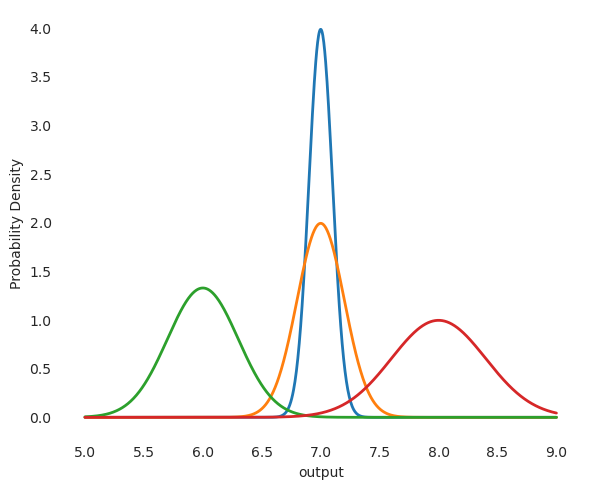

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for the normal distributions
mu1, sigma1 = 7, 0.1  # mean and standard deviation
mu2, sigma2 = 7, 0.2
mu3, sigma3 = 6, 0.3
mu4, sigma4 = 8, 0.4
# Generate data points
x = np.linspace(5, 9, 1000)
y1 = (1/(sigma1 * np.sqrt(2 * np.pi))) * np.exp( - (x - mu1)**2 / (2 * sigma1**2) )
y2 = (1/(sigma2 * np.sqrt(2 * np.pi))) * np.exp( - (x - mu2)**2 / (2 * sigma2**2) )
y3 = (1/(sigma3 * np.sqrt(2 * np.pi))) * np.exp( - (x - mu3)**2 / (2 * sigma3**2) )
y4 = (1/(sigma4 * np.sqrt(2 * np.pi))) * np.exp( - (x - mu4)**2 / (2 * sigma4**2) )
# Create the plot
plt.figure(figsize=(6, 5))
plt.plot(x, y1, label=f'$\mu={mu1}, \sigma={sigma1}$', linewidth=2)
plt.plot(x, y2, label=f'$\mu={mu2}, \sigma={sigma2}$', linewidth=2)
plt.plot(x, y3, label=f'$\mu={mu3}, \sigma={sigma3}$', linewidth=2)
plt.plot(x, y4, label=f'$\mu={mu4}, \sigma={sigma4}$', linewidth=2)

# # Add annotations for sigma
# plt.annotate(f'$\sigma={sigma1}$', xy=(mu1 + sigma1, (1/(sigma1 * np.sqrt(2 * np.pi))) * np.exp( - (sigma1)**2 / (2 * sigma1**2) )), xytext=(mu1 + sigma1 + 1, (1/(sigma1 * np.sqrt(2 * np.pi))) * np.exp( - (sigma1)**2 / (2 * sigma1**2) )),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# 
# plt.annotate(f'$\sigma={sigma2}$', xy=(mu2 + sigma2, (1/(sigma2 * np.sqrt(2 * np.pi))) * np.exp( - (sigma2)**2 / (2 * sigma2**2) )), xytext=(mu2 + sigma2 + 1, (1/(sigma2 * np.sqrt(2 * np.pi))) * np.exp( - (sigma2)**2 / (2 * sigma2**2) )),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# 
# plt.annotate(f'$\sigma={sigma3}$', xy=(mu3 + sigma3, (1/(sigma3 * np.sqrt(2 * np.pi))) * np.exp( - (sigma3)**2 / (2 * sigma3**2) )), xytext=(mu3 + sigma3 + 1, (1/(sigma3 * np.sqrt(2 * np.pi))) * np.exp( - (sigma3)**2 / (2 * sigma3**2) )),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# 
# plt.annotate(f'$\sigma={sigma4}$', xy=(mu4 + sigma4, (1/(sigma4 * np.sqrt(2 * np.pi))) * np.exp( - (sigma4)**2 / (2 * sigma4**2) )), xytext=(mu4 + sigma4 + 1, (1/(sigma4 * np.sqrt(2 * np.pi))) * np.exp( - (sigma4)**2 / (2 * sigma4**2) )),
#              arrowprops=dict(facecolor='black', shrink=0.05))

# Add title and labels
# plt.title('Normal Distributions with Different $\mu$ and $\sigma$')
plt.xlabel('output')
plt.ylabel('Probability Density')
# plt.legend()

# Show the plot
plt.grid(False)
# No background
plt.gca().set_facecolor('white') 
# save the plot
plt.tight_layout()
plt.savefig('normal_distributions.png', dpi=1200)
plt.savefig('normal_distributions.pdf')
plt.savefig('normal_distributions.svg')
plt.show()
